In [1]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
goalkeeper_data_df = pd.read_csv('/kaggle/input/combined-data/goalkeeper_data.csv')
outfield_data_df = pd.read_csv('/kaggle/input/combined-data/outfield_data.csv')
model_performance_df = pd.read_csv('/kaggle/input/model-performance/model_performance.csv')
nn_results_df = pd.read_csv('/kaggle/input/nn-performance/nn_results_Injury Rate.csv')
nn_pca13_results_df = pd.read_csv('/kaggle/input/pca13-nn/pca13_nn_results.csv')

# Splitting the dataset
First we split the dataset (outfield players and goalkeepers) into training and test data.
* Note the imbalance of dataset because it is expected that only a handful of players get injured during the course of the season.
* We want to transform categorical features such as 'League', 'Position' and 'Categorized Position' into numerical values to feed into the model using One Hot Encoding
* Target variables are 'Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate'; the things we would want to predict

In [3]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encoding(df, cols):
    # Create a OneHotEncoder object
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    # Fit and transform the 'Position' column
    df_encoded = pd.DataFrame(encoder.fit_transform(df[cols]))
    df_encoded.columns = encoder.get_feature_names_out()

    df.drop(cols, axis=1, inplace=True)
    return pd.concat([df, df_encoded], axis = 1)

outfield_cols = ['Position', 'Categorized Position', 'League']
gk_cols = ['League']
outfield_data_df = one_hot_encoding(outfield_data_df, outfield_cols)
goalkeeper_data_df = one_hot_encoding(goalkeeper_data_df, gk_cols)

In [4]:
from sklearn.model_selection import train_test_split

# Select features (X) and target variable (y)
outfield_X = outfield_data_df.drop(['Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate', 'Name', 'Birthday', 'Club', 'Injuries', 'Type of Injury', 'Categorized Injuries'], axis=1)
outfield_y = outfield_data_df[['Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate']]
goalkeeper_X = goalkeeper_data_df.drop(['Position', 'Categorized Position', 'Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate', 'Name', 'Birthday', 'Club', 'Injuries', 'Type of Injury', 'Categorized Injuries'], axis=1)
goalkeeper_y = goalkeeper_data_df[['Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate']]

# Split the data into training and testing sets
outfield_X_train, outfield_X_test, outfield_y_train, outfield_y_test = train_test_split(outfield_X, outfield_y, test_size=0.2, random_state=42)
goalkeeper_X_train, goalkeeper_X_test, goalkeeper_y_train, goalkeeper_y_test = train_test_split(goalkeeper_X, goalkeeper_y, test_size=0.2, random_state=42)

In [5]:
# Export datasets
outfield_X_train.to_csv('outfield_X_train.csv', index=False)
outfield_X_test.to_csv('outfield_X_test.csv', index=False)
outfield_y_train.to_csv('outfield_y_train.csv', index=False)
outfield_y_test.to_csv('outfield_y_test.csv', index=False)
goalkeeper_X_train.to_csv('goalkeeper_X_train.csv', index=False)
goalkeeper_X_test.to_csv('goalkeeper_X_test.csv', index=False)
goalkeeper_y_train.to_csv('goalkeeper_y_train.csv', index=False)
goalkeeper_y_test.to_csv('goalkeeper_y_test.csv', index=False)

from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, RobustScaler

# Perform standardisaion
scaler = MinMaxScaler()
outfield_X_train = scaler.fit_transform(outfield_X_train)
outfield_X_test = scaler.fit_transform(outfield_X_test)

goalkeeper_X_train = scaler.fit_transform(goalkeeper_X_train)
goalkeeper_X_test = scaler.fit_transform(goalkeeper_X_test)

# Analysis of training data
We want to identify the general behaviour of our training dataset. We can do so by reducing the dimensionality using Principle Component Analysis. This helps us:
* Reduce dimensions of our features
* Identify any linear seperability between targets

## PCA Analysis
PCA essentially creates as many principal components as there are features in our data. These components are arranged in order of importance, indicating how much of the PCA variance of our data is explained by each component. Typically we want to keep about 80% of the variance, and from the result below, the number of components that we should keep is around 12.5 to 15.

[0.17150201 0.12437322 0.10420449 0.07853144 0.07303621 0.05834568
 0.05260792 0.03377087 0.02874655 0.02640965 0.02360597 0.02200985
 0.0209873  0.02011761 0.01834238 0.01742599 0.01428694 0.01318348
 0.01205291 0.01053297]


Text(0, 0.5, 'Cumulative Explained Vairance')

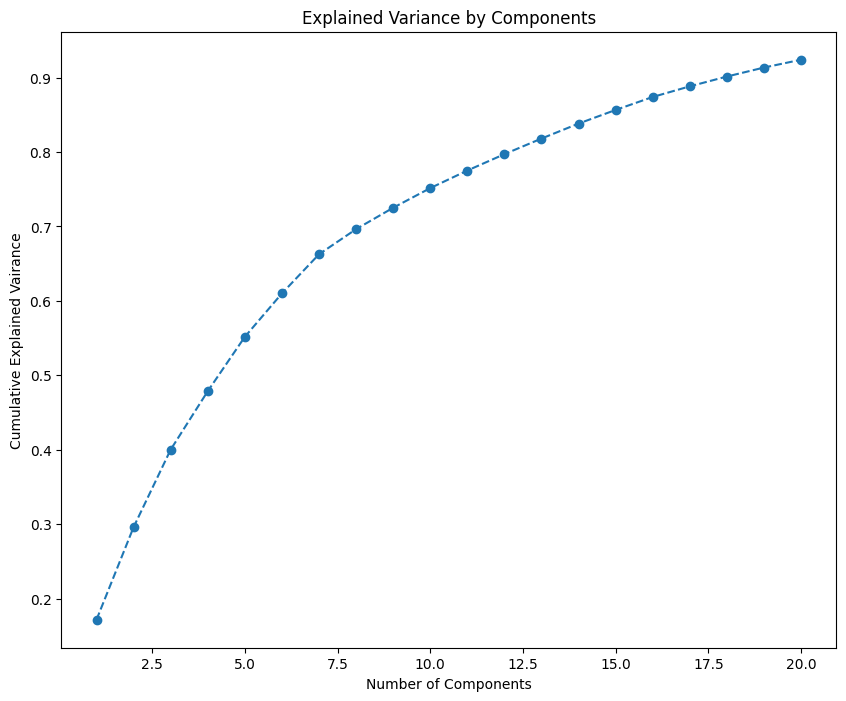

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA()
pca.fit(outfield_X_train)

explained_variance = pca.explained_variance_ratio_[:20].cumsum()
print(pca.explained_variance_ratio_[:20])

plt.figure(figsize = (10, 8))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker = "o", linestyle = "--")
plt.title("Explained Variance by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Vairance")

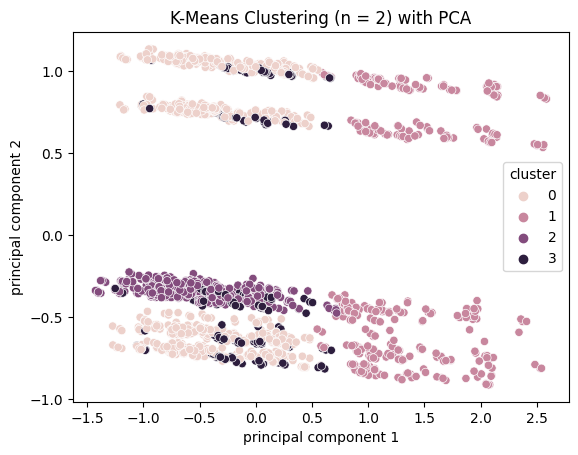

In [7]:
from sklearn.cluster import KMeans
import seaborn as sns

# Apply K-Means clustering (as you did before)
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(outfield_X_train)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
outfield_pca2_X_train = pca.fit_transform(outfield_X_train)
outfield_pca2_X_test = pca.transform(outfield_X_test)
principalDf = pd.DataFrame(data = outfield_pca2_X_train, columns = ['principal component 1', 'principal component 2'])

# Add cluster labels to the principal components DataFrame
principalDf['cluster'] = cluster_labels

# Visualize the clusters using Seaborn
sns.scatterplot(x='principal component 1', y='principal component 2', hue='cluster', data=principalDf)
plt.title('K-Means Clustering (n = 2) with PCA')
plt.show()

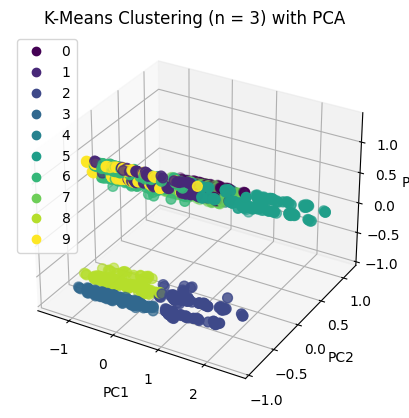

In [8]:
# Apply K-Means clustering (as you did before)
kmeans = KMeans(n_clusters=10, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(outfield_X_train)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=3)
outfield_pca3_X_train = pca.fit_transform(outfield_X_train)
outfield_pca3_X_test = pca.transform(outfield_X_test)
principalDf = pd.DataFrame(data = outfield_pca3_X_train, columns = ['PCA1', 'PCA2', 'PCA3'])

# Add cluster labels to the principal components DataFrame
principalDf['cluster'] = cluster_labels

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(principalDf['PCA1'], principalDf['PCA2'], principalDf['PCA3'], c=principalDf['cluster'], cmap='viridis', s=50)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.legend(*scatter.legend_elements())
plt.title('K-Means Clustering (n = 3) with PCA')
plt.show()

In [9]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=13)
outfield_pca13_X_train = pca.fit_transform(outfield_X_train)
outfield_pca13_X_test = pca.transform(outfield_X_test)

# Training Different Regression Models
In the follow sections, we try to train different regression models on our data. To evaluate the performance of each regression mode, we can use several scores
* **Mean Squared Error (MSE)**
    * Formula: `MSE = Σ(y_true - y_pred)^2 / n`
    * Range: 0 to infinity
    * Interpretation: Measures the average squared difference between predicted and actual values. Lower values indicate better performance.
    * Sensitivity: Sensitive to outliers due to squaring the errors.
* **Normalized Root Mean Squared Error (NRMSE)**
    * Formula: `NRMSE = RMSE / Mean(y_true)`
    * Range: 0 to infinity
    * Interpretation: Provides a relative measure of error, making it easier to compare models for different target variables. Lower NRMSE values indicate better model performance.
        * An NRMSE value of 1 indicates that the average prediction error is equal to the average value of the target variable.
        * An NRMSE value less than 1 suggests that the model's predictions are better than simply predicting the mean.
    * Sensitivity: Like MSE, sensitive to outliers.
* **Mean Absolute Error (MAE)**
    * Formula: `MAE = Σ|y_true - y_pred| / n`
    * Range: 0 to infinity
    * Interpretation: Measures the average absolute difference between predicted and actual values. Less sensitive to outliers than MSE.
    * Sensitivity: Less sensitive to outliers compared to MSE.
* **R-squared (Coefficient of Determination)**
    * Formula: `R^2 = 1 - (SS_res / SS_tot)`
    * Range: -infinity to 1
    * Interpretation: Represents the proportion of variance in the dependent variable explained by the independent variables. Higher values indicate a better fit.
    * Negative R-squared: Indicates the model is performing worse than simply predicting the mean of the dependent variable.

In [10]:
evaluation_metrics = {'Model': [], 'Target': [], 'Mean Square Error': [], 'Mean Absolute Error': [], 'Normalized Root Mean Square Error': [], 'R-Squared Error': []}
def add_evaluation_metrics(model, target, mse, mae, nrmse, r2):
    evaluation_metrics['Model'].append(model)
    evaluation_metrics['Target'].append(target)
    evaluation_metrics['Mean Square Error'].append(mse)
    evaluation_metrics['Mean Absolute Error'].append(mae)
    evaluation_metrics['Normalized Root Mean Square Error'].append(nrmse)
    evaluation_metrics['R-Squared Error'].append(r2)

## Simple Linear Regression Model

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from termcolor import colored
import numpy as np

def normalized_root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / np.mean(y_true)

targets = ['Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate']
def get_linear_regression_scores(df_X, df_y, X_test, y_test, target):
    model = LinearRegression()
    model.fit(df_X, df_y[target])

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate the MSE
    mse = mean_squared_error(y_test[target], y_pred)

    print("Mean Squared Error for ", target, ":", mse)
          
    nrmse = normalized_root_mean_squared_error(y_test[target], y_pred)
          
    print("Normalised Root Mean Squared Error for ", target, ":", nrmse)
    
    mae = mean_absolute_error(outfield_y_test['Total Days'], y_pred)
    
    print("Mean Absolute Error for ", target, ":", mae)
          
    # Calculate the R-squared score
    r2 = r2_score(y_test[target], y_pred)

    print("R-squared for ", target, ":", r2, "\n")
    
    return (mse, mae, nrmse, r2)

print(colored('All features:', 'black', attrs=['bold']))
for target in targets:
    mse, mae, nrmse, r2 = get_linear_regression_scores(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, target)
    add_evaluation_metrics('Linear Regression', target, mse, mae, nrmse, r2)

print(colored('PCA Components with n = 2:', 'black', attrs=['bold']))
for target in targets:
    mse, mae, nrmse, r2 = get_linear_regression_scores(outfield_pca2_X_train, outfield_y_train, outfield_pca2_X_test, outfield_y_test, target)
    add_evaluation_metrics('Linear Regression (PCA n = 2)', target, mse, mae, nrmse, r2)
    
print(colored('PCA Components with n = 3:', 'black', attrs=['bold']))
for target in targets:
    mse, mae, nrmse, r2 = get_linear_regression_scores(outfield_pca3_X_train, outfield_y_train, outfield_pca3_X_test, outfield_y_test, target)
    add_evaluation_metrics('Linear Regression (PCA n = 3)', target, mse, mae, nrmse, r2)
    
print(colored('PCA Components with n = 13:', 'black', attrs=['bold']))
for target in targets:
    mse, mae, nrmse, r2 = get_linear_regression_scores(outfield_pca13_X_train, outfield_y_train, outfield_pca13_X_test, outfield_y_test, target)
    add_evaluation_metrics('Linear Regression (PCA n = 13)', target, mse, mae, nrmse, r2)

All features:
Mean Squared Error for  Total Days : 3030.931202342048
Normalised Root Mean Squared Error for  Total Days : 1.4921604470029501
Mean Absolute Error for  Total Days : 36.93273420479303
R-squared for  Total Days : 0.21897205417730392 

Mean Squared Error for  Total Games Missed : 56.79102307155501
Normalised Root Mean Squared Error for  Total Games Missed : 1.4141519575943684
Mean Absolute Error for  Total Games Missed : 35.702682461873636
R-squared for  Total Games Missed : 0.25110361467390285 

Mean Squared Error for  Injury Count : 1.074276793236826
Normalised Root Mean Squared Error for  Injury Count : 1.0548585824898993
Mean Absolute Error for  Injury Count : 36.57511233660131
R-squared for  Injury Count : 0.1967344458233271 

Mean Squared Error for  Average Injury Cost : 0.018559103602989048
Normalised Root Mean Squared Error for  Average Injury Cost : 1.131771885208982
Mean Absolute Error for  Average Injury Cost : 36.863572729439
R-squared for  Average Injury Cost : 

## K Nearest Neighbours
* Hyperparameters that we can tune: K value, Distance Metrics

### Finding an estimate of the best distance metric
To find a suitable distance metric, we fix and arbitrary K value and iterate through some common metrics. The best metrics will be indicated by the lowest errors achieved.

In [12]:
from sklearn.neighbors import KNeighborsRegressor

metrics = ['euclidean', 'manhattan', 'minkowski', 'cosine', 'chebyshev']  # You can add or remove metrics

# Create empty lists to store performance metrics
mse_scores = []
mae_scores = []
nrmse_scores = []
r2_scores = []

# Loop through each distance metric
for metric in metrics:
    knn_model = KNeighborsRegressor(n_neighbors=5, metric=metric)
    knn_model.fit(outfield_X_train, outfield_y_train['Total Days'])
    y_pred = knn_model.predict(outfield_X_test)

    mse = mean_squared_error(outfield_y_test['Total Days'], y_pred)
    mae = mean_absolute_error(outfield_y_test['Total Days'], y_pred)
    nrmse = normalized_root_mean_squared_error(outfield_y_test['Total Days'], y_pred)
    r2 = r2_score(outfield_y_test['Total Days'], y_pred)

    mse_scores.append(mse)
    mae_scores.append(mae)
    nrmse_scores.append(nrmse)
    r2_scores.append(r2)

print(colored('Detailed Results:', 'black', attrs=['bold']))
for i, metric in enumerate(metrics):
    print(f"\nMetric: {metric}")
    print(f"MSE: {mse_scores[i]:.4f}")
    print(f"NRMSE: {nrmse_scores[i]:.4f}")
    print(f"MAE: {mae_scores[i]:.4f}")
    print(f"R-squared: {r2_scores[i]:.4f}")

Detailed Results:

Metric: euclidean
MSE: 3956.6825
NRMSE: 1.7049
MAE: 40.2745
R-squared: -0.0196

Metric: manhattan
MSE: 4123.5397
NRMSE: 1.7405
MAE: 41.1512
R-squared: -0.0626

Metric: minkowski
MSE: 3956.6825
NRMSE: 1.7049
MAE: 40.2745
R-squared: -0.0196

Metric: cosine
MSE: 3853.0743
NRMSE: 1.6824
MAE: 39.4318
R-squared: 0.0071

Metric: chebyshev
MSE: 3746.1045
NRMSE: 1.6589
MAE: 40.8458
R-squared: 0.0347


### Finding the best K Value for each target
Given a suitable distance metric, to find the best K value we can plot a graph of K against the error (NRMSE). The most suitable value of K will be at the 'elbow point'.

In [13]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

def get_knn_error_rates(df_X, df_y, X_test, y_test, target, k=None):
    # Define a range of k values if k is not provided
    neighbors = np.arange(1, 50) if k is None else [k]

    # Create an empty list to store error values
    error_rates = []

    # Loop over k values
    for i in neighbors:
        knn = KNeighborsRegressor(n_neighbors=i, metric='chebyshev')
        knn.fit(df_X, df_y[target])
        y_pred = knn.predict(X_test)
        error = normalized_root_mean_squared_error(y_test[target], y_pred)
        error_rates.append(error)

    # Create a DataFrame to hold the results
    error_df = pd.DataFrame({'k': neighbors, 'error': error_rates})

    # Find the k value with the lowest error (if k is not provided)
    if k is None:
        best_k = error_df.loc[error_df['error'].idxmin(), 'k']
    else:
        best_k = k

    # Create a line plot using Seaborn
    sns.lineplot(x='k', y='error', data=error_df, marker='o')
    plt.title(f'K-Nearest Neighbors: Error Rate vs. K Value for {target}')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Normalized Root Mean Squared Error')
    plt.show()

    return best_k, error_df

def get_best_knn_error_rates(df_X, df_y, X_test, y_test, target, k):
    knn = KNeighborsRegressor(n_neighbors=k, metric='chebyshev')
    knn.fit(df_X, df_y[target])
    y_pred = knn.predict(X_test)
    mse = mean_squared_error(outfield_y_test[target], y_pred)
    mae = mean_absolute_error(outfield_y_test[target], y_pred)
    nrmse = normalized_root_mean_squared_error(outfield_y_test[target], y_pred)
    r2 = r2_score(outfield_y_test[target], y_pred)
    
    print("Mean Squared Error for ", target, ":", mse)          
    print("Normalised Root Mean Squared Error for ", target, ":", nrmse)    
    print("Mean Absolute Error for ", target, ":", mae)
    print("R-squared for ", target, ":", r2, "\n")

    return mse, mae, nrmse, r2

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


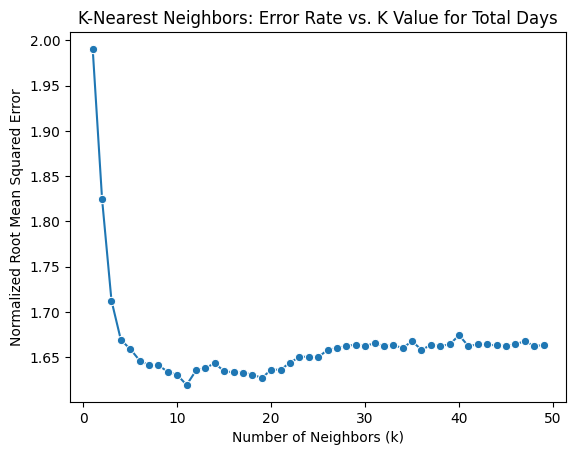

Best K:  11
Smallest Normalised Root MSE:  1.619200373379629
Mean Squared Error for  Total Days : 3568.9973172005257
Normalised Root Mean Squared Error for  Total Days : 1.619200373379629
Mean Absolute Error for  Total Days : 39.639136462665874
R-squared for  Total Days : 0.08032005439585532 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


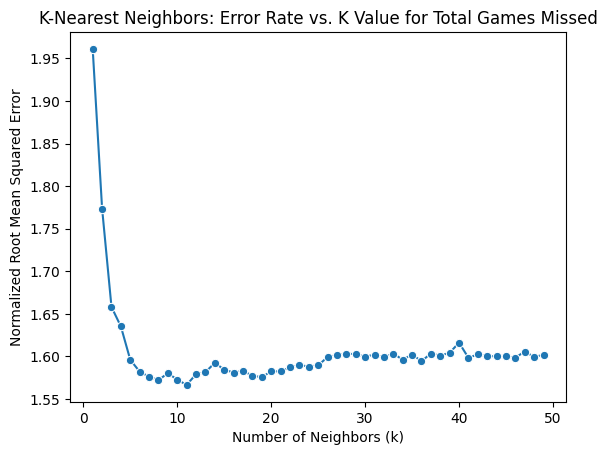

Best K:  11
Smallest Normalised Root MSE:  1.5666261399582908
Mean Squared Error for  Total Games Missed : 69.69767190622805
Normalised Root Mean Squared Error for  Total Games Missed : 1.5666261399582908
Mean Absolute Error for  Total Games Missed : 5.793424440483264
R-squared for  Total Games Missed : 0.08090519006053787 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


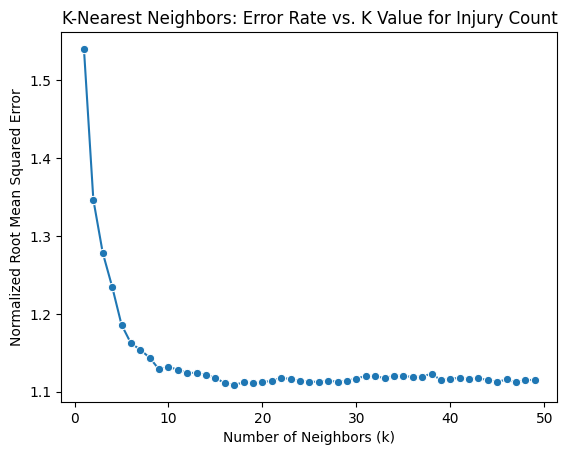

Best K:  17
Smallest Normalised Root MSE:  1.1087868700648518
Mean Squared Error for  Injury Count : 1.1869265968594283
Normalised Root Mean Squared Error for  Injury Count : 1.1087868700648518
Mean Absolute Error for  Injury Count : 0.8459566833269254
R-squared for  Injury Count : 0.11250316808887939 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


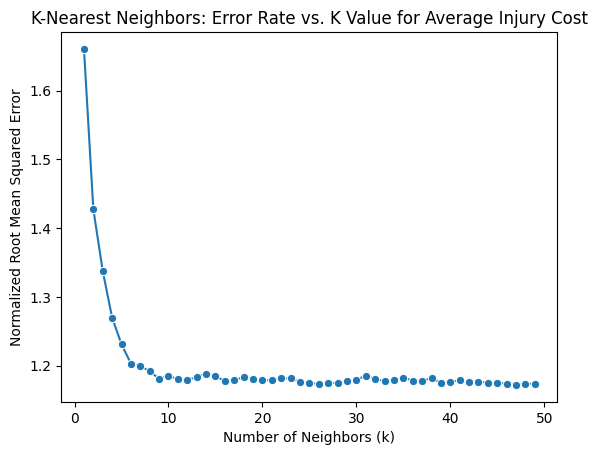

Best K:  47
Smallest Normalised Root MSE:  1.1720869867039876
Mean Squared Error for  Average Injury Cost : 0.0199048487520354
Normalised Root Mean Squared Error for  Average Injury Cost : 1.1720869867039876
Mean Absolute Error for  Average Injury Cost : 0.10886849302368702
R-squared for  Average Injury Cost : 0.07587277975297735 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


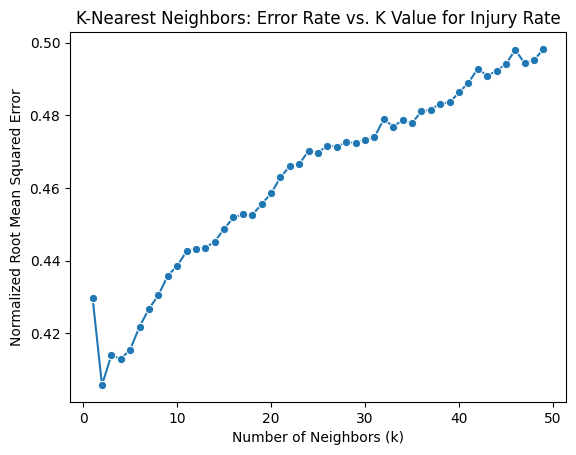

Best K:  2
Smallest Normalised Root MSE:  0.40582242264318896
Mean Squared Error for  Injury Rate : 4.794703809943039e-08
Normalised Root Mean Squared Error for  Injury Rate : 0.40582242264318896
Mean Absolute Error for  Injury Rate : 0.0001327048029095531
R-squared for  Injury Rate : 0.6062556873157394 



In [14]:
for target in targets:
    best_k, error_df = get_knn_error_rates(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, target)
    print("Best K: ", best_k)
    print("Smallest Normalised Root MSE: ", error_df['error'].min())
    mse, mae, nrmse, r2 = get_best_knn_error_rates(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, target, best_k)
    add_evaluation_metrics('KNN with best K', target, mse, mae, nrmse, r2)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


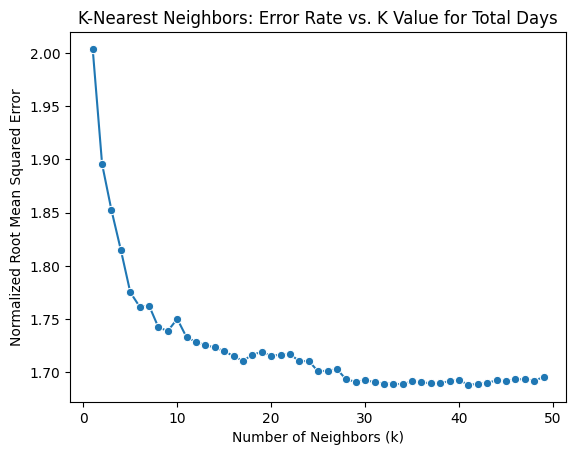

Best K:  41
Smallest Normalised Root MSE:  1.6881448055335362
Mean Squared Error for  Total Days : 3879.398775757246
Normalised Root Mean Squared Error for  Total Days : 1.6881448055335362
Mean Absolute Error for  Total Days : 42.5551835910516
R-squared for  Total Days : 0.00033400477203249235 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


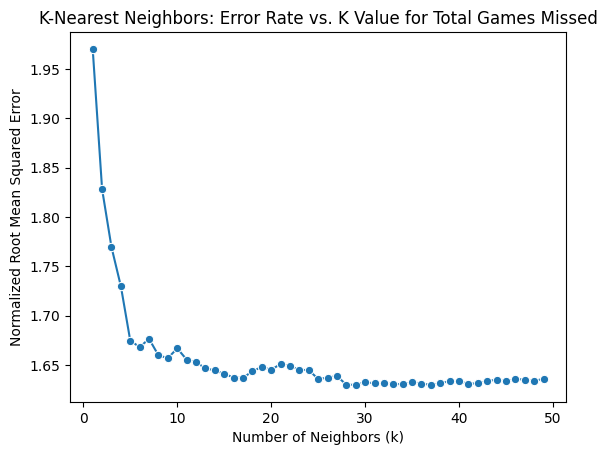

Best K:  37
Smallest Normalised Root MSE:  1.6296215341344107
Mean Squared Error for  Total Games Missed : 75.415574557069
Normalised Root Mean Squared Error for  Total Games Missed : 1.6296215341344107
Mean Absolute Error for  Total Games Missed : 6.175116292763351
R-squared for  Total Games Missed : 0.005503896066134106 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


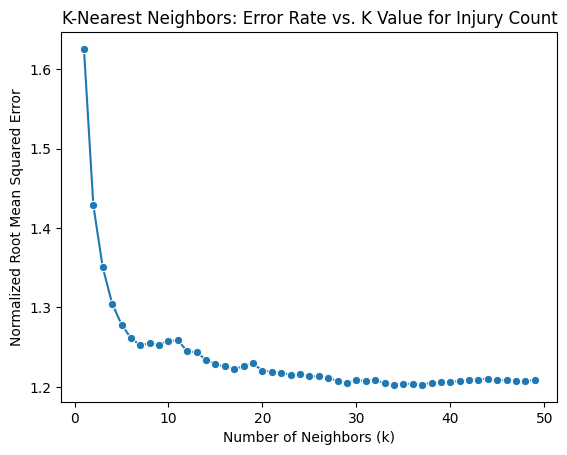

Best K:  34
Smallest Normalised Root MSE:  1.2024257745666111
Mean Squared Error for  Injury Count : 1.3958677280985445
Normalised Root Mean Squared Error for  Injury Count : 1.2024257745666111
Mean Absolute Error for  Injury Count : 0.9174035627322825
R-squared for  Injury Count : -0.04372771638308004 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


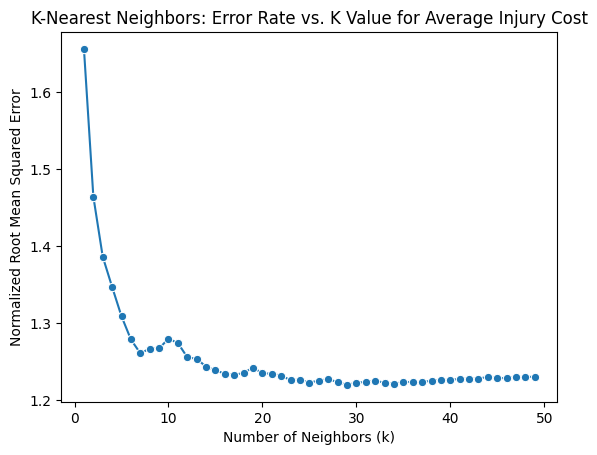

Best K:  29
Smallest Normalised Root MSE:  1.2194908028641758
Mean Squared Error for  Average Injury Cost : 0.02154746838886169
Normalised Root Mean Squared Error for  Average Injury Cost : 1.2194908028641758
Mean Absolute Error for  Average Injury Cost : 0.11562617384118398
R-squared for  Average Injury Cost : -0.0003895188363665092 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


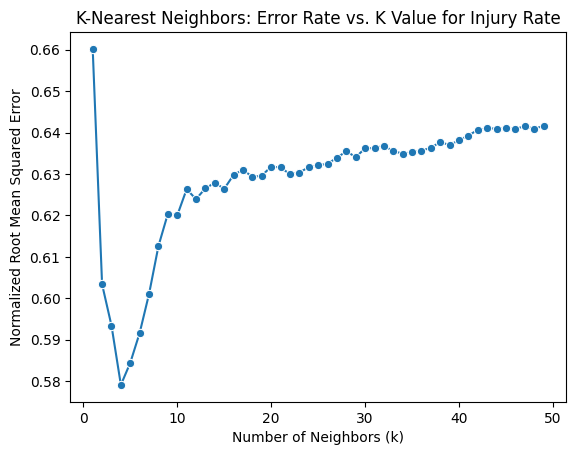

Best K:  4
Smallest Normalised Root MSE:  0.5790663631466039
Mean Squared Error for  Injury Rate : 9.762170362968266e-08
Normalised Root Mean Squared Error for  Injury Rate : 0.5790663631466039
Mean Absolute Error for  Injury Rate : 0.00023100448855155561
R-squared for  Injury Rate : 0.19832398157681774 



In [15]:
for target in targets:
    best_k, error_df = get_knn_error_rates(outfield_pca2_X_train, outfield_y_train, outfield_pca2_X_test, outfield_y_test, target)
    print("Best K: ", best_k)
    print("Smallest Normalised Root MSE: ", error_df['error'].min())
    mse, mae, nrmse, r2 = get_best_knn_error_rates(outfield_pca2_X_train, outfield_y_train, outfield_pca2_X_test, outfield_y_test, target, best_k)
    add_evaluation_metrics('KNN with best K (PCA n = 2)', target, mse, mae, nrmse, r2)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


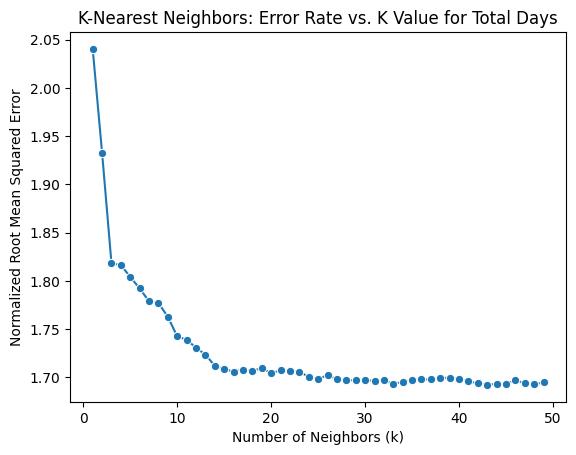

Best K:  43
Smallest Normalised Root MSE:  1.691991297626012
Mean Squared Error for  Total Days : 3897.0975855759043
Normalised Root Mean Squared Error for  Total Days : 1.691991297626012
Mean Absolute Error for  Total Days : 42.36687439833815
R-squared for  Total Days : -0.00422672727806872 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


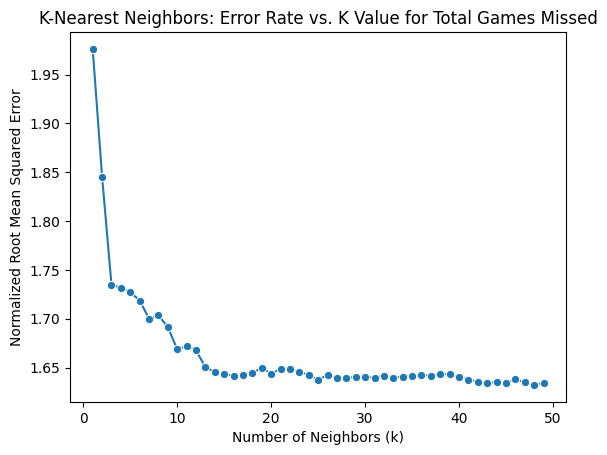

Best K:  48
Smallest Normalised Root MSE:  1.6322090155560438
Mean Squared Error for  Total Games Missed : 75.65525145243284
Normalised Root Mean Squared Error for  Total Games Missed : 1.6322090155560438
Mean Absolute Error for  Total Games Missed : 6.176742919389978
R-squared for  Total Games Missed : 0.0023433056968075183 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


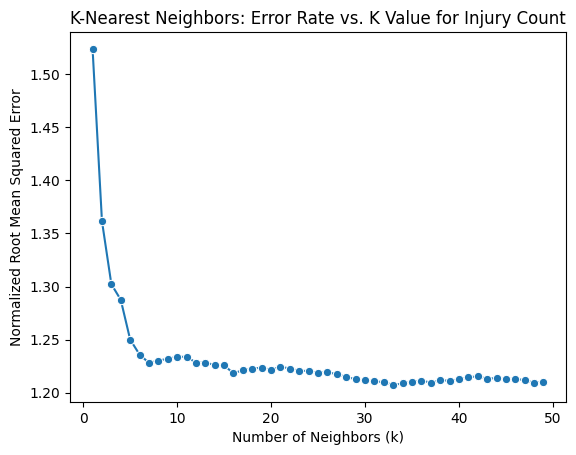

Best K:  33
Smallest Normalised Root MSE:  1.2072991142761313
Mean Squared Error for  Injury Count : 1.4072053471934638
Normalised Root Mean Squared Error for  Injury Count : 1.2072991142761313
Mean Absolute Error for  Injury Count : 0.9162870535419556
R-squared for  Injury Count : -0.0522051580840075 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


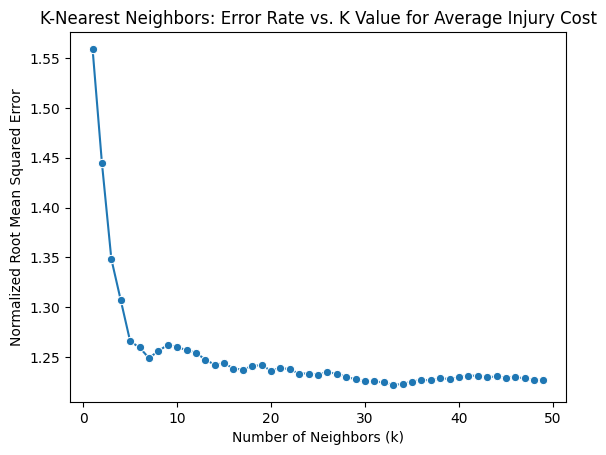

Best K:  33
Smallest Normalised Root MSE:  1.2218618647291715
Mean Squared Error for  Average Injury Cost : 0.021631339539182677
Normalised Root Mean Squared Error for  Average Injury Cost : 1.2218618647291715
Mean Absolute Error for  Average Injury Cost : 0.11551528355449925
R-squared for  Average Injury Cost : -0.004283424988109186 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


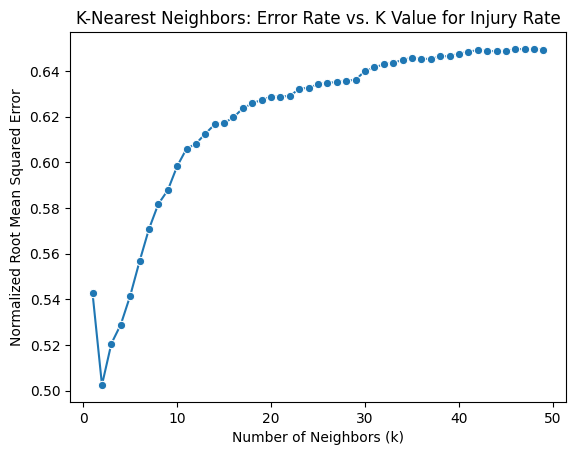

Best K:  2
Smallest Normalised Root MSE:  0.5025377677928661
Mean Squared Error for  Injury Rate : 7.352366006518584e-08
Normalised Root Mean Squared Error for  Injury Rate : 0.5025377677928661
Mean Absolute Error for  Injury Rate : 0.0001560032889197848
R-squared for  Injury Rate : 0.3962187416381465 



In [16]:
for target in targets:
    best_k, error_df = get_knn_error_rates(outfield_pca3_X_train, outfield_y_train, outfield_pca3_X_test, outfield_y_test, target)
    print("Best K: ", best_k)
    print("Smallest Normalised Root MSE: ", error_df['error'].min())
    mse, mae, nrmse, r2 = get_best_knn_error_rates(outfield_pca3_X_train, outfield_y_train, outfield_pca3_X_test, outfield_y_test, target, best_k)
    add_evaluation_metrics('KNN with best K (PCA n = 3)', target, mse, mae, nrmse, r2)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


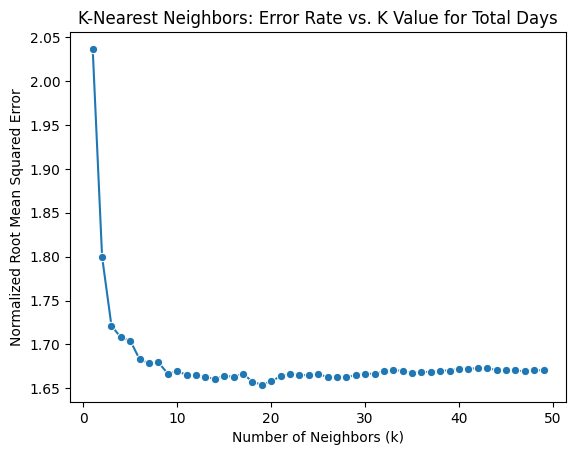

Best K:  19
Smallest Normalised Root MSE:  1.6539413418776567
Mean Squared Error for  Total Days : 3723.7904755007576
Normalised Root Mean Squared Error for  Total Days : 1.6539413418776567
Mean Absolute Error for  Total Days : 40.19263845889233
R-squared for  Total Days : 0.04043205483940937 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


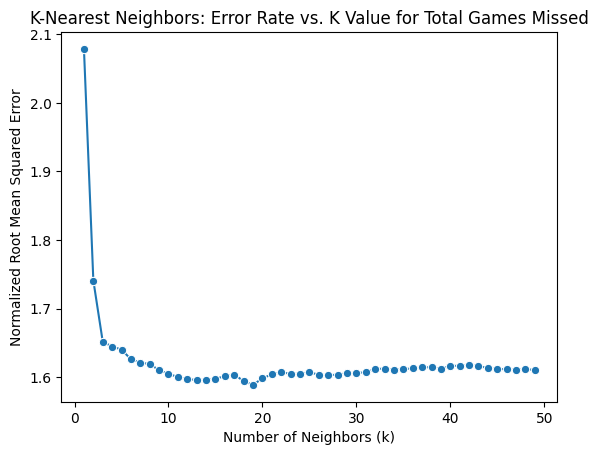

Best K:  19
Smallest Normalised Root MSE:  1.5887540462553345
Mean Squared Error for  Total Games Missed : 71.68047483690306
Normalised Root Mean Squared Error for  Total Games Missed : 1.5887540462553345
Mean Absolute Error for  Total Games Missed : 5.866185070519435
R-squared for  Total Games Missed : 0.05475820648312357 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


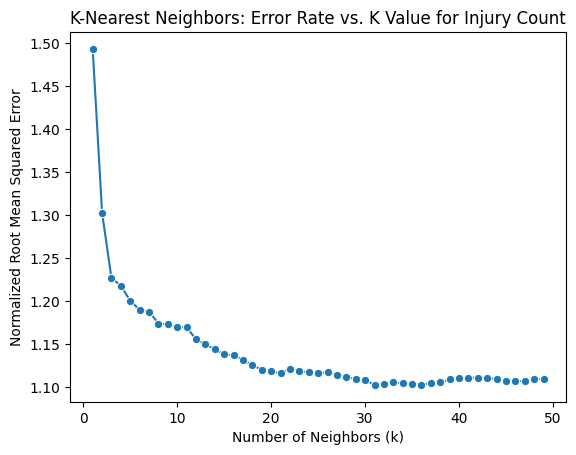

Best K:  31
Smallest Normalised Root MSE:  1.102791927171211
Mean Squared Error for  Injury Count : 1.1741264432701046
Normalised Root Mean Squared Error for  Injury Count : 1.102791927171211
Mean Absolute Error for  Injury Count : 0.840958605664488
R-squared for  Injury Count : 0.12207418603435205 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


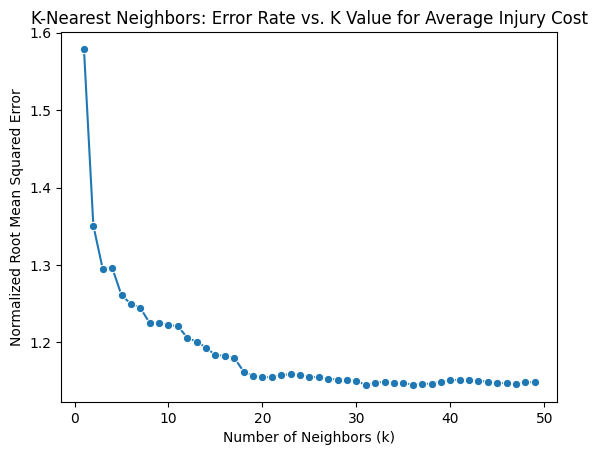

Best K:  31
Smallest Normalised Root MSE:  1.144992647976489
Mean Squared Error for  Average Injury Cost : 0.018995231455977004
Normalised Root Mean Squared Error for  Average Injury Cost : 1.144992647976489
Mean Absolute Error for  Average Injury Cost : 0.10740881298756062
R-squared for  Average Injury Cost : 0.11810380163949641 



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


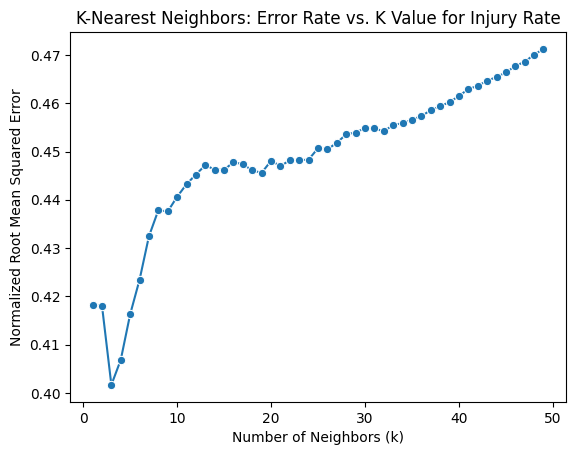

Best K:  3
Smallest Normalised Root MSE:  0.40164519262572795
Mean Squared Error for  Injury Rate : 4.6965056818246296e-08
Normalised Root Mean Squared Error for  Injury Rate : 0.40164519262572795
Mean Absolute Error for  Injury Rate : 0.00013953708689683997
R-squared for  Injury Rate : 0.6143197838679983 



In [17]:
for target in targets:
    best_k, error_df = get_knn_error_rates(outfield_pca13_X_train, outfield_y_train, outfield_pca13_X_test, outfield_y_test, target)
    print("Best K: ", best_k)
    print("Smallest Normalised Root MSE: ", error_df['error'].min())
    mse, mae, nrmse, r2 = get_best_knn_error_rates(outfield_pca13_X_train, outfield_y_train, outfield_pca13_X_test, outfield_y_test, target, best_k)
    add_evaluation_metrics('KNN with best K (PCA n = 13)', target, mse, mae, nrmse, r2)

## Decision Tree

In [18]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

def get_decision_tree_error_rates(df_X, df_y, X_test, y_test, target):
    # Create a decision tree model
    dt_model = DecisionTreeRegressor()

    # Fit the model to the training data
    dt_model.fit(df_X, df_y[target])

    # Make predictions on the test set
    y_pred = dt_model.predict(X_test)

    mse = mean_squared_error(y_test[target], y_pred)
    mae = mean_absolute_error(y_test[target], y_pred)
    nrmse = normalized_root_mean_squared_error(y_test[target], y_pred)
    r2 = r2_score(y_test[target], y_pred)

    title = 'Decision Tree Errors for ' + target + ':'
    print(colored(title, 'black', attrs=['bold']))
    print("MSE:", mse)
    print("MAE:", mae)
    print("NRMSE:", nrmse)
    print("R-squared:", r2, '\n')
    
    return mse, mae, nrmse, r2

In [19]:
for target in targets:
    mse, mae, nrmse, r2 = get_decision_tree_error_rates(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, target)
    add_evaluation_metrics('Decision Tree', target, mse, mae, nrmse, r2)

Decision Tree Errors for Total Days:
MSE: 5833.2091503267975
MAE: 46.13289760348584
NRMSE: 2.0700520172325887
R-squared: -0.5031351938023132 

Decision Tree Errors for Total Games Missed:
MSE: 99.2004357298475
MAE: 6.355119825708061
NRMSE: 1.8690160149681307
R-squared: -0.30814420524265485 

Decision Tree Errors for Injury Count:
MSE: 1.934640522875817
MAE: 1.0021786492374727
NRMSE: 1.4155860812302776
R-squared: -0.44658257678466207 

Decision Tree Errors for Average Injury Cost:
MSE: 0.0370161220043573
MAE: 0.12413943355119825
NRMSE: 1.5983646358774986
R-squared: -0.7185564360901469 

Decision Tree Errors for Injury Rate:
MSE: 1.671951257873461e-11
MAE: 1.9085584437112983e-07
NRMSE: 0.007578215539539801
R-squared: 0.9998626982343503 



In [20]:
for target in targets:
    mse, mae, nrmse, r2 = get_decision_tree_error_rates(outfield_pca2_X_train, outfield_y_train, outfield_pca2_X_test, outfield_y_test, target)
    add_evaluation_metrics('Decision Tree (PCA n = 2)', target, mse, mae, nrmse, r2)

Decision Tree Errors for Total Days:
MSE: 5793.745098039216
MAE: 46.75599128540305
NRMSE: 2.0630377580683597
R-squared: -0.4929658677324269 

Decision Tree Errors for Total Games Missed:
MSE: 117.91721132897604
MAE: 6.85838779956427
NRMSE: 2.0377215236259216
R-squared: -0.5549600721356698 

Decision Tree Errors for Injury Count:
MSE: 2.8257080610021785
MAE: 1.2004357298474946
NRMSE: 1.7108021561486022
R-squared: -1.1128576600109308 

Decision Tree Errors for Average Injury Cost:
MSE: 0.036982135076252726
MAE: 0.13694989106753813
NRMSE: 1.597630685692517
R-squared: -0.7169785167708249 

Decision Tree Errors for Injury Rate:
MSE: 1.6059404536963765e-07
MAE: 0.0002532499017067351
NRMSE: 0.7427110172190716
R-squared: -0.31880913861922444 



In [21]:
for target in targets:
    mse, mae, nrmse, r2 = get_decision_tree_error_rates(outfield_pca3_X_train, outfield_y_train, outfield_pca3_X_test, outfield_y_test, target)
    add_evaluation_metrics('Decision Tree (PCA n = 3)', target, mse, mae, nrmse, r2)

Decision Tree Errors for Total Days:
MSE: 5699.418300653595
MAE: 46.525054466230934
NRMSE: 2.0461748899958754
R-squared: -0.46865919104468223 

Decision Tree Errors for Total Games Missed:
MSE: 132.58169934640523
MAE: 7.152505446623094
NRMSE: 2.160717669559487
R-squared: -0.7483389104614622 

Decision Tree Errors for Injury Count:
MSE: 2.3681917211328978
MAE: 1.0740740740740742
NRMSE: 1.566190455220214
R-squared: -0.7707604290145582 

Decision Tree Errors for Average Injury Cost:
MSE: 0.03907429193899782
MAE: 0.13923747276688453
NRMSE: 1.6421996743012022
R-squared: -0.8141115887160035 

Decision Tree Errors for Injury Rate:
MSE: 1.0541091838661254e-07
MAE: 0.00016860235875694446
NRMSE: 0.6017248477204556
R-squared: 0.13435842432055234 



In [22]:
for target in targets:
    mse, mae, nrmse, r2 = get_decision_tree_error_rates(outfield_pca13_X_train, outfield_y_train, outfield_pca13_X_test, outfield_y_test, target)
    add_evaluation_metrics('Decision Tree (PCA n = 13)', target, mse, mae, nrmse, r2)

Decision Tree Errors for Total Days:
MSE: 5985.7864923747275
MAE: 47.272331154684096
NRMSE: 2.096950097996601
R-squared: -0.542452208964749 

Decision Tree Errors for Total Games Missed:
MSE: 116.21786492374727
MAE: 6.697167755991285
NRMSE: 2.022985077138228
R-squared: -0.5325509956397378 

Decision Tree Errors for Injury Count:
MSE: 1.8387799564270153
MAE: 0.9324618736383442
NRMSE: 1.3800697106065682
R-squared: -0.3749050617187555 

Decision Tree Errors for Average Injury Cost:
MSE: 0.03160043572984749
MAE: 0.12122004357298476
NRMSE: 1.4768178695559886
R-squared: -0.46712106147666566 

Decision Tree Errors for Injury Rate:
MSE: 1.1124582733262363e-08
MAE: 2.9600314953622066e-05
NRMSE: 0.1954776062786622
R-squared: 0.9086441758274195 



## Random Forest

In [23]:
from sklearn.ensemble import RandomForestRegressor

def get_random_forest_error_rates(df_X, df_y, X_test, y_test, target):
    # Create a random forest model
    rf_model = RandomForestRegressor(n_estimators=100)
      # Adjust n_estimators as needed

    # Fit the model to the training data
    rf_model.fit(df_X, df_y[target])

    # Make predictions on the test set
    y_pred = rf_model.predict(X_test)
    
    mse = mean_squared_error(y_test[target], y_pred)
    mae = mean_absolute_error(y_test[target], y_pred)
    nrmse = normalized_root_mean_squared_error(y_test[target], y_pred)
    r2 = r2_score(y_test[target], y_pred)

    title = 'Random Forest Errors for ' + target + ':'
    print(colored(title, 'black', attrs=['bold']))
    print("MSE:", mse)
    print("MAE:", mae)
    print("NRMSE:", nrmse)
    print("R-squared:", r2, '\n')
    
    return mse, mae, nrmse, r2

In [24]:
for target in targets:
    mse, mae, nrmse, r2 = get_random_forest_error_rates(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, target)
    add_evaluation_metrics('Random Forest', target, mse, mae, nrmse, r2)

Random Forest Errors for Total Days:
MSE: 2915.231101525055
MAE: 35.70174291938997
NRMSE: 1.4634031276076973
R-squared: 0.2487863277585547 

Random Forest Errors for Total Games Missed:
MSE: 56.27662854030501
MAE: 5.194357298474945
NRMSE: 1.4077329259694957
R-squared: 0.2578868734399804 

Random Forest Errors for Injury Count:
MSE: 1.0762755991285402
MAE: 0.800544662309368
NRMSE: 1.0558394645688929
R-squared: 0.1952398850803162 

Random Forest Errors for Average Injury Cost:
MSE: 0.018236230697167757
MAE: 0.10384640522875817
NRMSE: 1.121883968232064
R-squared: 0.1533421131756263 

Random Forest Errors for Injury Rate:
MSE: 4.22048969888572e-11
MAE: 3.073552923199903e-07
NRMSE: 0.012040279521960297
R-squared: 0.9996534105376368 



In [25]:
for target in targets:
    mse, mae, nrmse, r2 = get_decision_tree_error_rates(outfield_pca2_X_train, outfield_y_train, outfield_pca2_X_test, outfield_y_test, target)
    add_evaluation_metrics('Random Forest (PCA n = 2)', target, mse, mae, nrmse, r2)

Decision Tree Errors for Total Days:
MSE: 6107.729847494554
MAE: 48.148148148148145
NRMSE: 2.1182021000189564
R-squared: -0.573875280554883 

Decision Tree Errors for Total Games Missed:
MSE: 123.36383442265796
MAE: 6.976034858387799
NRMSE: 2.0842516919264553
R-squared: -0.6267840352636569 

Decision Tree Errors for Injury Count:
MSE: 2.8300653594771243
MAE: 1.2004357298474946
NRMSE: 1.712120693651573
R-squared: -1.116115728877563 

Decision Tree Errors for Average Injury Cost:
MSE: 0.037329629629629636
MAE: 0.13657952069716775
NRMSE: 1.6051190300384943
R-squared: -0.7331117303241481 

Decision Tree Errors for Injury Rate:
MSE: 1.56345593428963e-07
MAE: 0.0002510582710047469
NRMSE: 0.7328211073234688
R-squared: -0.2839205645662439 



In [26]:
for target in targets:
    mse, mae, nrmse, r2 = get_decision_tree_error_rates(outfield_pca3_X_train, outfield_y_train, outfield_pca3_X_test, outfield_y_test, target)
    add_evaluation_metrics('Random Forest (PCA n = 3)', target, mse, mae, nrmse, r2)

Decision Tree Errors for Total Days:
MSE: 6067.202614379085
MAE: 47.254901960784316
NRMSE: 2.1111628439750985
R-squared: -0.563431987877836 

Decision Tree Errors for Total Games Missed:
MSE: 129.7363834422658
MAE: 7.03921568627451
NRMSE: 2.137406503455702
R-squared: -0.7108180721234016 

Decision Tree Errors for Injury Count:
MSE: 2.457516339869281
MAE: 1.0544662309368191
NRMSE: 1.5954542334524182
R-squared: -0.8375508407805166 

Decision Tree Errors for Average Injury Cost:
MSE: 0.04026230936819172
MAE: 0.1421350762527233
NRMSE: 1.6669775229306913
R-squared: -0.8692679608202483 

Decision Tree Errors for Injury Rate:
MSE: 9.611188045047333e-08
MAE: 0.00015983021204805776
NRMSE: 0.5745709762173634
R-squared: 0.21072275141823582 



In [27]:
for target in targets:
    mse, mae, nrmse, r2 = get_decision_tree_error_rates(outfield_pca13_X_train, outfield_y_train, outfield_pca13_X_test, outfield_y_test, target)
    add_evaluation_metrics('Random Forest (PCA n = 13)', target, mse, mae, nrmse, r2)

Decision Tree Errors for Total Days:
MSE: 5743.261437908497
MAE: 45.64488017429194
NRMSE: 2.054029977644524
R-squared: -0.47995694514816 

Decision Tree Errors for Total Games Missed:
MSE: 115.640522875817
MAE: 6.681917211328976
NRMSE: 2.0179539724518665
R-squared: -0.5249376555481711 

Decision Tree Errors for Injury Count:
MSE: 1.934640522875817
MAE: 0.9368191721132898
NRMSE: 1.4155860812302776
R-squared: -0.44658257678466207 

Decision Tree Errors for Average Injury Cost:
MSE: 0.03226056644880174
MAE: 0.12287581699346406
NRMSE: 1.4921634487362696
R-squared: -0.4977691097942636 

Decision Tree Errors for Injury Rate:
MSE: 1.282669479659196e-08
MAE: 3.398274027039526e-05
NRMSE: 0.20990004305884705
R-squared: 0.8946663166925658 



## Neural Network
Hyperparameter to tune
* Loss function
* Hidden layers (Neurons per hidden layer)
* Batch size
* Epoch
* Optimizer
* Activation function

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

results = {
    "Model": [],
    "Target": [],
    "Loss Function": [],
    "Activation Function": [],
    "Optimizer": [],
    "Hidden Layers": [],
    "Epochs": [],
    "Batch Size": [],
    "Neurons per hidden layer": [],
    "MSE": [],
    "MAE": [],
    "NRMSE": [],
    "R-squared": []
}

hyperparameter_grid = {
    'loss_functions': ['mean_squared_error', 'mean_absolute_error', 'huber', 'log_cosh'],
    'activation_functions': ['relu', 'sigmoid', 'tanh'],
    'optimizers': ['SGD', 'adam'],
    'hidden_layers': [1, 2],  # Number of hidden layers
    'epochs': [50, 100, 200],  # Training epochs
    'batch_size': [64, 128],  # Batch size
    'neurons_per_layer': [32]
}

def get_nn_error_rates(model_name, df_X, df_y, X_test, y_test, target):
    # Loop through different loss functions
    for loss_func in hyperparameter_grid['loss_functions']:
        for activation_function in hyperparameter_grid['activation_functions']:
            for optimizer in hyperparameter_grid['optimizers']:
                for hidden_layers in hyperparameter_grid['hidden_layers']:
                    for epochs in hyperparameter_grid['epochs']:
                        for batch_size in hyperparameter_grid['batch_size']:
                            for neurons_per_layer in hyperparameter_grid['neurons_per_layer']:
                                print(f"Loss function: {loss_func}, Activation Function: {activation_function}, Optimizer: {optimizer}, Hidden layers: {hidden_layers}, Epochs: {epochs}, Batch size: {batch_size}, Neurons per layer: {neurons_per_layer}")

                                # Create the model
                                model = Sequential()
                                model.add(Input(shape=(df_X.shape[1],)))

                                for _ in range(hidden_layers):
                                    model.add(Dense(neurons_per_layer, activation='relu'))

                                model.add(Dense(1)) # output layer

                                model.compile(loss=loss_func, optimizer='adam')

                                model.fit(df_X, df_y, epochs=200, batch_size=128, verbose=0)

                                # Evaluate on validation set (optional)
                                val_loss = model.evaluate(df_X, df_y, verbose=0)
                                print(f"Training Loss: {val_loss}")

                                # Evaluate on test set
                                y_pred = model.predict(X_test)

                                mse = mean_squared_error(y_test[target], y_pred)
                                mae = mean_absolute_error(y_test[target], y_pred)
                                nrmse = normalized_root_mean_squared_error(y_test[target], y_pred)
                                r2 = r2_score(y_test[target], y_pred)

                                # Print performance metrics
                                print(f"Test Set Performance ({loss_func}):")
                                print("MSE:", mse)
                                print("MAE:", mae)
                                print("NRMSE:", nrmse)
                                print("R-squared:", r2, '\n')

                                # Prepare data for visualization (optional)
                                results['Model'].append(model_name)
                                results['Target'].append(target)
                                results['Loss Function'].append(loss_func)
                                results['Activation Function'].append(activation_function)
                                results['Optimizer'].append(optimizer)
                                results['Hidden Layers'].append(hidden_layers)
                                results['Epochs'].append(epochs)
                                results['Batch Size'].append(batch_size)
                                results['Neurons per hidden layer'].append(neurons_per_layer)

                                results['MSE'].append(mse)
                                results['MAE'].append(mae)
                                results['NRMSE'].append(nrmse)
                                results['R-squared'].append(r2)

    return pd.DataFrame(results)
    
def create_nn_performance_chart(results_df, x_metric, y_metric):
    # Create Seaborn bar plot
    sns.barplot(x=x_metric, y=y_metric, data=results_df)
    plt.title(f'Neural Network Performance by {y_metric} against {x_metric}')
    plt.xlabel(f'{x_metric}')
    plt.xticks(rotation=90)
    plt.ylabel('Performance Metric')
    plt.show()

2024-08-21 15:36:13.187069: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 15:36:13.187195: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 15:36:13.304305: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [29]:
def print_overall_nn_min_stats(df, title):
    print(colored(title, 'black', attrs=['bold']))
    print(df.idxmin(), '\n')

## To Run

In [30]:
# narrowed_targets = ['Total Days', 'Average Injury Cost', 'Injury Rate']
# for targets in narrowed_targets:
#     pca2_nn_results_df = get_nn_error_rates('Neural Network (PCA n = 2)', outfield_pca2_X_train, outfield_y_train, outfield_pca2_X_test, outfield_y_test, target)
#     pca2_nn_results_df.to_csv(f'pca2_nn_results_{target}.csv', index=False)

In [31]:
# narrowed_targets = ['Total Days', 'Average Injury Cost', 'Injury Rate']
# for targets in narrowed_targets:
#     pca3_nn_results_df = get_nn_error_rates('Neural Network (PCA n = 3)', outfield_pca3_X_train, outfield_y_train, outfield_pca3_X_test, outfield_y_test, target)
#     pca3_nn_results_df.to_csv(f'pca3_nn_results_{target}.csv', index=False)

### Hyperparameter tuning vs Performance

### Predicting Total Days

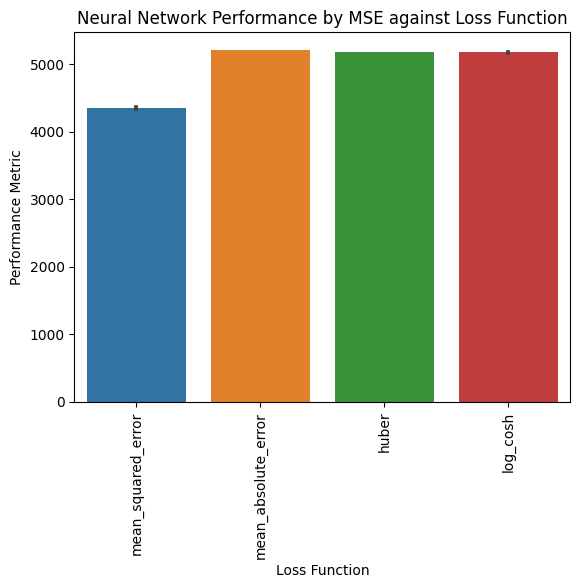

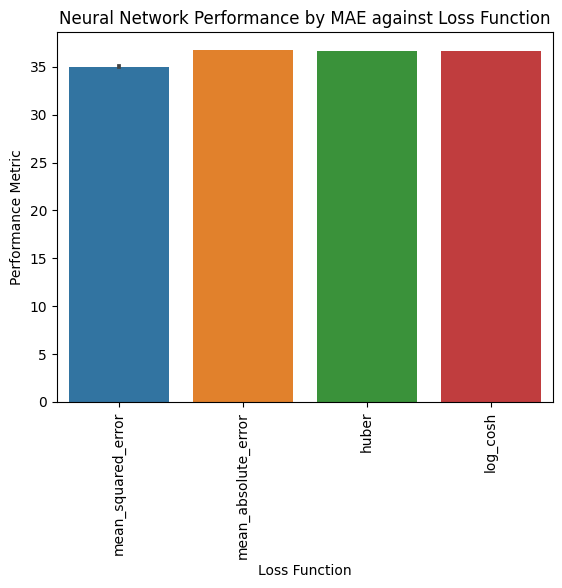

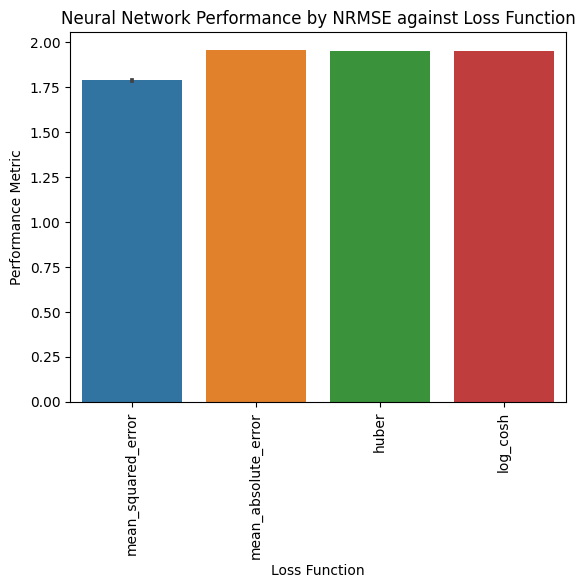

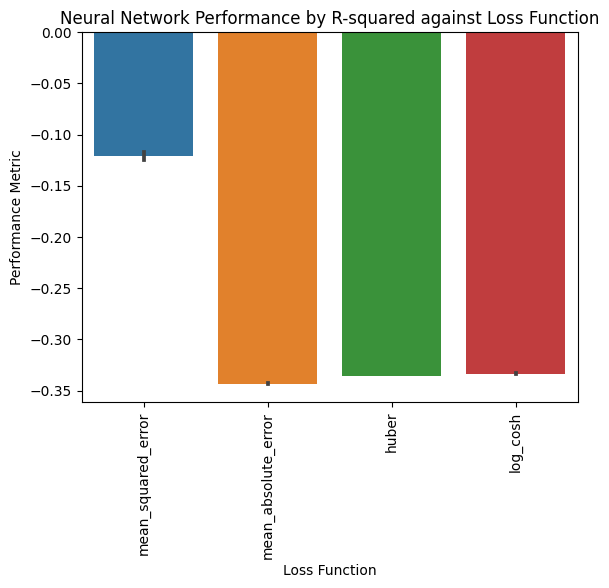

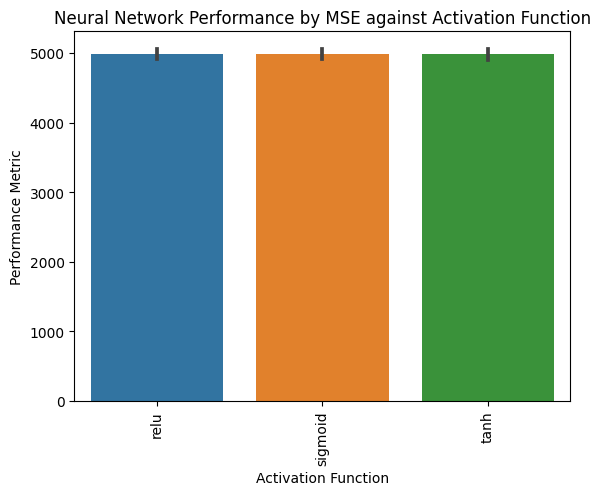

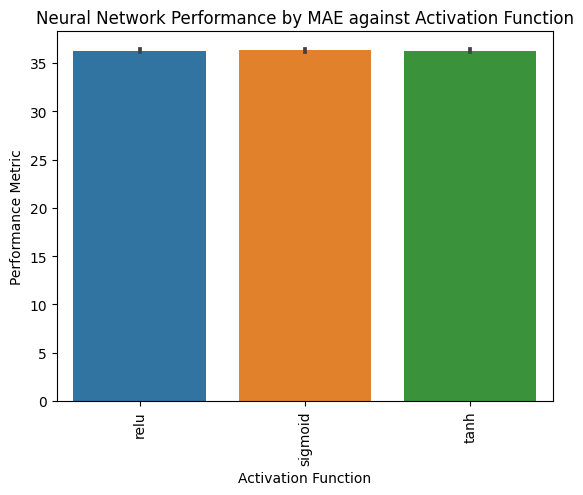

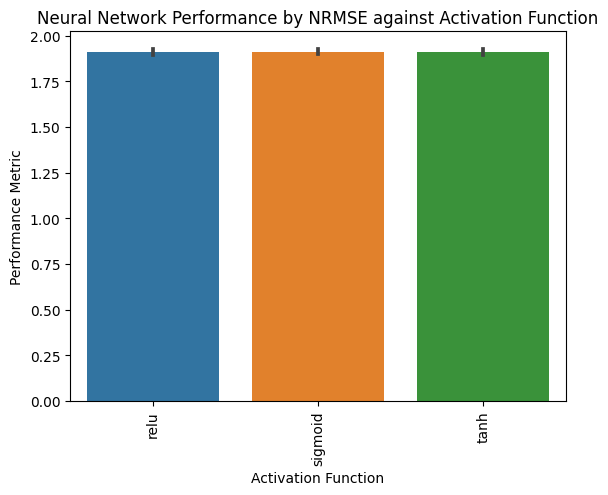

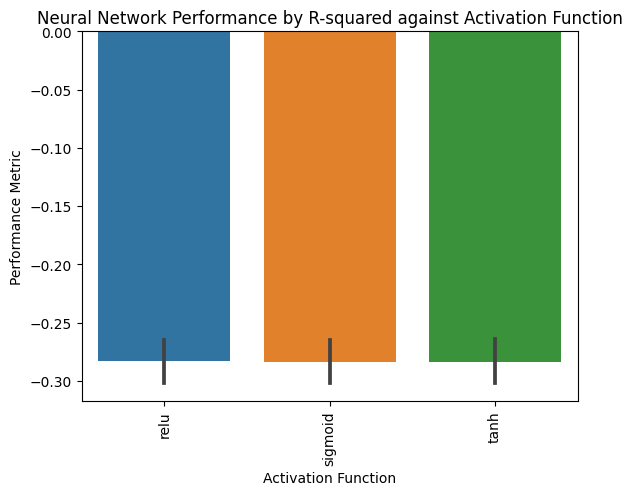

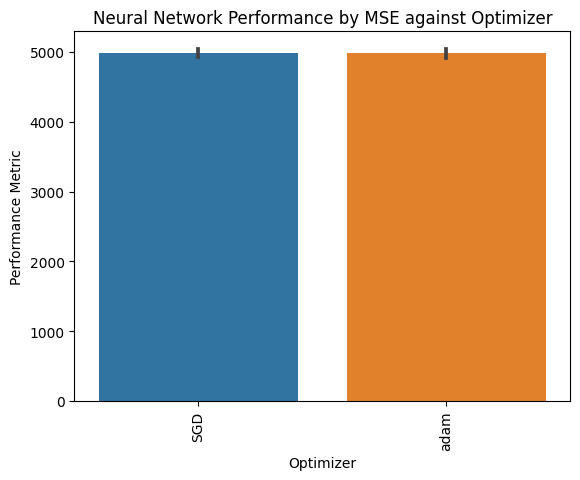

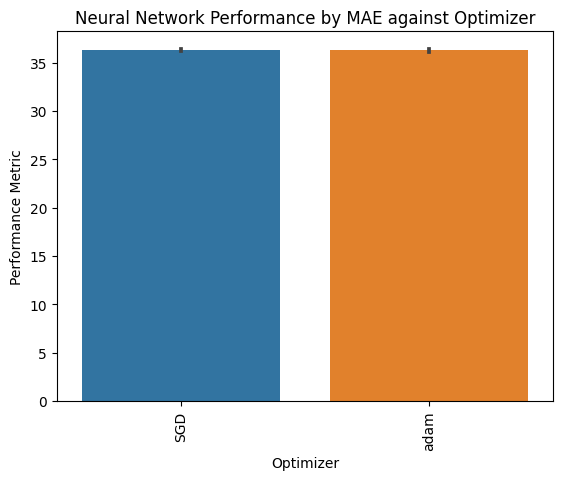

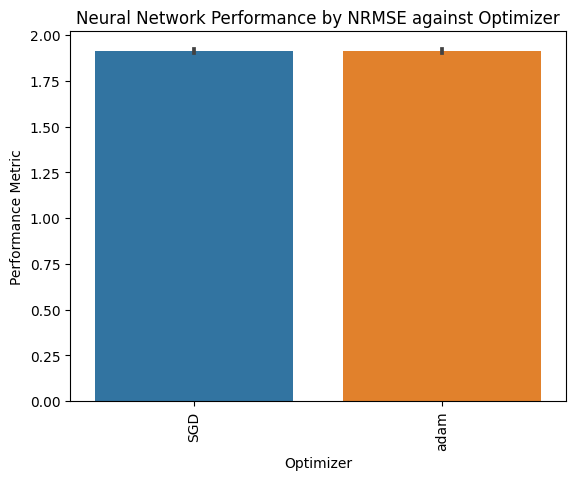

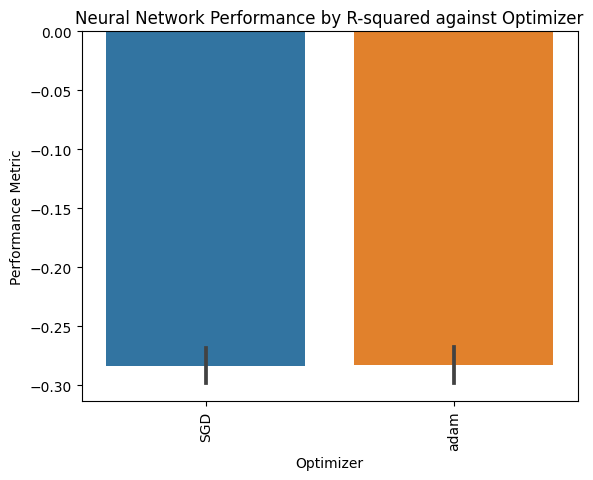

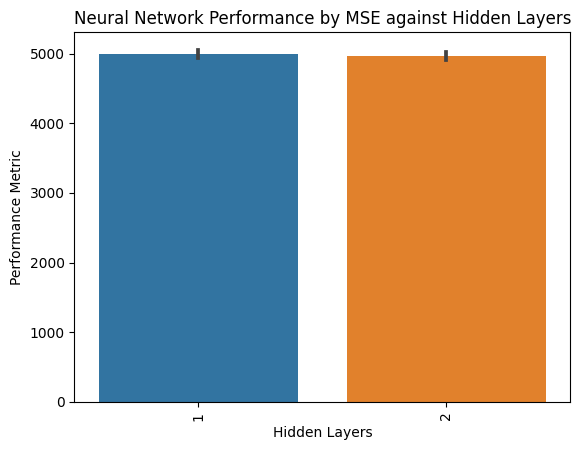

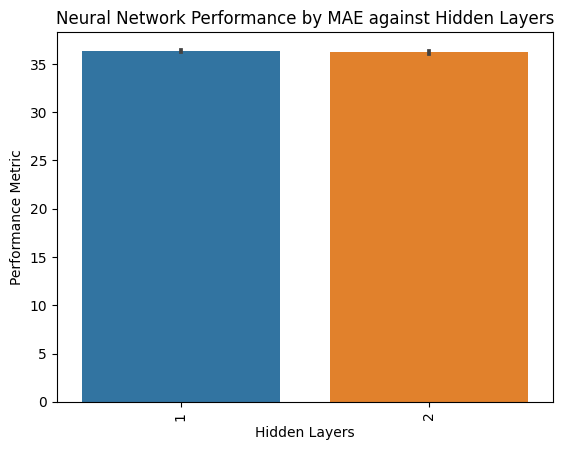

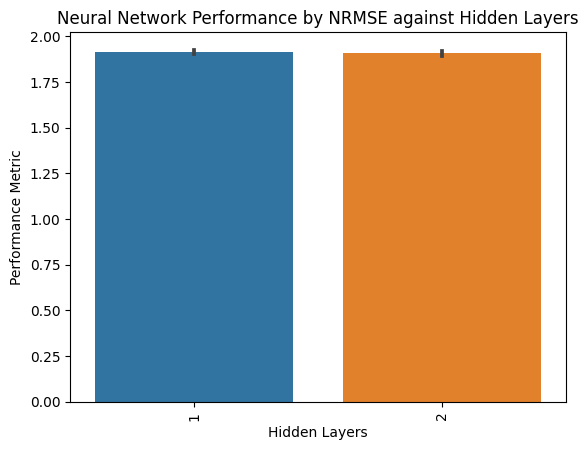

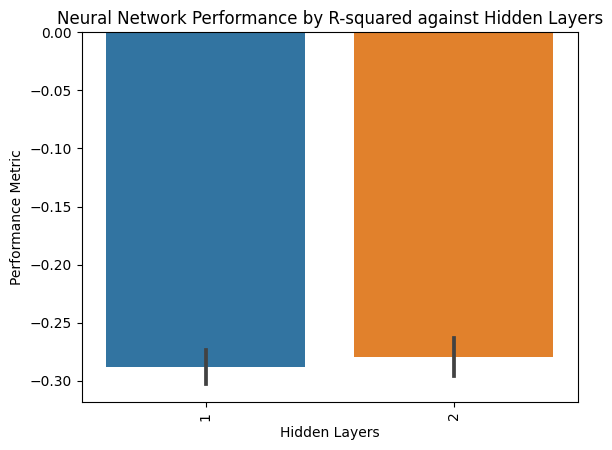

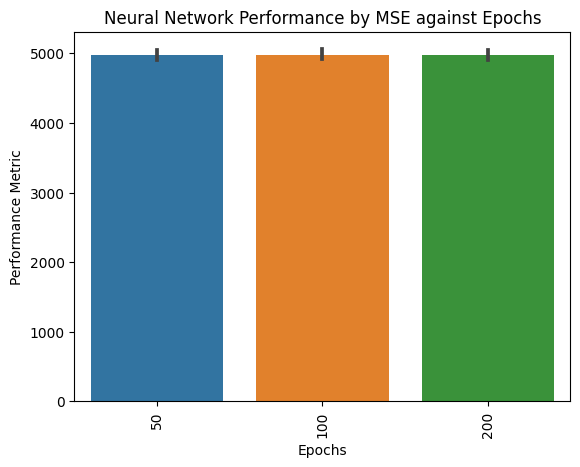

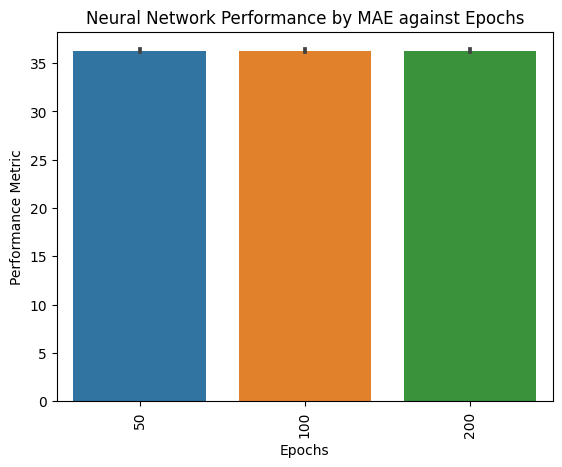

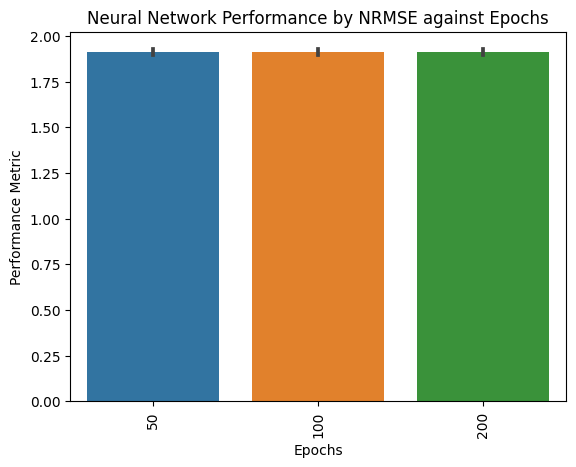

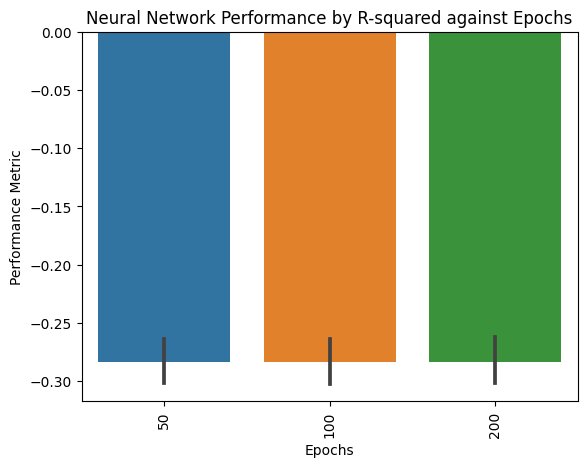

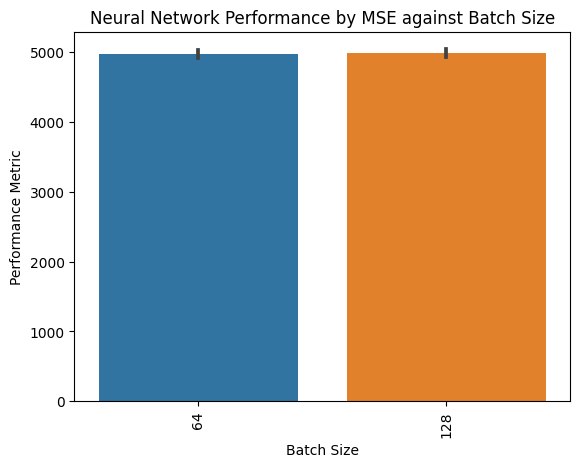

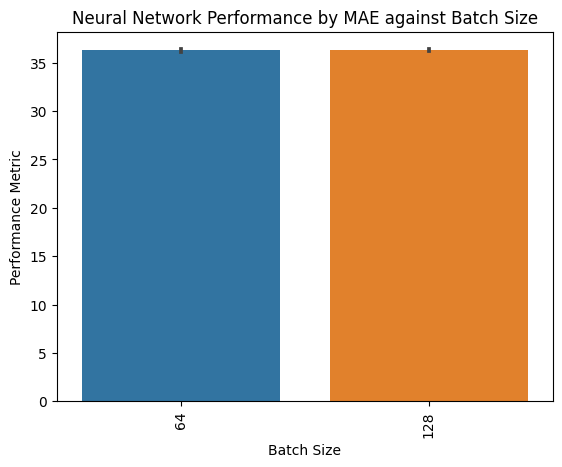

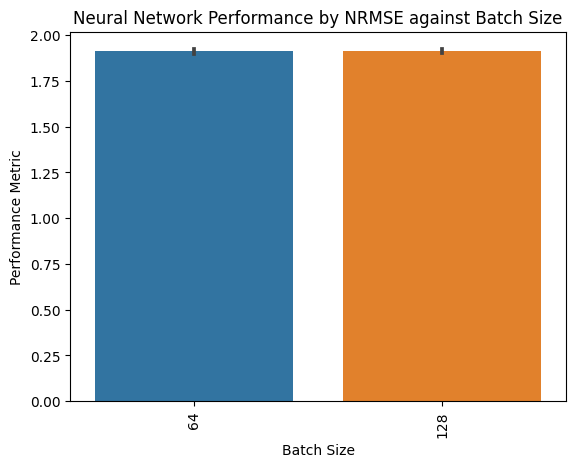

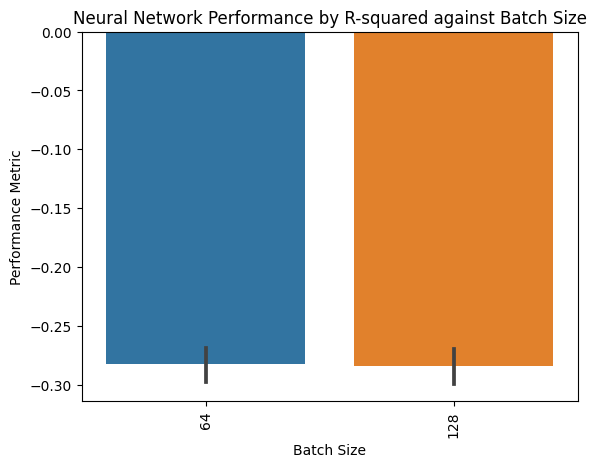

In [32]:
y_metrics = ["MSE", "MAE", "NRMSE", "R-squared"]
x_metrics = ["Loss Function", "Activation Function", "Optimizer", "Hidden Layers", "Epochs", "Batch Size"]

nn_results_total_days_df = nn_results_df[nn_results_df["Target"] == "Total Days"]

for x_metric in x_metrics:
    for y_metric in y_metrics:
        create_nn_performance_chart(nn_results_total_days_df, x_metric, y_metric)

In [33]:
print_overall_nn_min_stats(nn_results_total_days_df, 'Neural Network Total Days Performance')

Neural Network Total Days Performance
Model                         0
Target                        0
Loss Function               144
Activation Function           0
Optimizer                     0
Hidden Layers                 0
Epochs                        0
Batch Size                    0
Neurons per hidden layer      0
MSE                          18
MAE                          20
NRMSE                        18
R-squared                   101
dtype: int64 



In [34]:
nn_results_total_days_df.loc[[18]]

Model      Target       Loss Function Activation Function  \
18  Neural Network  Total Days  mean_squared_error                relu   

   Optimizer  Hidden Layers  Epochs  Batch Size  Neurons per hidden layer  \
18      adam              2      50          64                        32   

            MSE        MAE     NRMSE  R-squared  
18  4190.590948  34.573068  1.754547  -0.079856

In [35]:
def optimised_nn_total_days_model(df_X, df_y, X_test, y_test, target):
    # Create the model
    model = Sequential([
        Input(shape=(df_X.shape[1],)),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(df_X, df_y, epochs=50, batch_size=64, verbose=0)
    model.save('nn_total_days_model.keras')

    # Evaluate on validation set (optional)
    val_loss = model.evaluate(df_X, df_y, verbose=0)
    print(f"Training Loss: {val_loss}")

    # Evaluate on test set
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test[target], y_pred)
    mae = mean_absolute_error(y_test[target], y_pred)
    nrmse = normalized_root_mean_squared_error(y_test[target], y_pred)
    r2 = r2_score(y_test[target], y_pred)

    # Print performance metrics
    print(f"Neural Network Performance for {target}:")
    print("MSE:", mse)
    print("MAE:", mae)
    print("NRMSE:", nrmse)
    print("R-squared:", r2, '\n')

    return mse, mae, nrmse, r2

mse, mae, nrmse, r2 = optimised_nn_total_days_model(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, 'Total Days')
add_evaluation_metrics('Neural Network', 'Total Days', mse, mae, nrmse, r2)

I0000 00:00:1724254596.426078     125 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Training Loss: 738.9609375
15/15 [==============================] - 0s 2ms/step
Neural Network Performance for Total Days:
MSE: 4394.682209978821
MAE: 35.16212248286001
NRMSE: 1.796764765049143
R-squared: -0.1324472216165975 



### Predicting Injury Rate

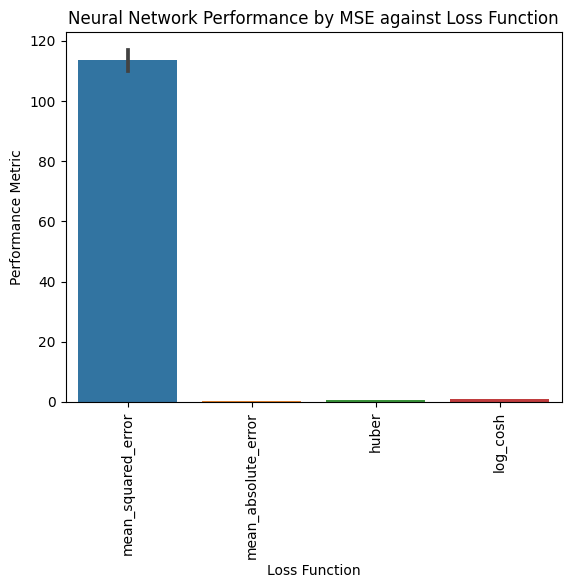

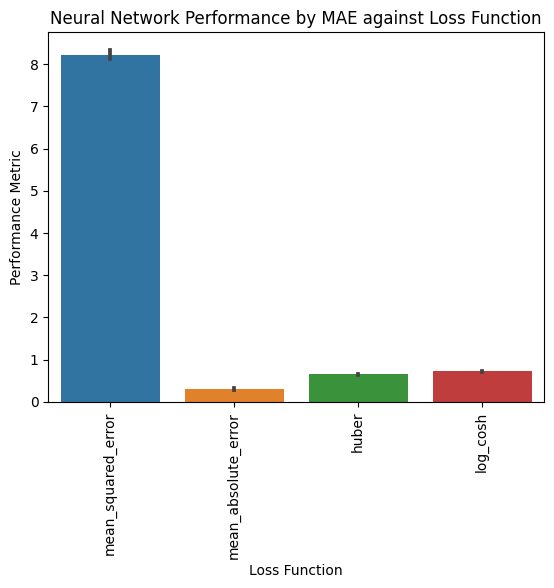

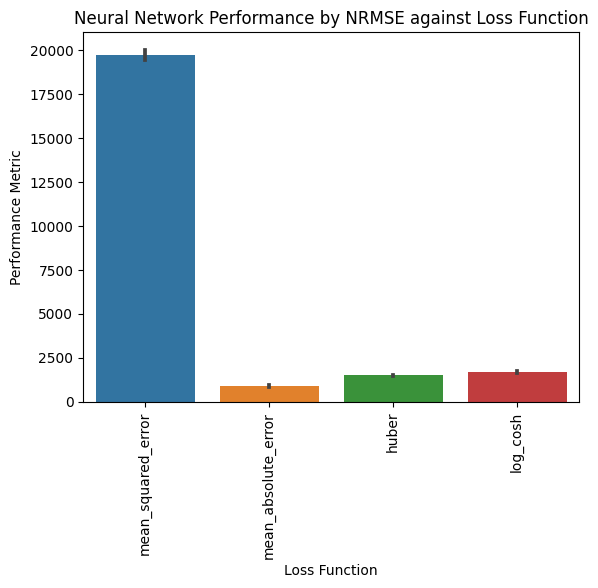

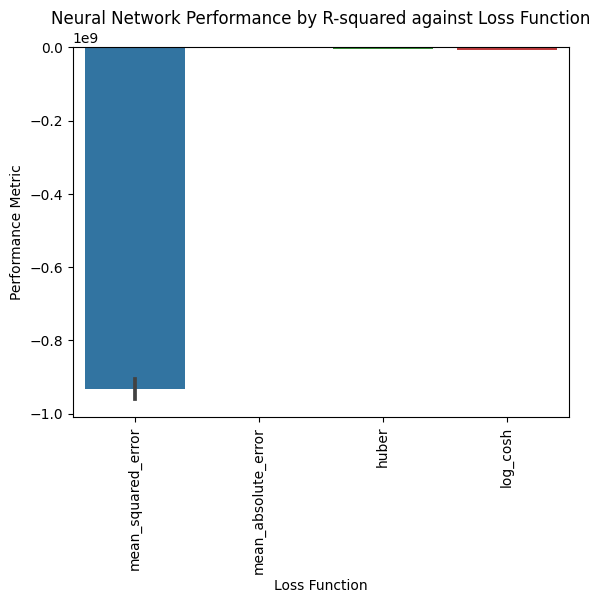

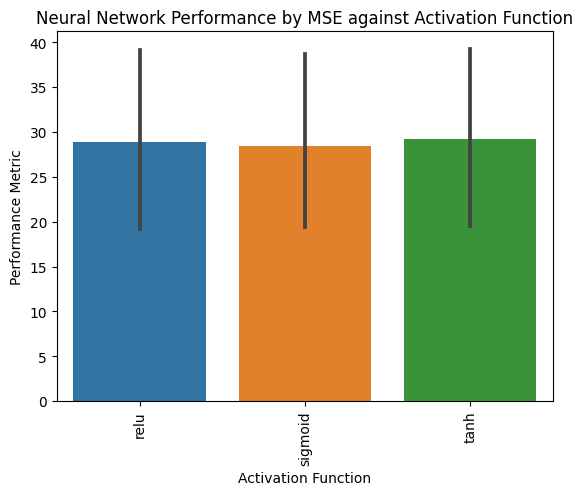

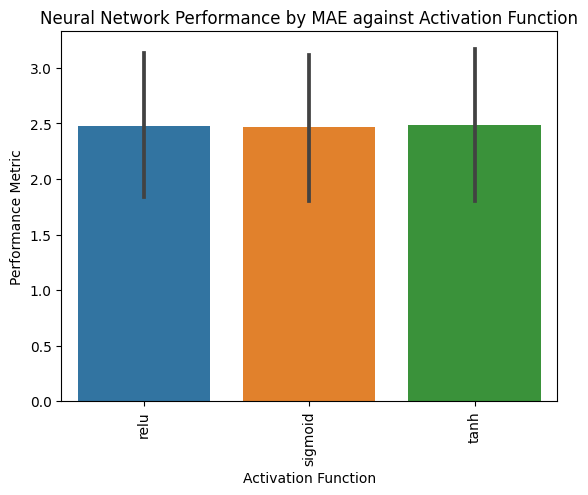

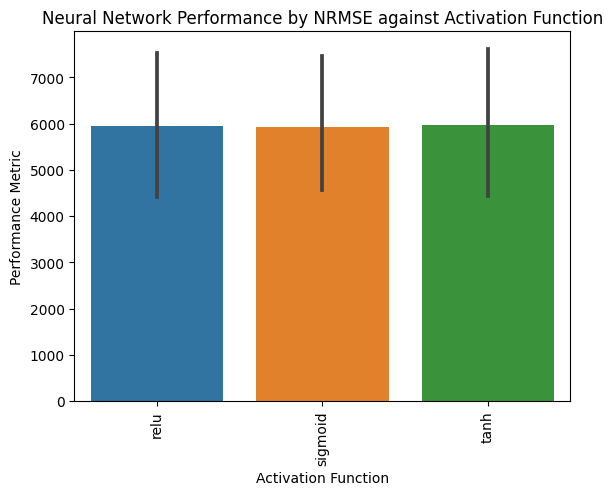

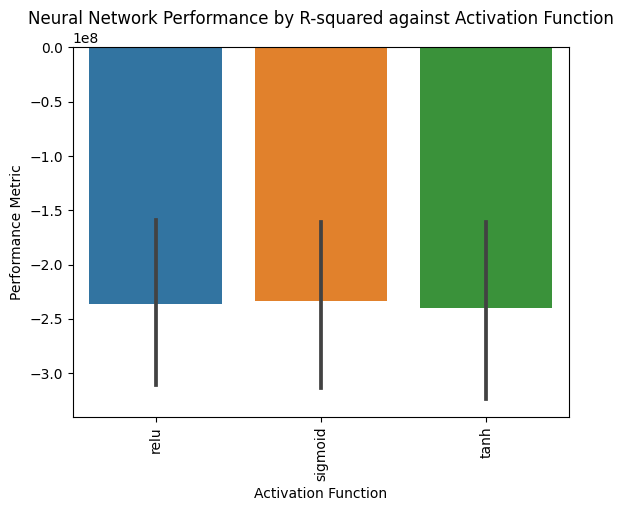

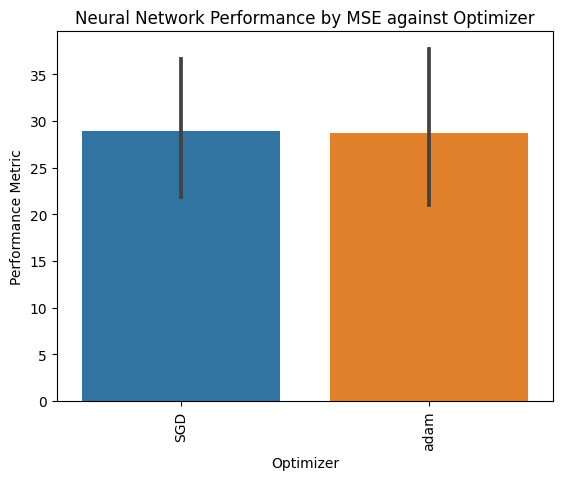

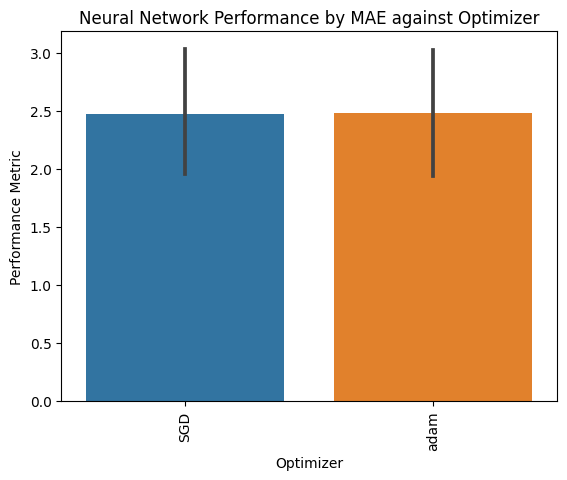

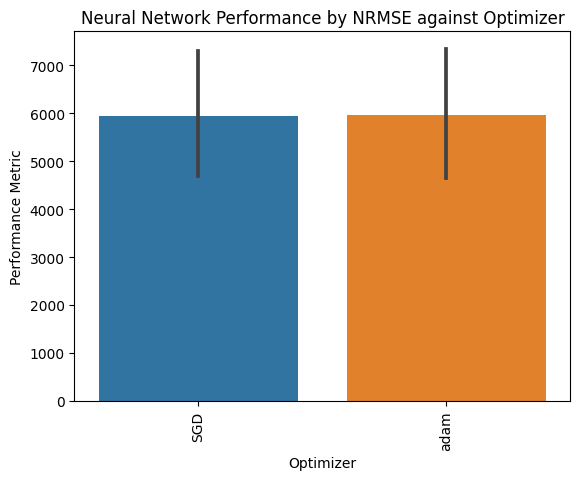

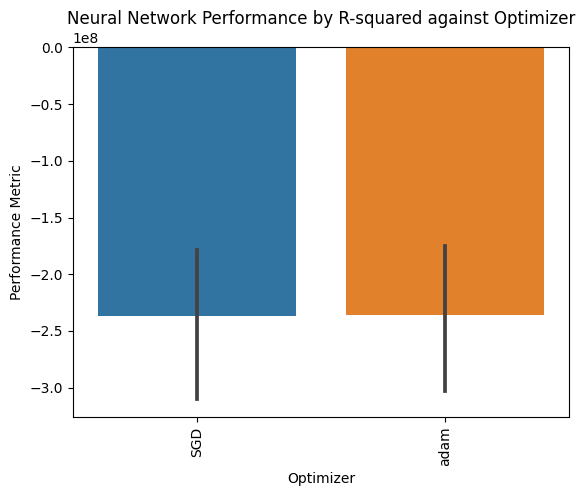

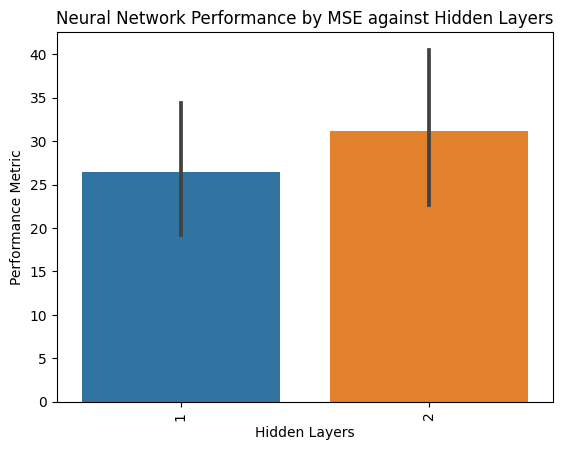

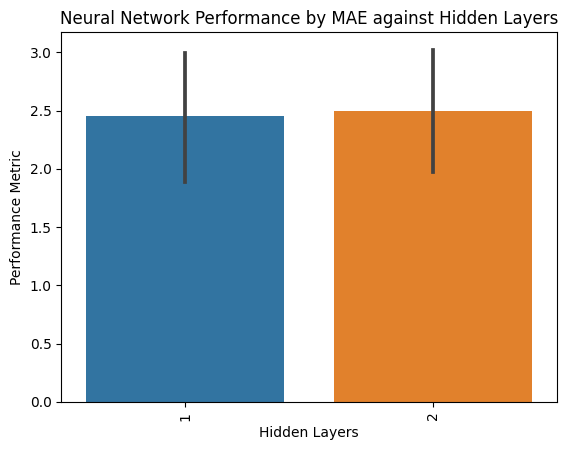

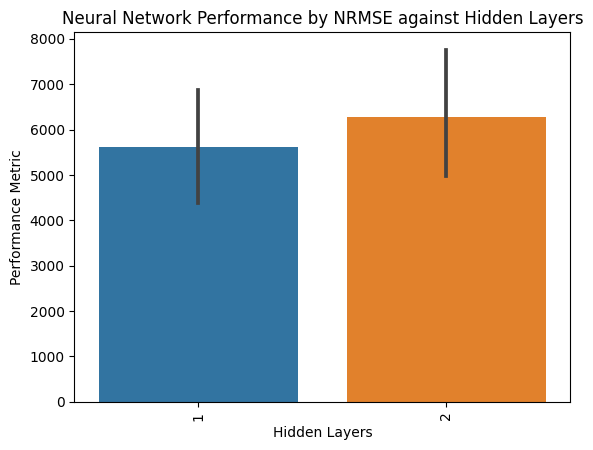

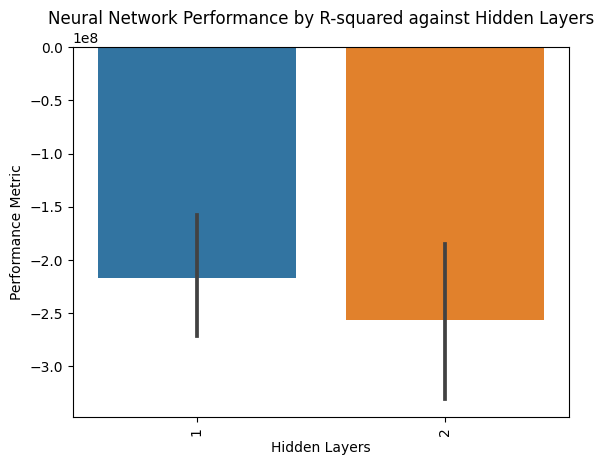

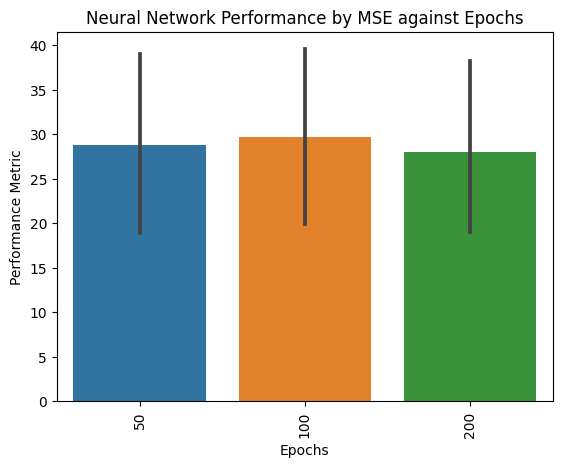

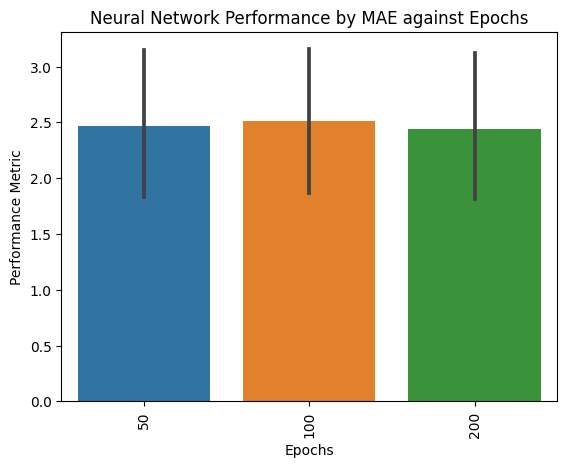

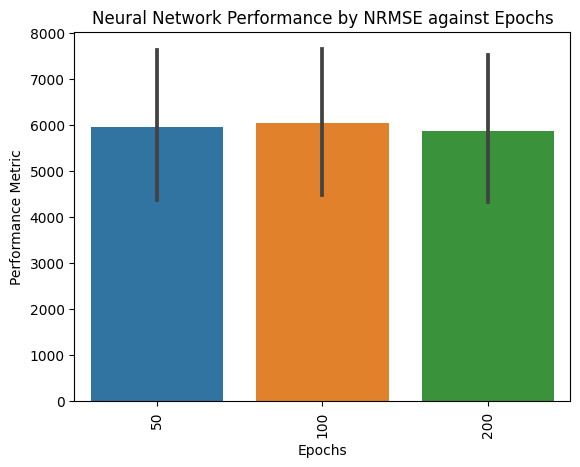

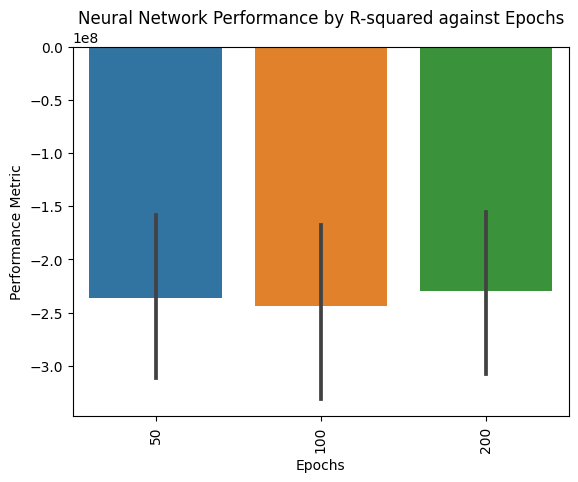

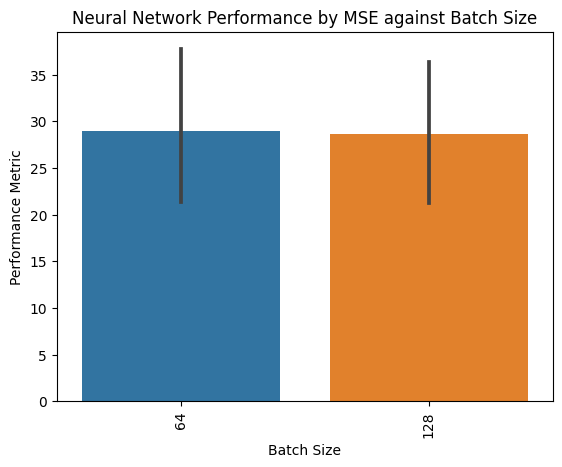

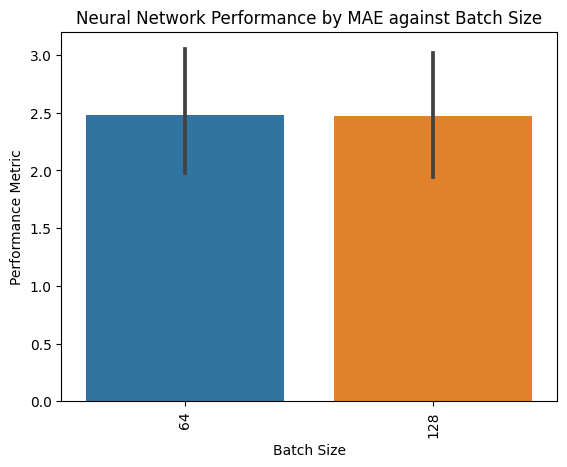

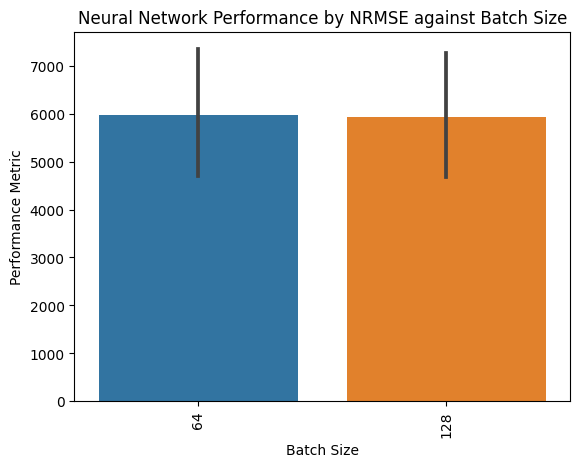

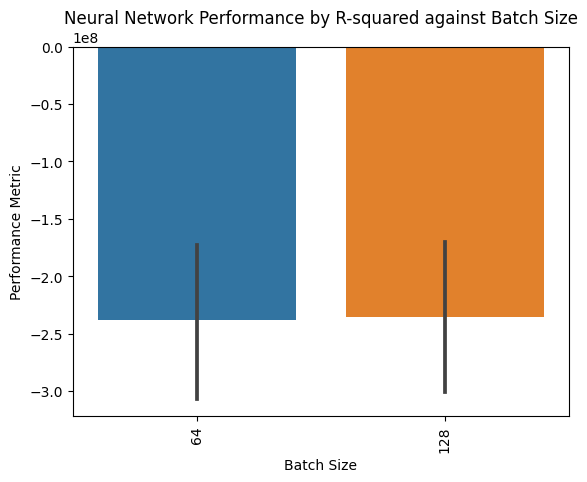

In [36]:
nn_results_injury_rate_df = nn_results_df[nn_results_df["Target"] == "Injury Rate"]

for x_metric in x_metrics:
    for y_metric in y_metrics:
        create_nn_performance_chart(nn_results_injury_rate_df, x_metric, y_metric)

In [37]:
print_overall_nn_min_stats(nn_results_injury_rate_df, 'Neural Network Injury Rate Performance')

Neural Network Injury Rate Performance
Model                       576
Target                      576
Loss Function               720
Activation Function         576
Optimizer                   576
Hidden Layers               576
Epochs                      576
Batch Size                  576
Neurons per hidden layer    576
MSE                         712
MAE                         712
NRMSE                       712
R-squared                   596
dtype: int64 



In [38]:
nn_results_df.iloc[[712]]

Model       Target        Loss Function Activation Function  \
712  Neural Network  Injury Rate  mean_absolute_error                tanh   

    Optimizer  Hidden Layers  Epochs  Batch Size  Neurons per hidden layer  \
712      adam              1     200          64                        32   

         MSE      MAE       NRMSE      R-squared  
712  0.08789  0.20258  549.445417 -721756.533595

In [39]:
def optimised_nn_injury_rate_model(df_X, df_y, X_test, y_test, target):
    # Create the model
    model = Sequential([
        Input(shape=(df_X.shape[1],)),
        Dense(32, activation='tanh'),
        Dense(1)
    ])

    model.compile(loss='mean_absolute_error', optimizer='adam')
    model.fit(df_X, df_y, epochs=200, batch_size=64, verbose=0)
    model.save('nn_injury_rate_model.keras')

    # Evaluate on validation set (optional)
    val_loss = model.evaluate(df_X, df_y, verbose=0)
    print(f"Training Loss: {val_loss}")

    # Evaluate on test set
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test[target], y_pred)
    mae = mean_absolute_error(y_test[target], y_pred)
    nrmse = normalized_root_mean_squared_error(y_test[target], y_pred)
    r2 = r2_score(y_test[target], y_pred)

    # Print performance metrics
    print(f"Neural Network Performance for {target}:")
    print("MSE:", mse)
    print("MAE:", mae)
    print("NRMSE:", nrmse)
    print("R-squared:", r2, '\n')

    return mse, mae, nrmse, r2

mse, mae, nrmse, r2 = optimised_nn_injury_rate_model(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, 'Injury Rate')
add_evaluation_metrics('Neural Network', 'Injury Rate', mse, mae, nrmse, r2)

Training Loss: 8.046121597290039
15/15 [==============================] - 0s 2ms/step
Neural Network Performance for Injury Rate:
MSE: 0.061364850874540945
MAE: 0.16707799433007867
NRMSE: 459.1081355815878
R-squared: -503931.29672419146 



### Predicting average injury cost

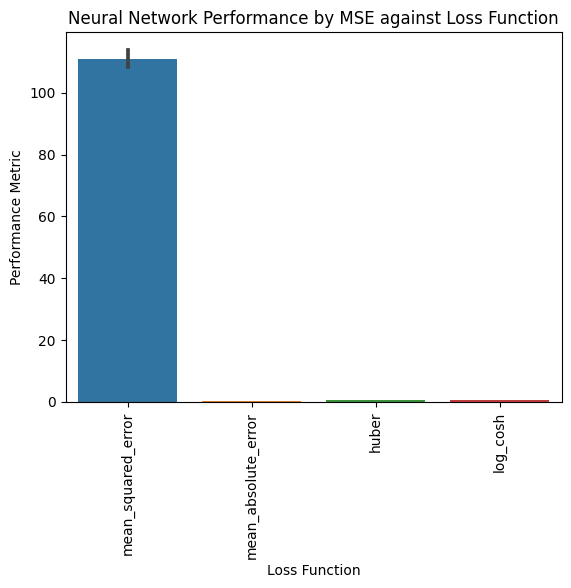

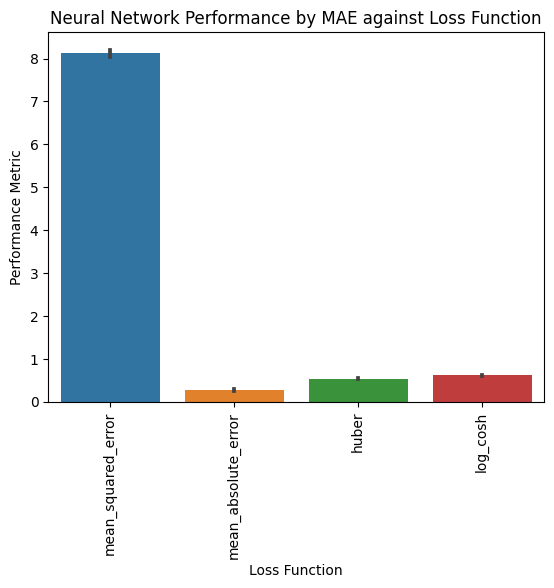

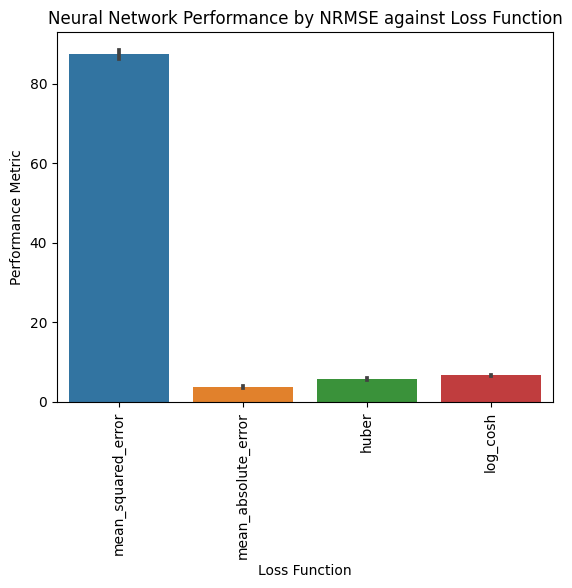

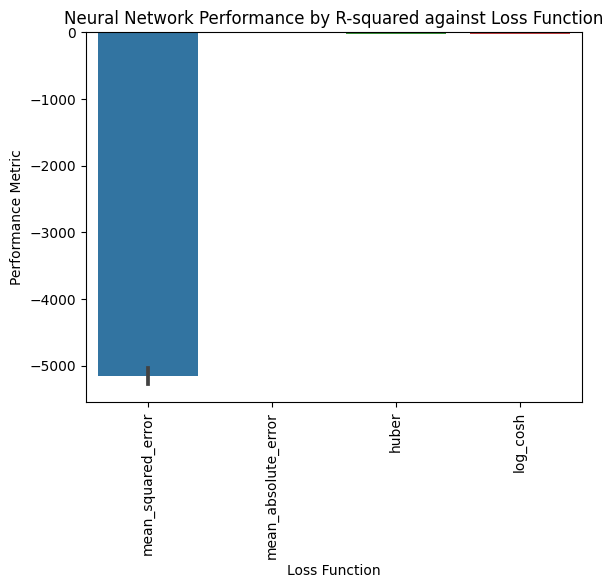

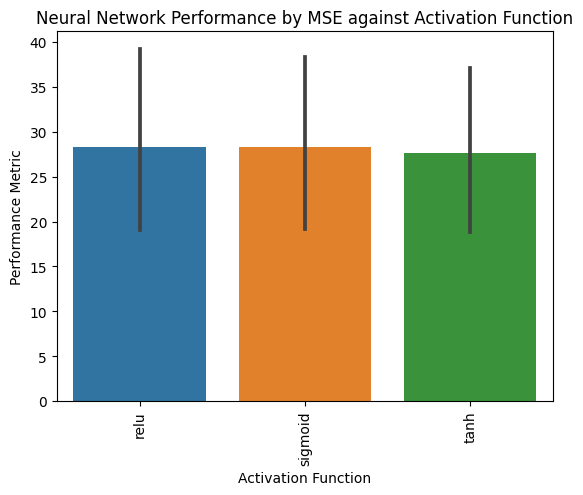

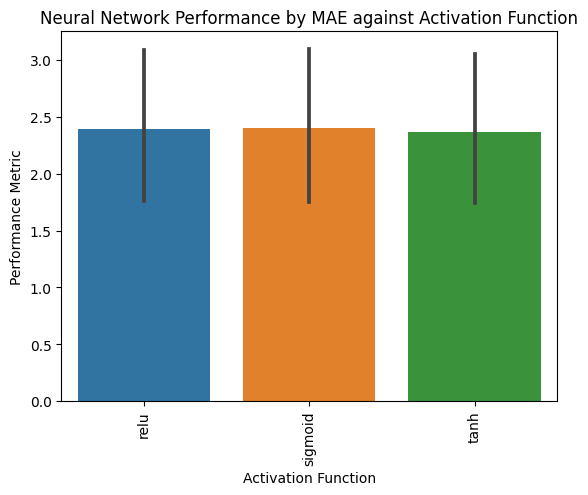

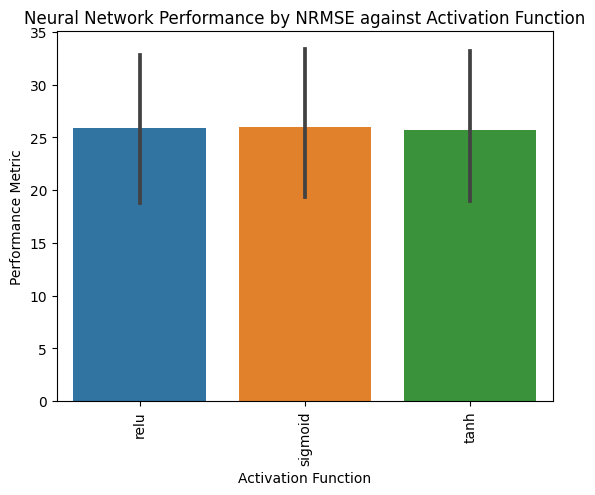

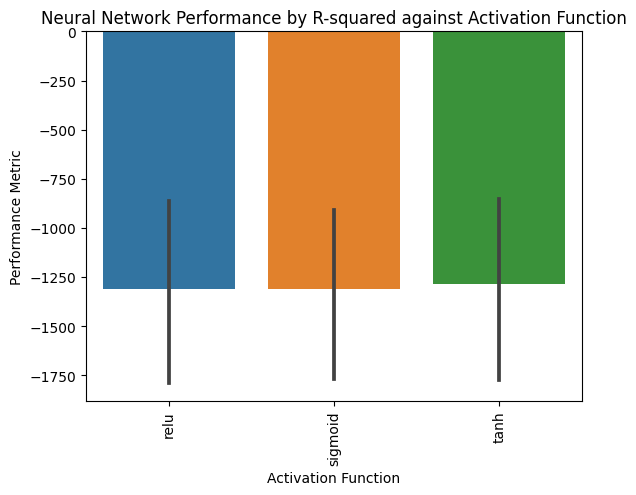

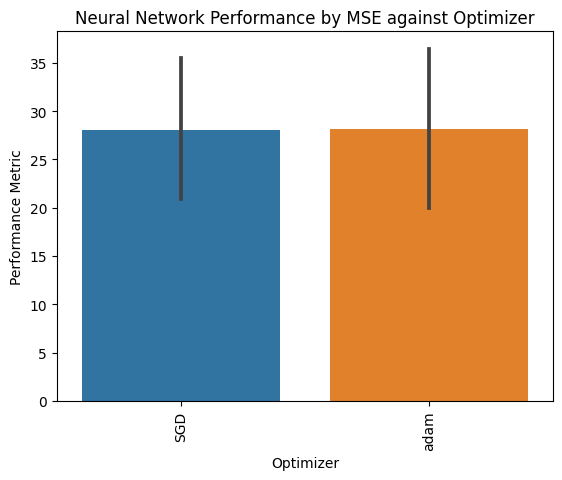

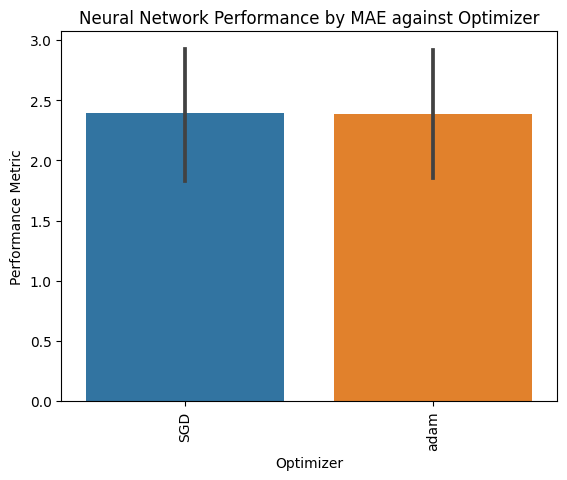

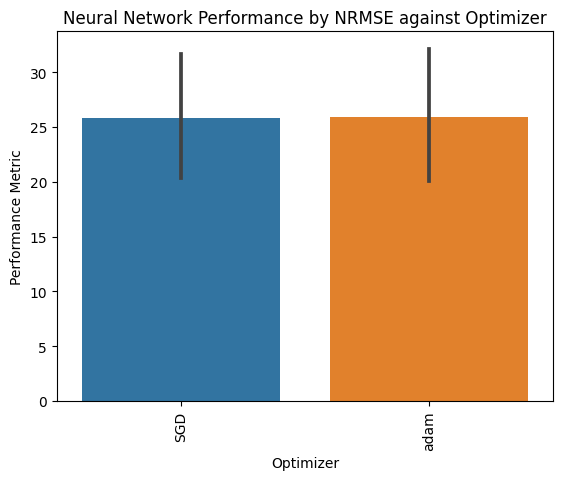

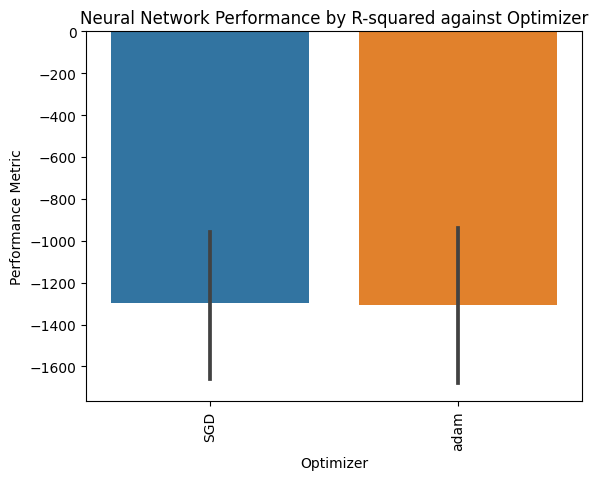

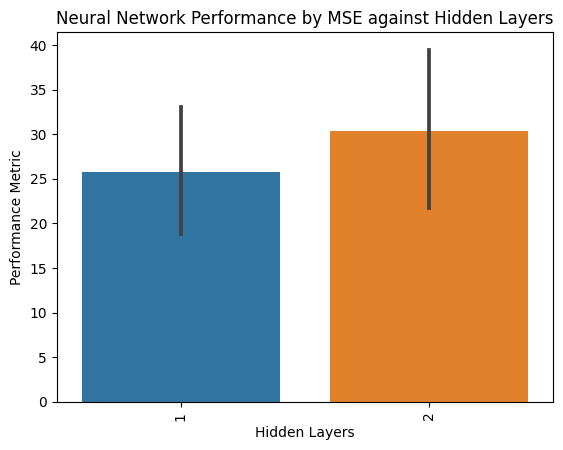

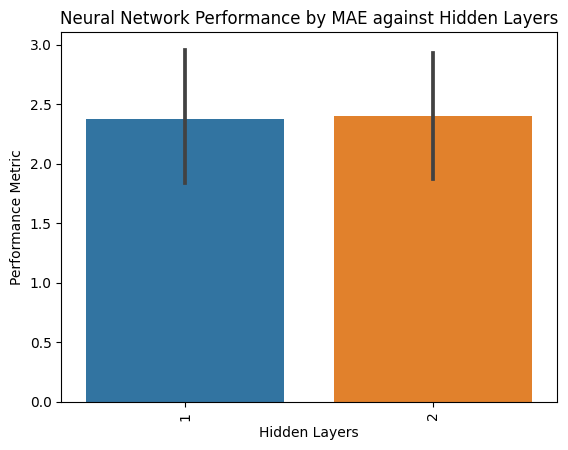

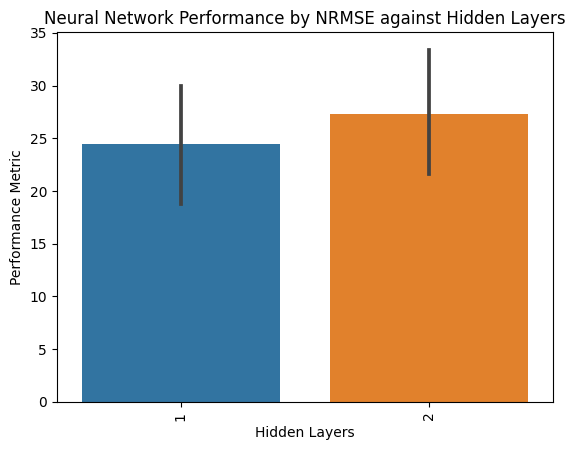

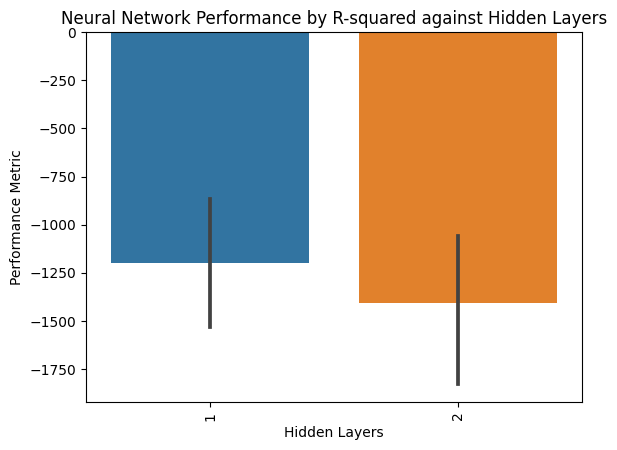

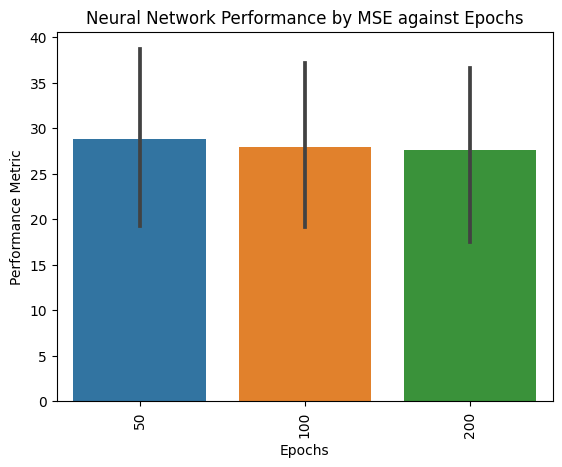

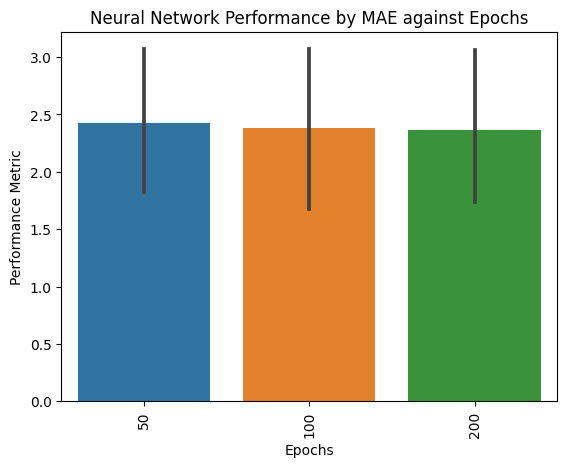

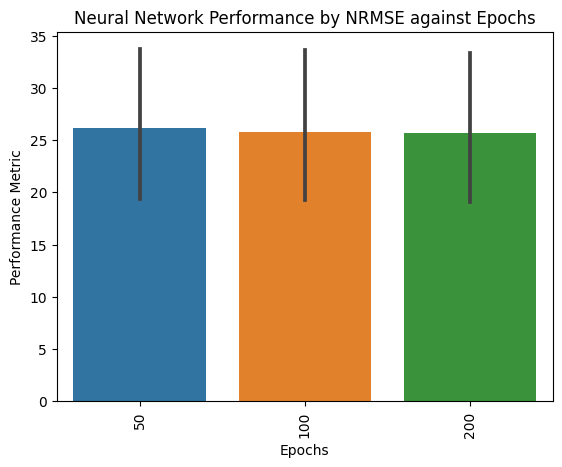

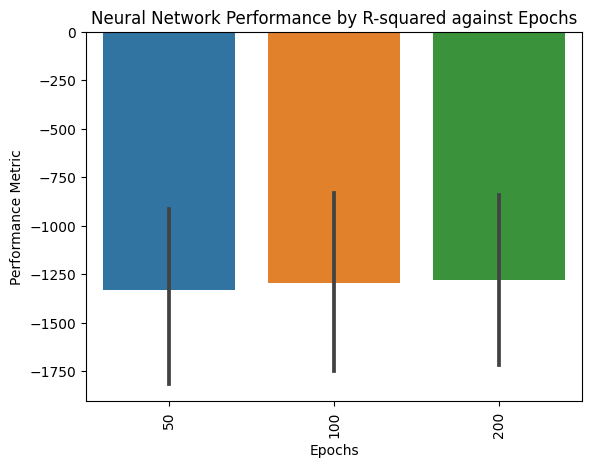

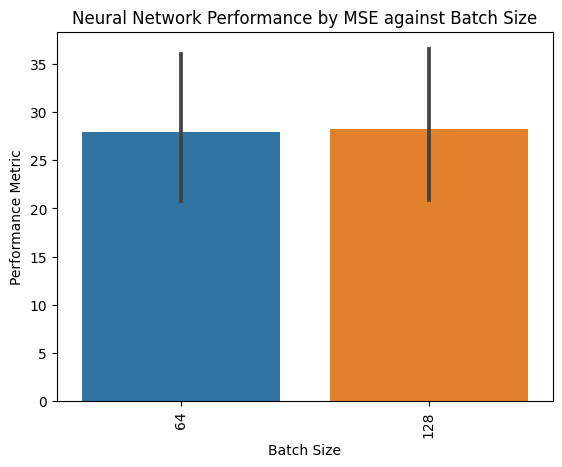

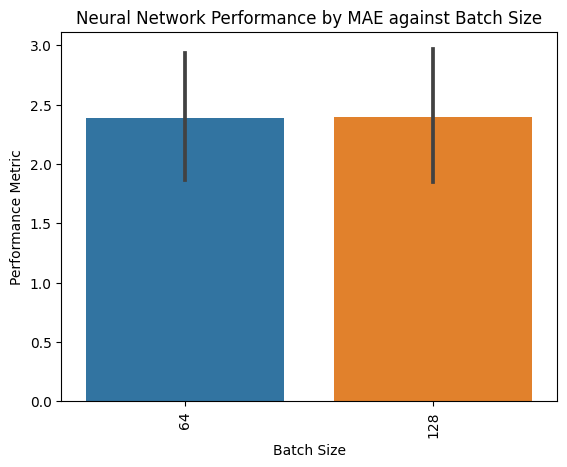

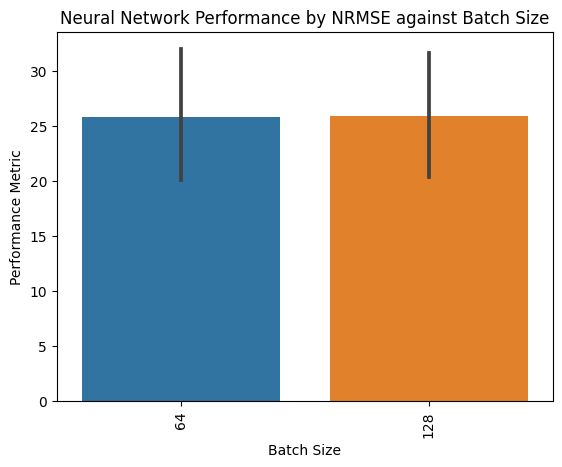

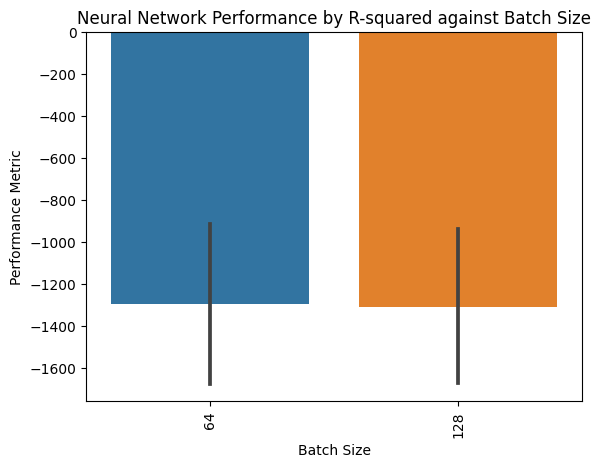

In [40]:
nn_results_avg_injury_cost_df = nn_results_df[nn_results_df["Target"] == "Average Injury Cost"]

for x_metric in x_metrics:
    for y_metric in y_metrics:
        create_nn_performance_chart(nn_results_avg_injury_cost_df, x_metric, y_metric)

In [41]:
print_overall_nn_min_stats(nn_results_avg_injury_cost_df, 'Neural Network Average Injury Cost Performance')

Neural Network Average Injury Cost Performance
Model                       288
Target                      288
Loss Function               432
Activation Function         288
Optimizer                   288
Hidden Layers               288
Epochs                      288
Batch Size                  288
Neurons per hidden layer    288
MSE                         424
MAE                         397
NRMSE                       424
R-squared                   320
dtype: int64 



In [42]:
nn_results_df.iloc[[424]]

Model               Target        Loss Function  \
424  Neural Network  Average Injury Cost  mean_absolute_error   

    Activation Function Optimizer  Hidden Layers  Epochs  Batch Size  \
424                tanh      adam              1     200          64   

     Neurons per hidden layer       MSE       MAE     NRMSE  R-squared  
424                        32  0.069568  0.182621  2.191213  -2.229842

In [43]:
def optimised_nn_avg_injury_cost_model(df_X, df_y, X_test, y_test, target):
    # Create the model
    model = Sequential([
        Input(shape=(df_X.shape[1],)),
        Dense(32, activation='tanh'),
        Dense(1)
    ])

    model.compile(loss='mean_absolute_error', optimizer='adam')
    model.fit(df_X, df_y, epochs=200, batch_size=64, verbose=0)
    model.save('nn_avg_injury_cost_model.keras')

    # Evaluate on validation set (optional)
    val_loss = model.evaluate(df_X, df_y, verbose=0)
    print(f"Training Loss: {val_loss}")

    # Evaluate on test set
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test[target], y_pred)
    mae = mean_absolute_error(y_test[target], y_pred)
    nrmse = normalized_root_mean_squared_error(y_test[target], y_pred)
    r2 = r2_score(y_test[target], y_pred)

    # Print performance metrics
    print(f"Neural Network Performance for {target}:")
    print("MSE:", mse)
    print("MAE:", mae)
    print("NRMSE:", nrmse)
    print("R-squared:", r2, '\n')

    return mse, mae, nrmse, r2

mse, mae, nrmse, r2 = optimised_nn_avg_injury_cost_model(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, 'Average Injury Cost')
add_evaluation_metrics('Neural Network', 'Average Injury Cost', mse, mae, nrmse, r2)

Training Loss: 8.046499252319336
15/15 [==============================] - 0s 2ms/step
Neural Network Performance for Average Injury Cost:
MSE: 0.04295902591169029
MAE: 0.14228925525815445
NRMSE: 1.7218987700110067
R-squared: -0.9944690710714708 



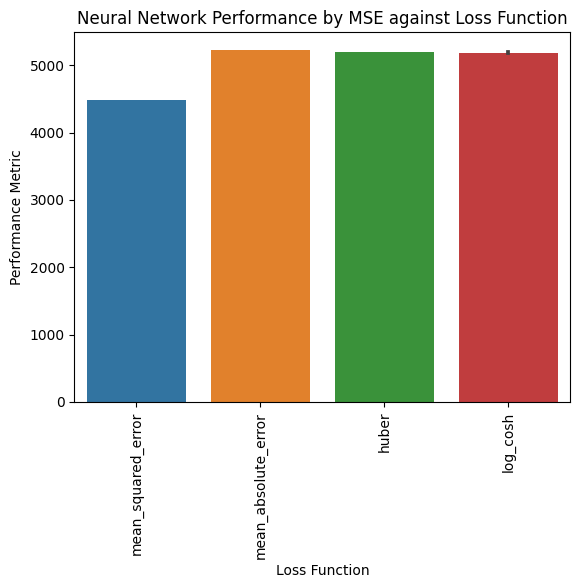

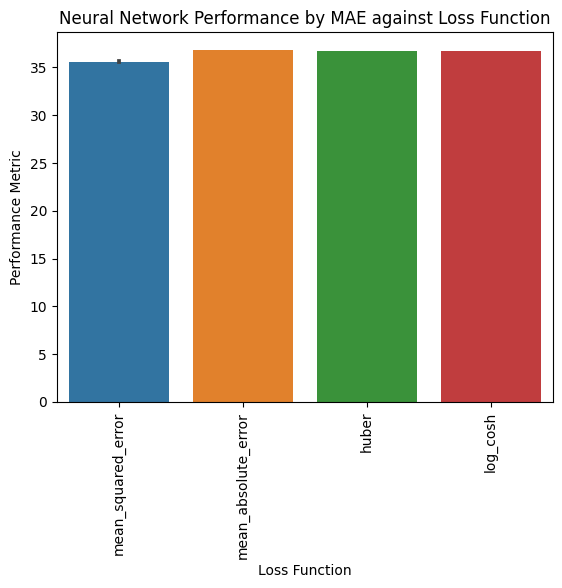

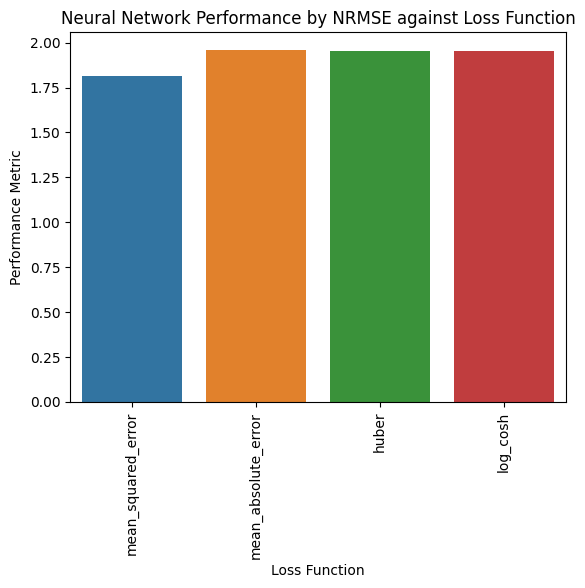

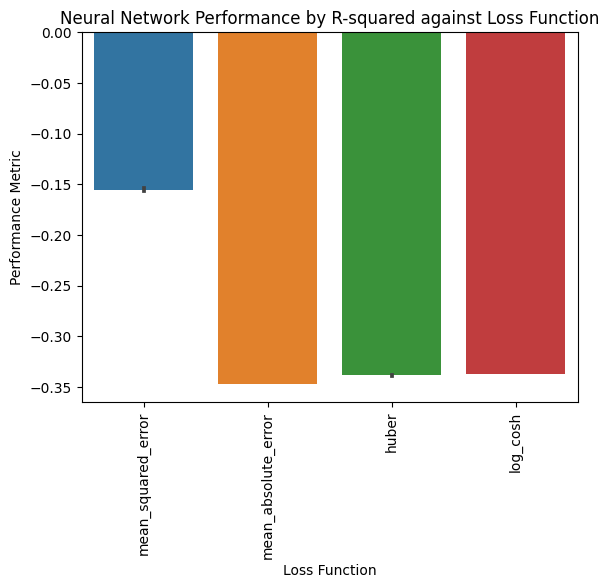

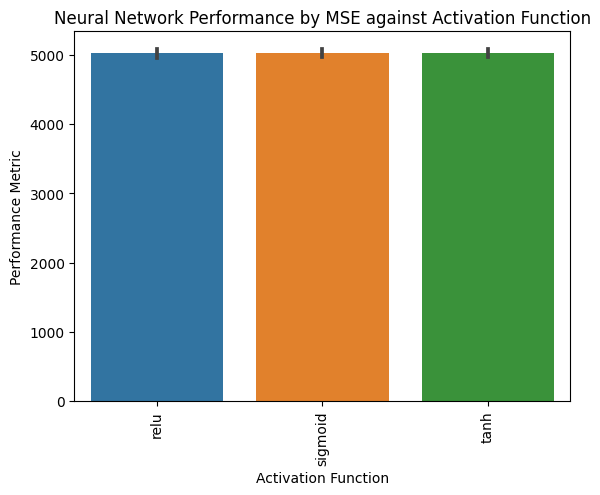

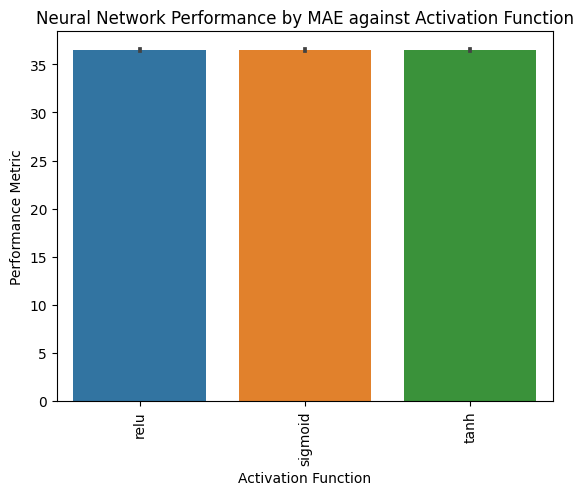

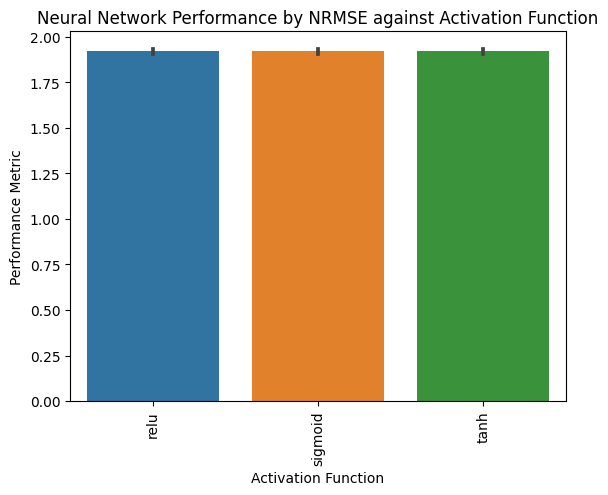

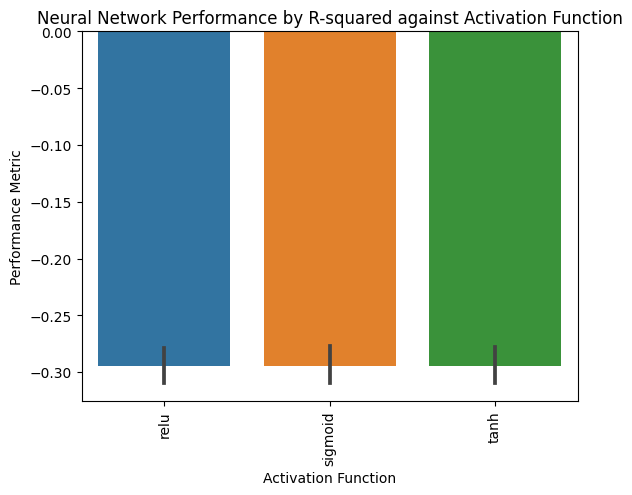

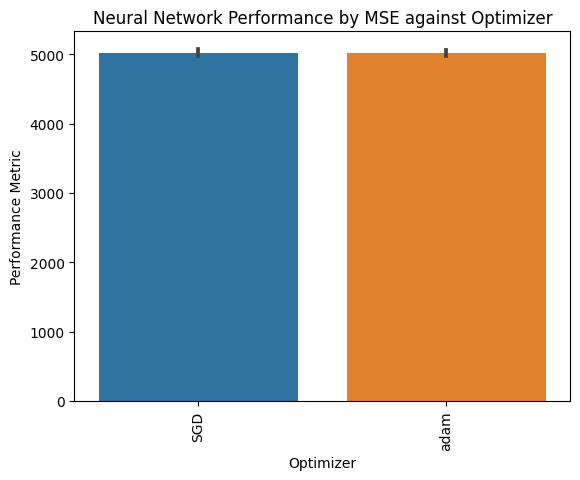

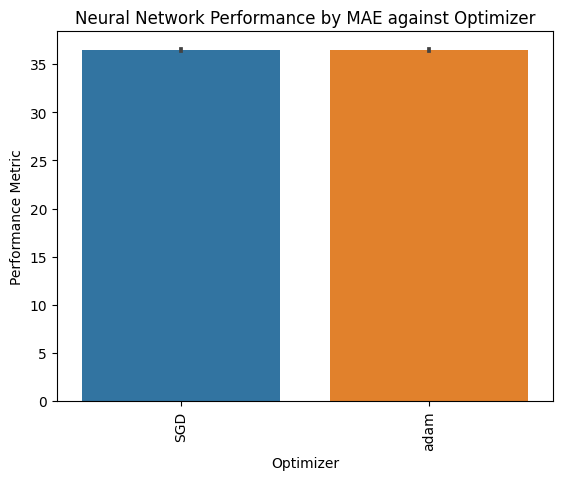

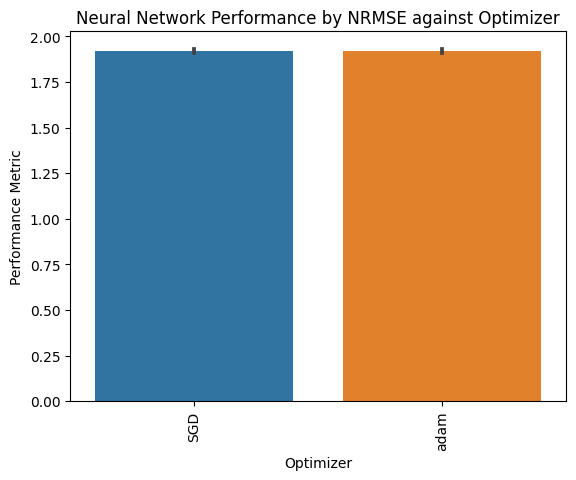

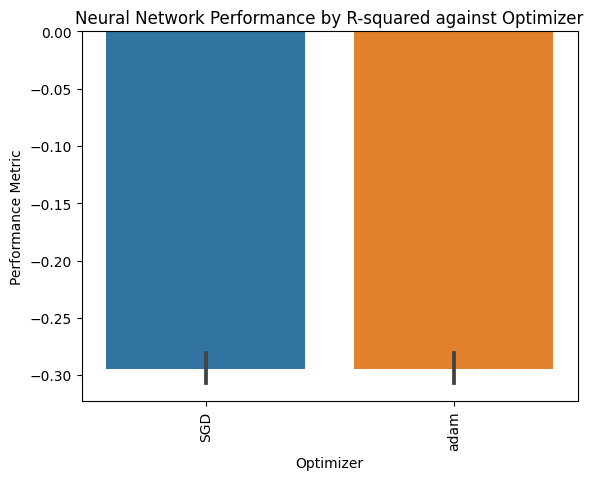

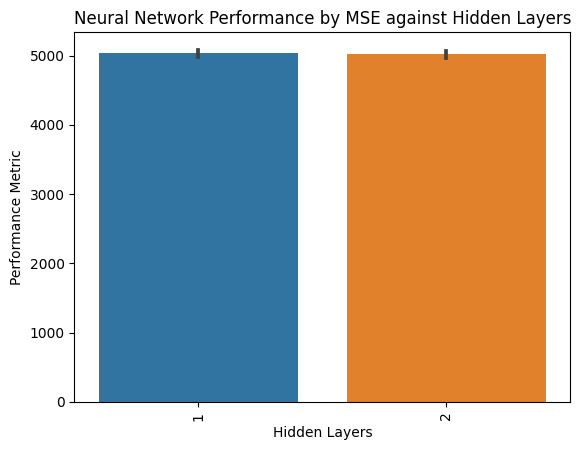

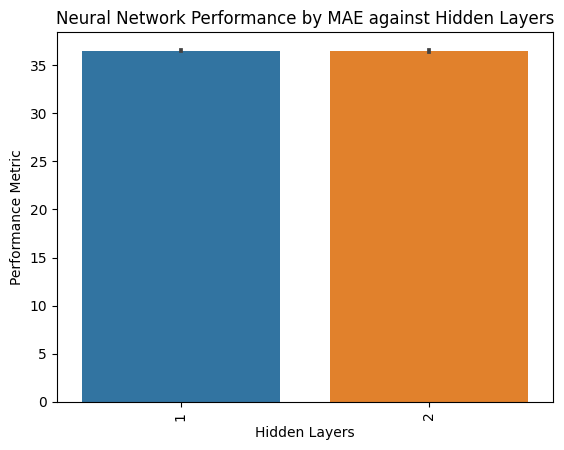

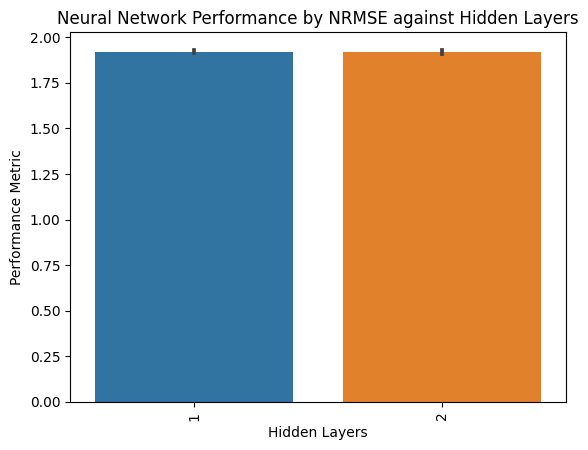

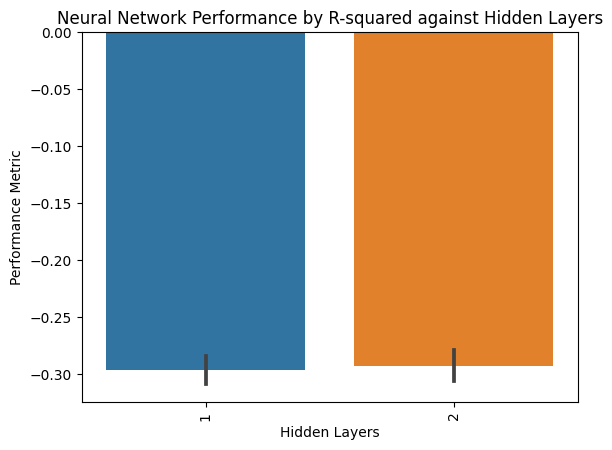

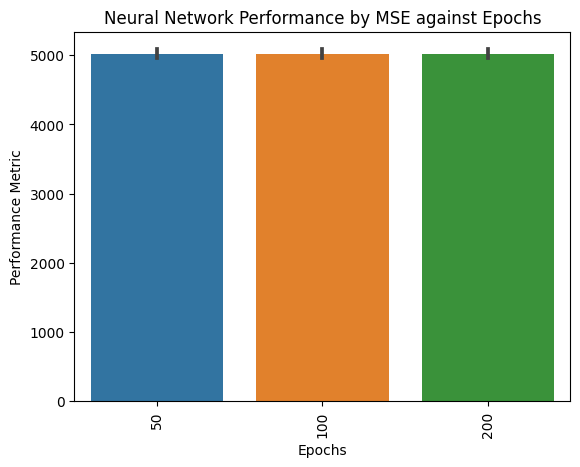

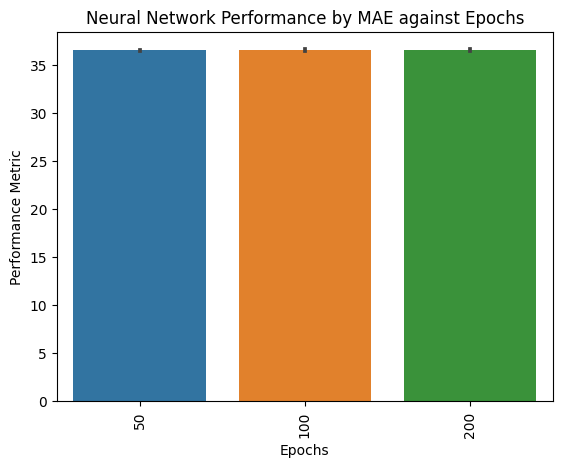

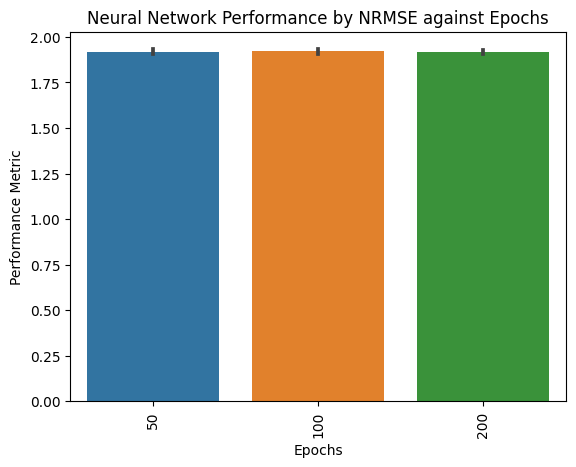

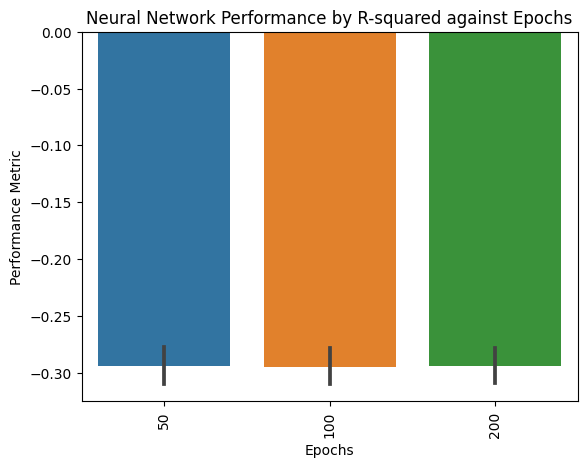

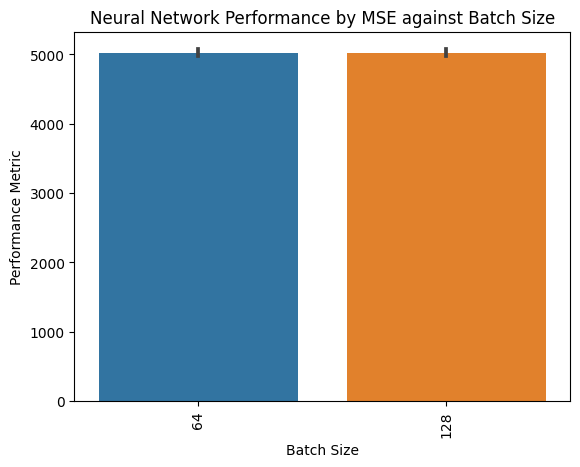

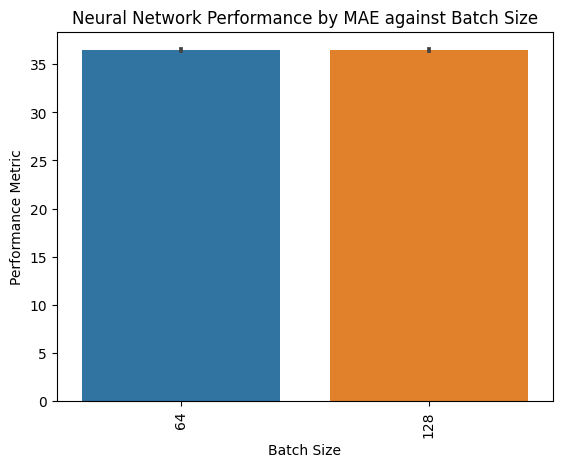

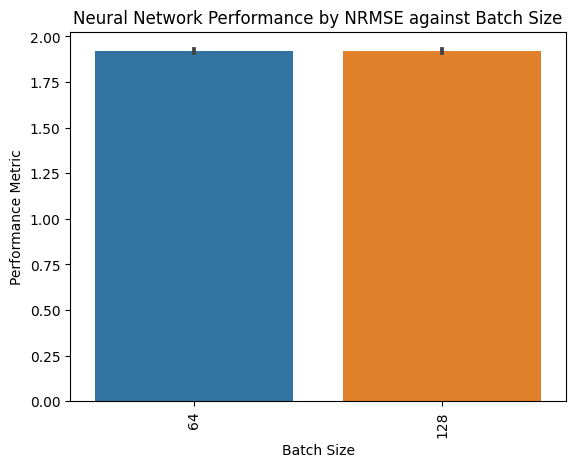

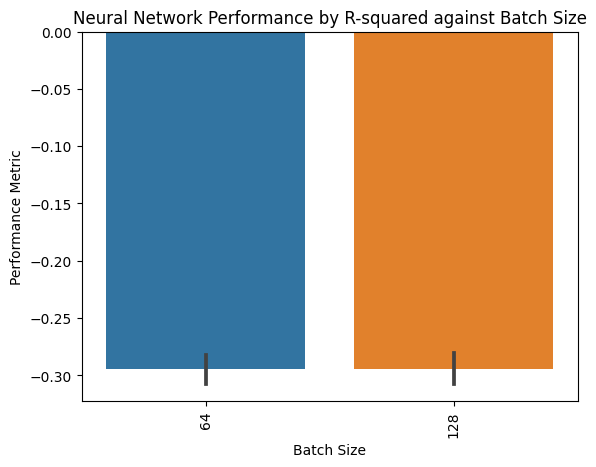

In [44]:
nn_pca13_results_total_days_df = nn_pca13_results_df[nn_pca13_results_df["Target"] == "Total Days"]

for x_metric in x_metrics:
    for y_metric in y_metrics:
        create_nn_performance_chart(nn_pca13_results_total_days_df, x_metric, y_metric)

In [45]:
print_overall_nn_min_stats(nn_pca13_results_total_days_df, 'Neural Network (PCA n = 13) Total Days Performance')

Neural Network (PCA n = 13) Total Days Performance
Model                         0
Target                        0
Loss Function               144
Activation Function           0
Optimizer                     0
Hidden Layers                 0
Epochs                        0
Batch Size                    0
Neurons per hidden layer      0
MSE                          19
MAE                          18
NRMSE                        19
R-squared                    86
dtype: int64 



In [46]:
nn_pca13_results_df.loc[[19]]

Model      Target       Loss Function  \
19  Neural Network (PCA n = 13)  Total Days  mean_squared_error   

   Activation Function Optimizer  Hidden Layers  Epochs  Batch Size  \
19                relu      adam              2      50         128   

    Neurons per hidden layer          MSE        MAE     NRMSE  R-squared  
19                        32  4437.225953  35.423043  1.805441   -0.14341

In [47]:
def optimised_nn_pca13_total_days_model(df_X, df_y, X_test, y_test, target):
    # Create the model
    model = Sequential([
        Input(shape=(df_X.shape[1],)),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(df_X, df_y, epochs=50, batch_size=128, verbose=0)
    model.save('nn_pca13_total_days_model.keras')

    # Evaluate on validation set (optional)
    val_loss = model.evaluate(df_X, df_y, verbose=0)
    print(f"Training Loss: {val_loss}")

    # Evaluate on test set
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test[target], y_pred)
    mae = mean_absolute_error(y_test[target], y_pred)
    nrmse = normalized_root_mean_squared_error(y_test[target], y_pred)
    r2 = r2_score(y_test[target], y_pred)

    # Print performance metrics
    print(f"Neural Network (PCA n = 13) Performance for {target}:")
    print("MSE:", mse)
    print("MAE:", mae)
    print("NRMSE:", nrmse)
    print("R-squared:", r2, '\n')

    return mse, mae, nrmse, r2

mse, mae, nrmse, r2 = optimised_nn_pca13_total_days_model(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, 'Total Days')
add_evaluation_metrics('Neural Network (PCA n = 13)', 'Total Days', mse, mae, nrmse, r2)

Training Loss: 746.1275634765625
15/15 [==============================] - 0s 2ms/step
Neural Network (PCA n = 13) Performance for Total Days:
MSE: 4416.037901103943
MAE: 35.209454947145154
NRMSE: 1.8011251088537372
R-squared: -0.13795028006879506 



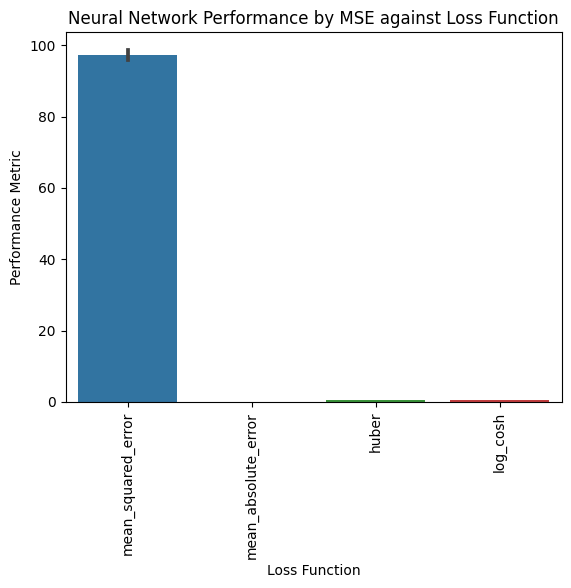

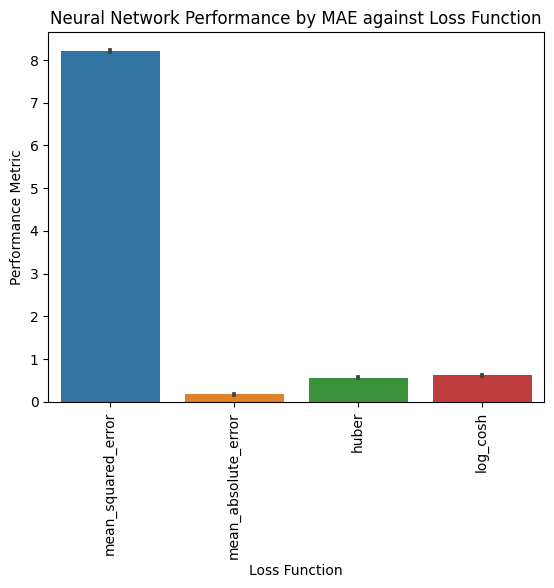

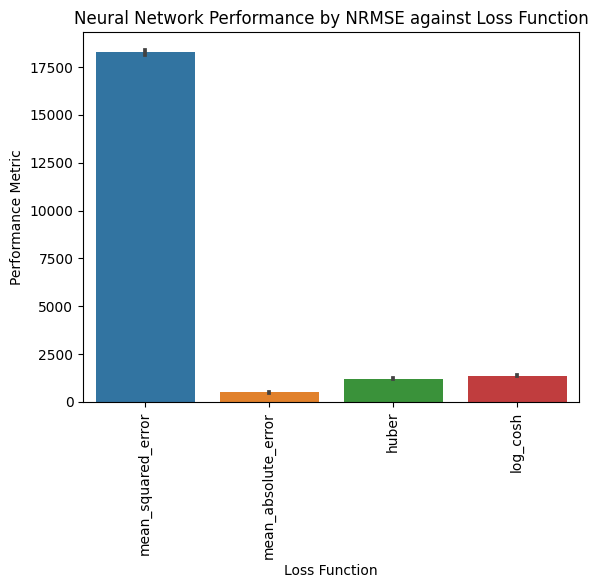

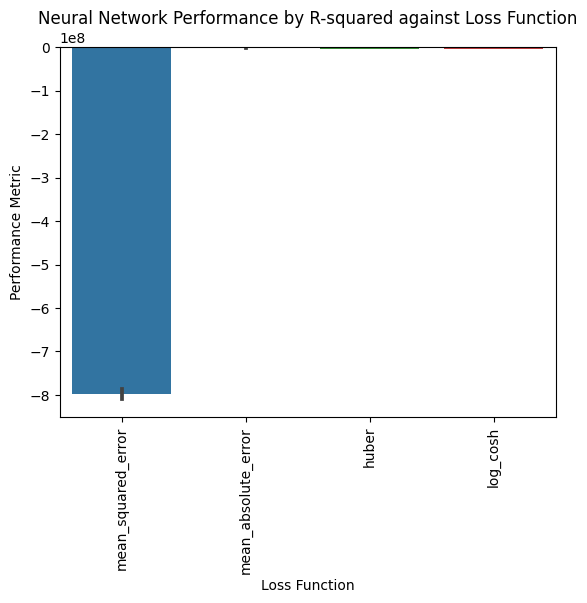

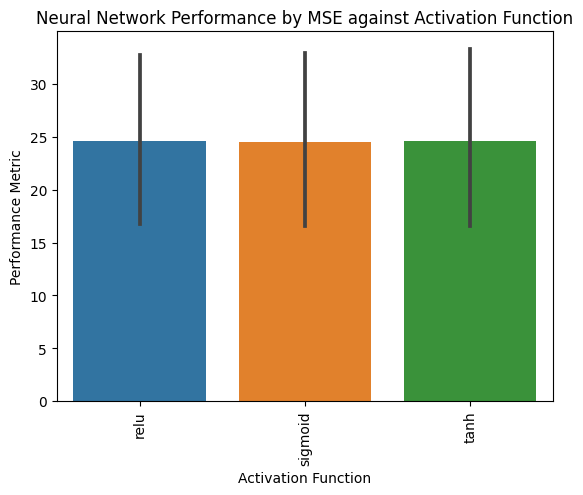

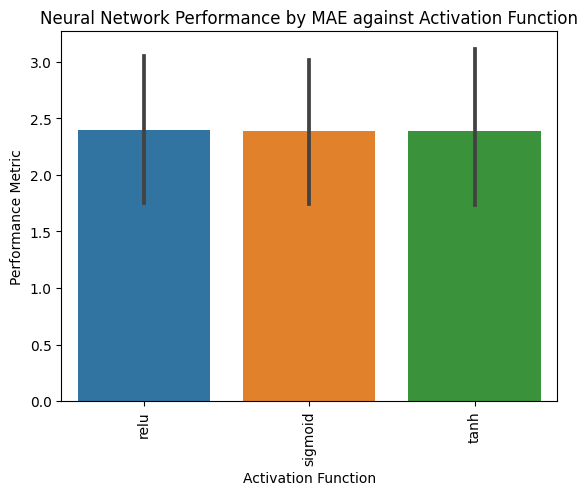

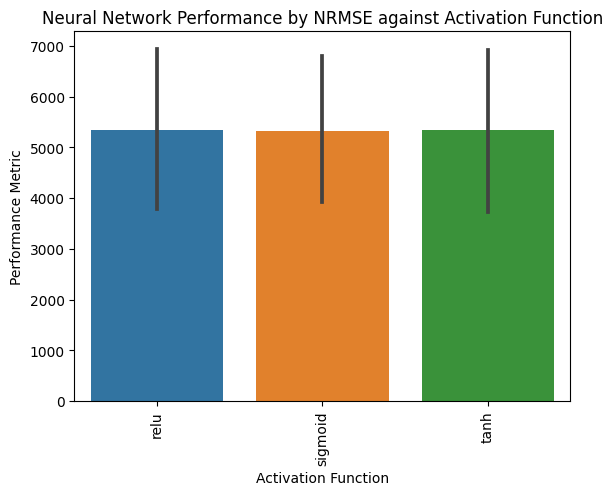

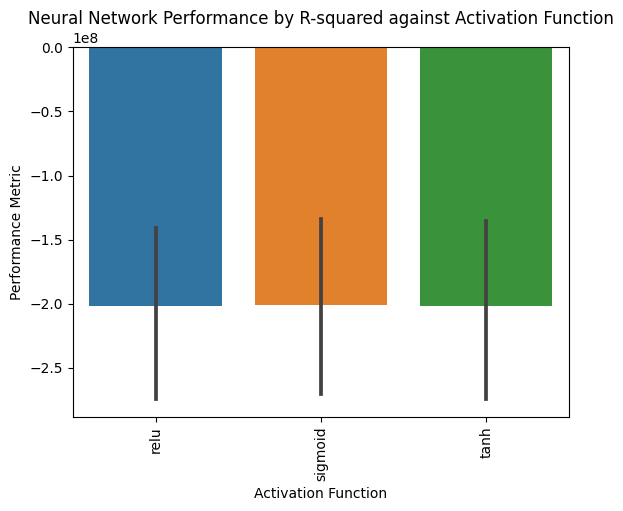

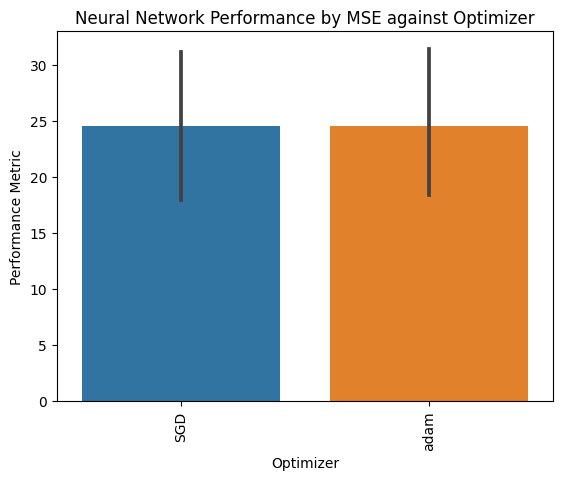

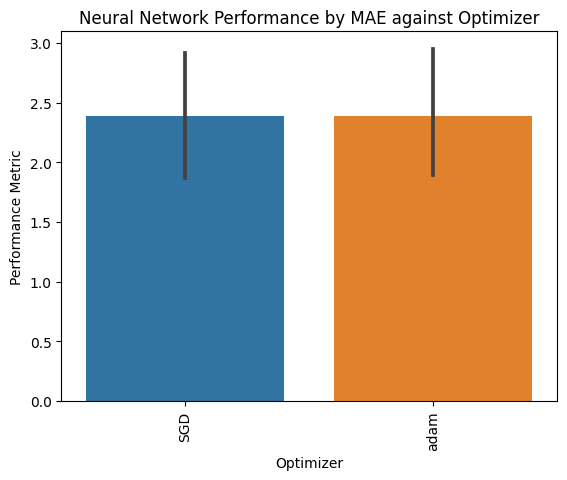

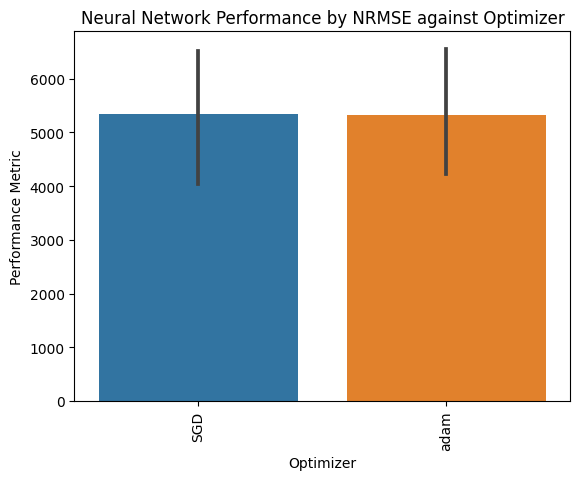

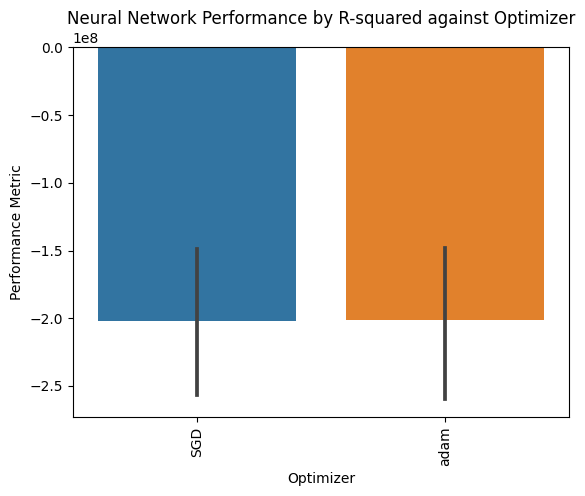

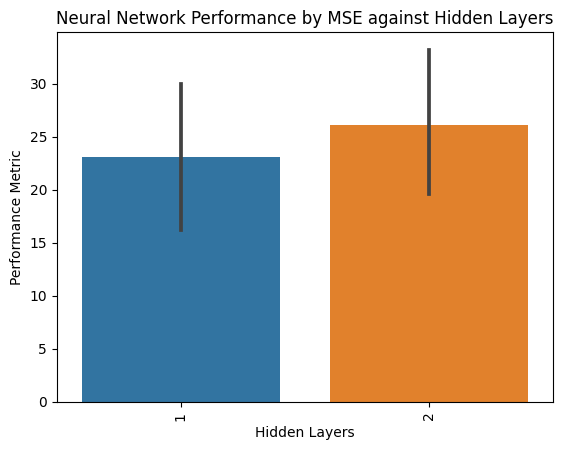

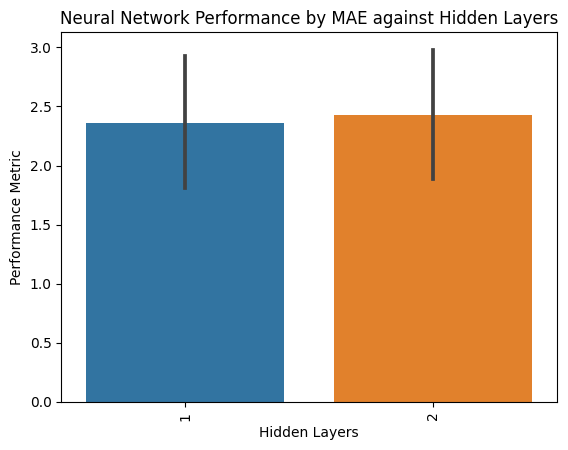

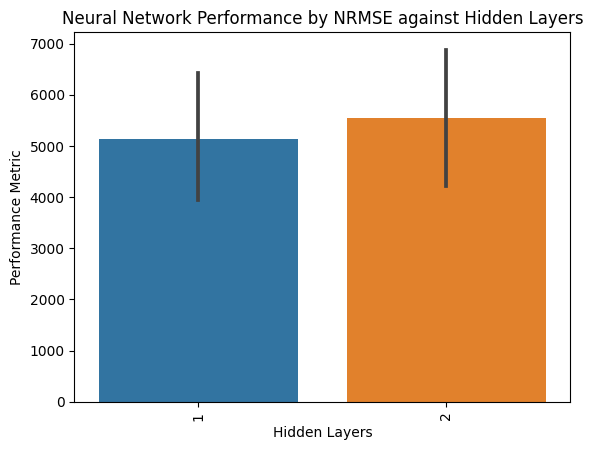

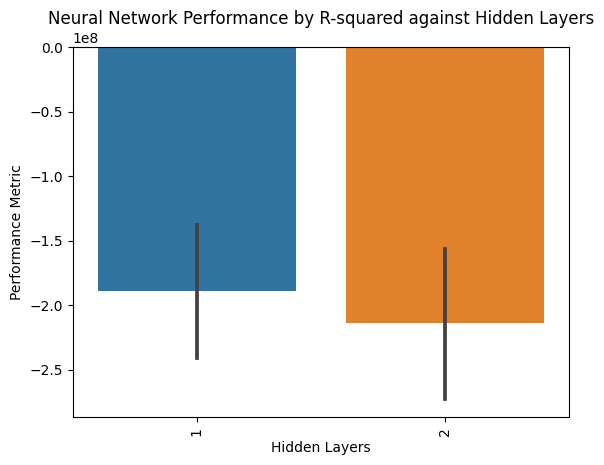

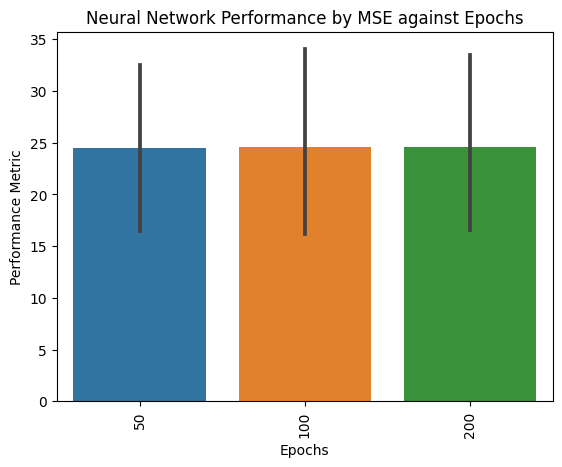

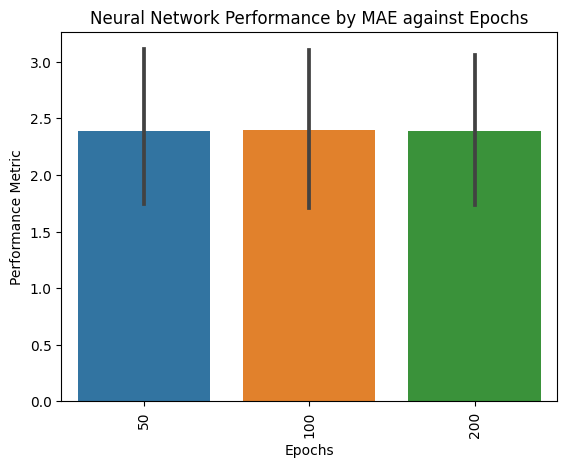

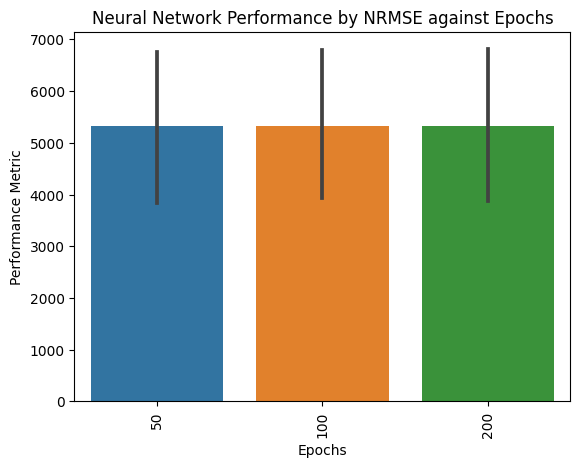

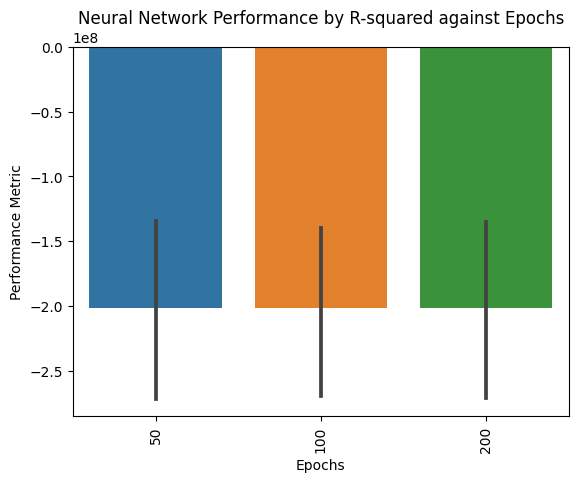

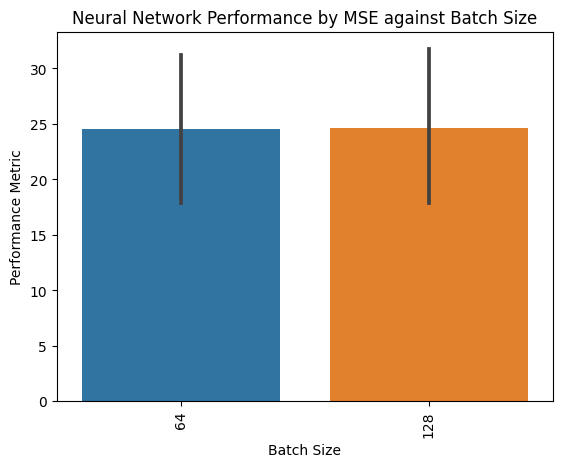

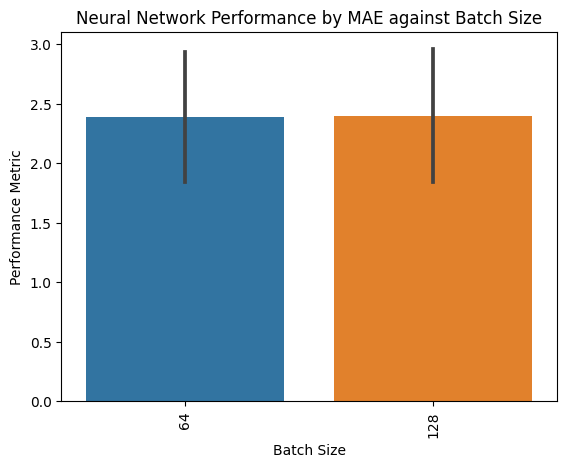

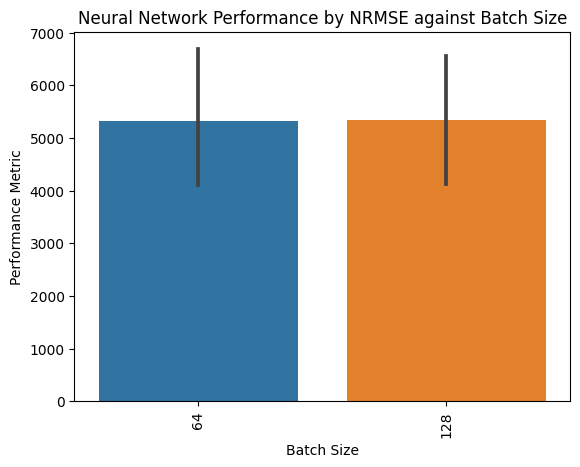

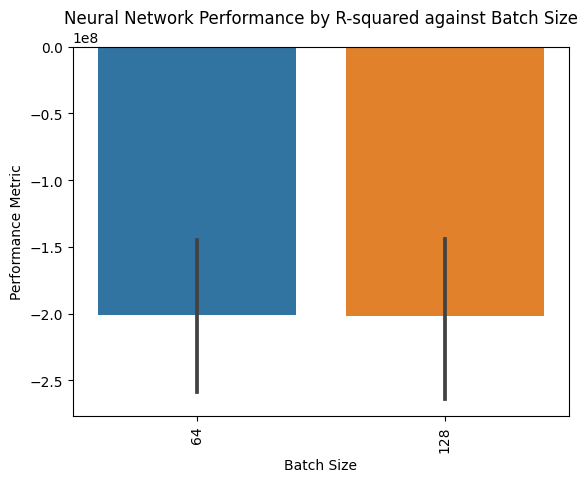

In [48]:
nn_pca13_results_injury_rate_df = nn_pca13_results_df[nn_pca13_results_df["Target"] == "Injury Rate"]

for x_metric in x_metrics:
    for y_metric in y_metrics:
        create_nn_performance_chart(nn_pca13_results_injury_rate_df, x_metric, y_metric)

In [49]:
print_overall_nn_min_stats(nn_pca13_results_injury_rate_df, 'Neural Network (PCA n = 13) Injury Rate Performance')

Neural Network (PCA n = 13) Injury Rate Performance
Model                       576
Target                      576
Loss Function               720
Activation Function         576
Optimizer                   576
Hidden Layers               576
Epochs                      576
Batch Size                  576
Neurons per hidden layer    576
MSE                         677
MAE                         689
NRMSE                       677
R-squared                   585
dtype: int64 



In [50]:
nn_pca13_results_df.iloc[[677]]

Model       Target        Loss Function  \
677  Neural Network (PCA n = 13)  Injury Rate  mean_absolute_error   

    Activation Function Optimizer  Hidden Layers  Epochs  Batch Size  \
677             sigmoid       SGD              1     200         128   

     Neurons per hidden layer       MSE       MAE       NRMSE    R-squared  
677                        32  0.037936  0.138176  360.976593 -311529.3039

In [51]:
def optimised_nn_pca13_injury_rate_model(df_X, df_y, X_test, y_test, target):
    # Create the model
    model = Sequential([
        Input(shape=(df_X.shape[1],)),
        Dense(32, activation='sigmoid'),
        Dense(1)
    ])

    model.compile(loss='mean_absolute_error', optimizer='SGD')
    model.fit(df_X, df_y, epochs=200, batch_size=128, verbose=0)
    model.save('nn_pca13_injury_rate_model.keras')

    # Evaluate on validation set (optional)
    val_loss = model.evaluate(df_X, df_y, verbose=0)
    print(f"Training Loss: {val_loss}")

    # Evaluate on test set
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test[target], y_pred)
    mae = mean_absolute_error(y_test[target], y_pred)
    nrmse = normalized_root_mean_squared_error(y_test[target], y_pred)
    r2 = r2_score(y_test[target], y_pred)

    # Print performance metrics
    print(f"Neural Network (PCA n = 13) Performance for {target}:")
    print("MSE:", mse)
    print("MAE:", mae)
    print("NRMSE:", nrmse)
    print("R-squared:", r2, '\n')

    return mse, mae, nrmse, r2

mse, mae, nrmse, r2 = optimised_nn_pca13_injury_rate_model(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, 'Injury Rate')
add_evaluation_metrics('Neural Network (PCA n = 13)', 'Injury Rate', mse, mae, nrmse, r2)

Training Loss: 8.067456245422363
15/15 [==============================] - 0s 2ms/step
Neural Network (PCA n = 13) Performance for Injury Rate:
MSE: 0.013421087622096846
MAE: 0.09058764482418767
NRMSE: 214.7083838852284
R-squared: -110213.87730439262 



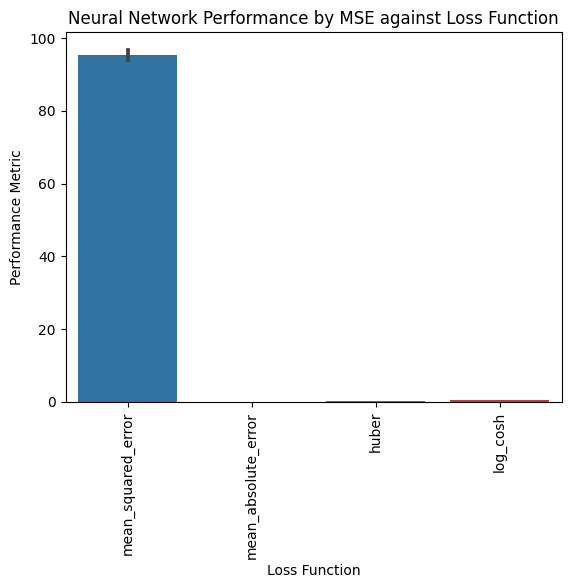

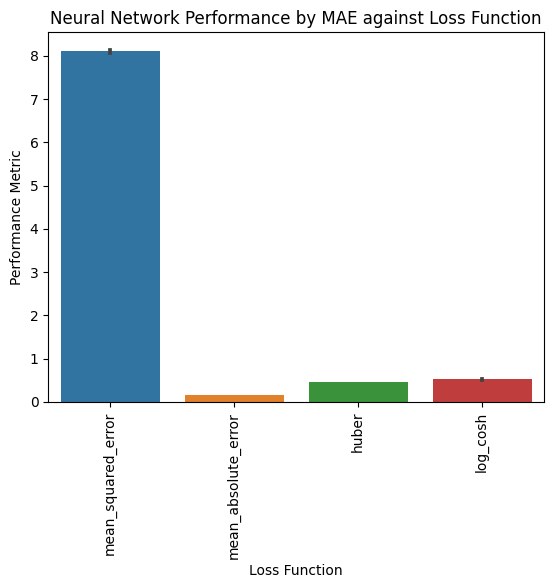

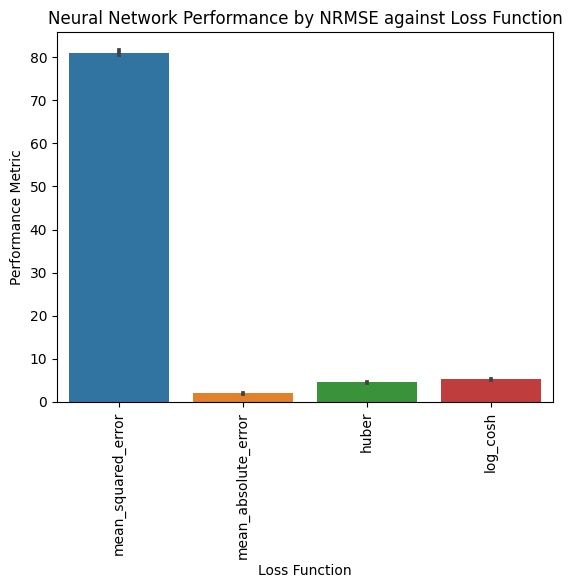

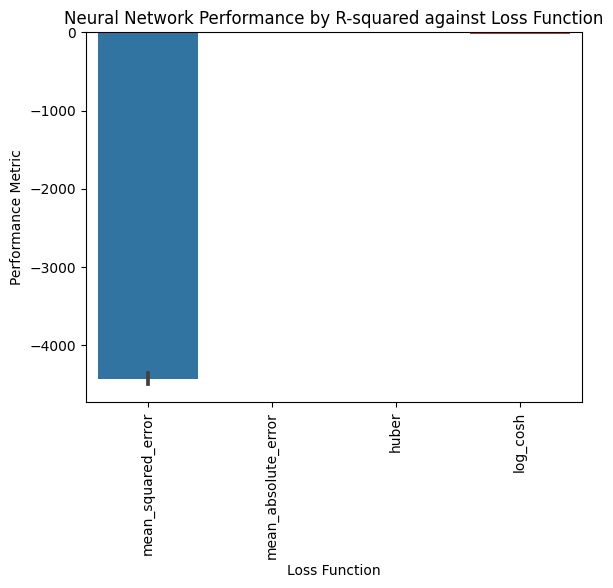

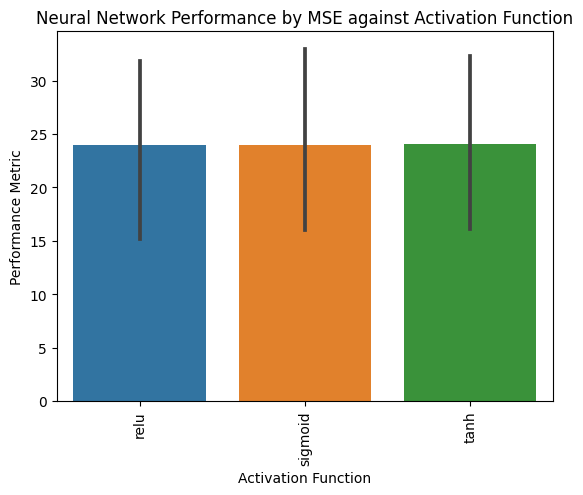

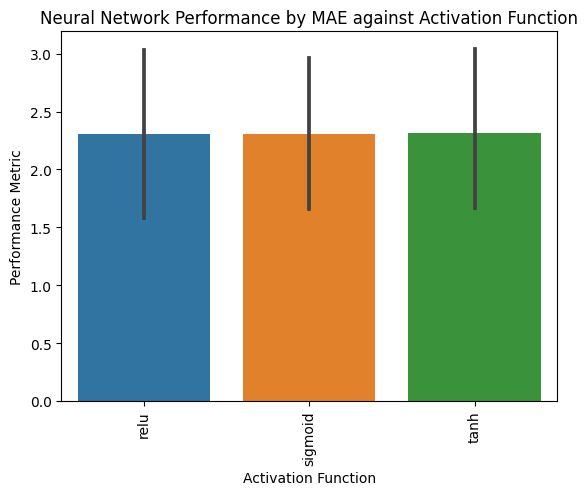

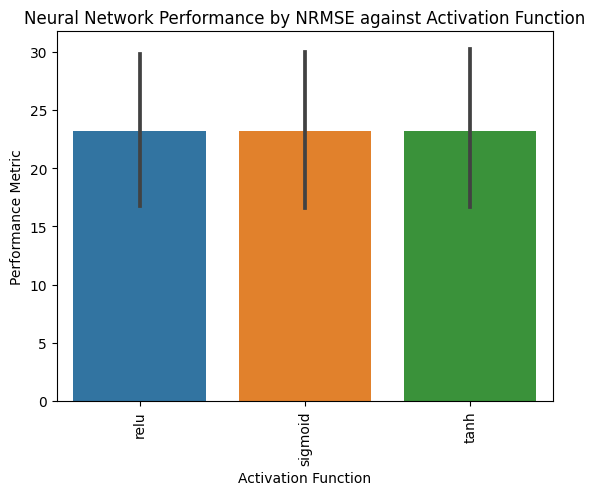

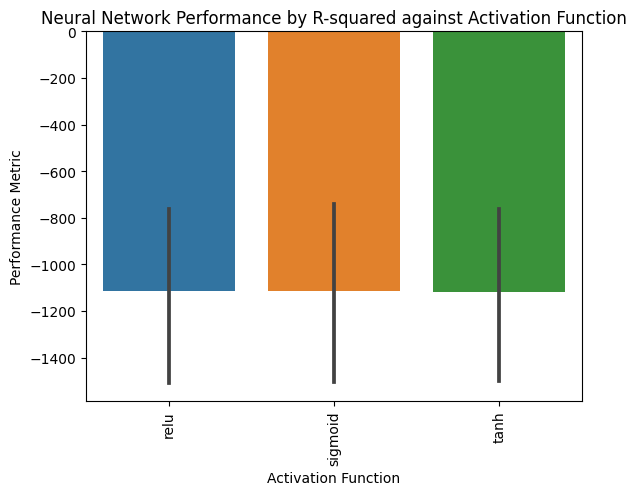

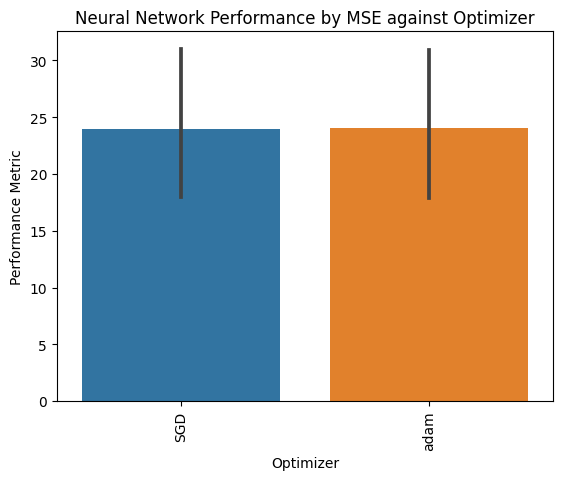

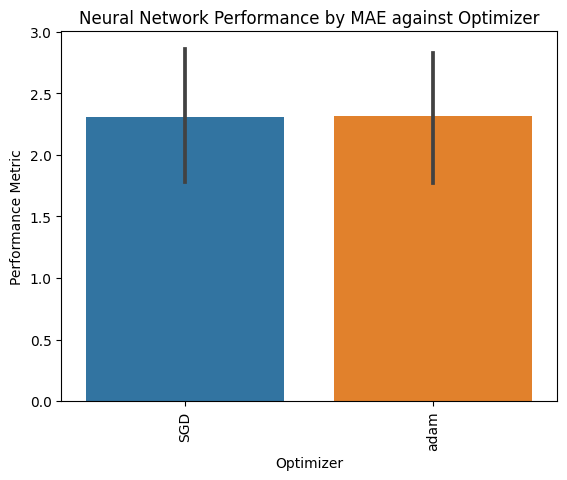

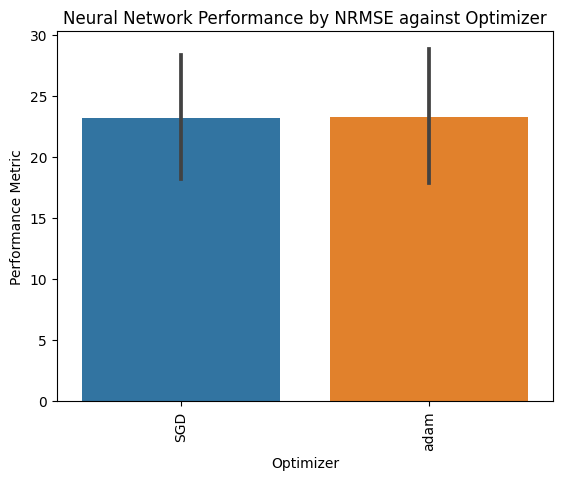

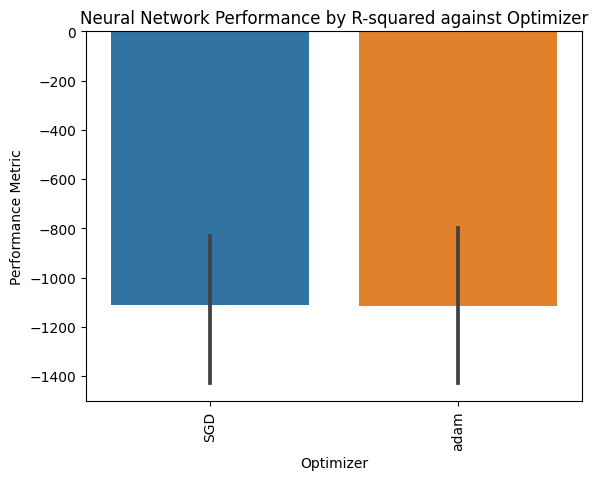

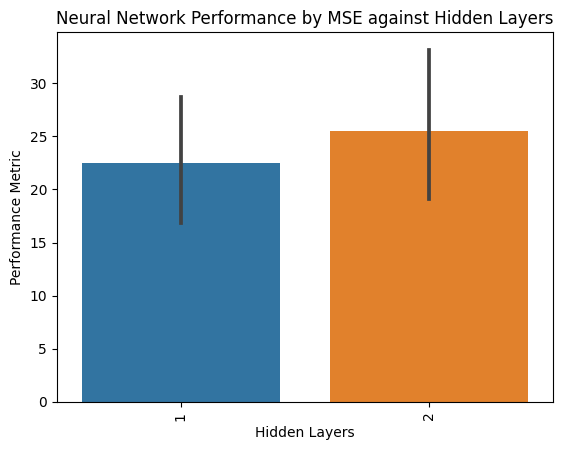

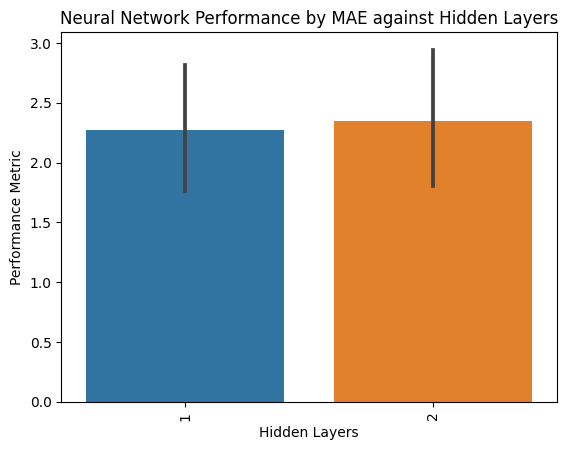

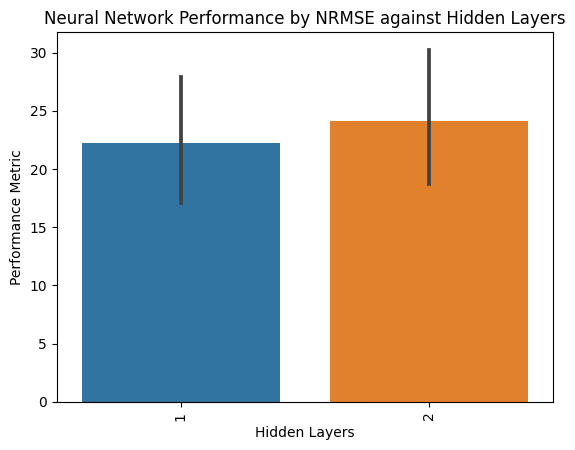

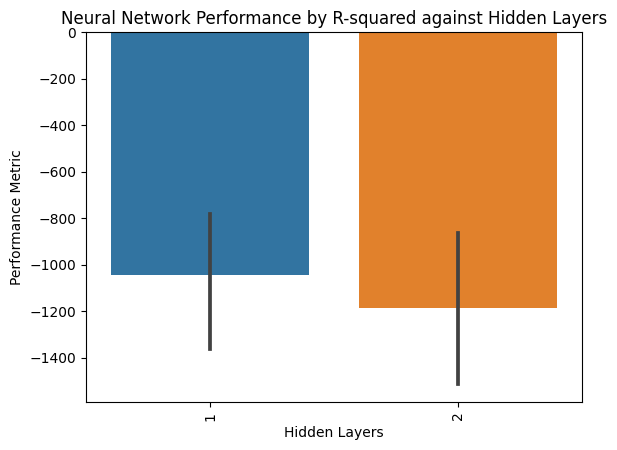

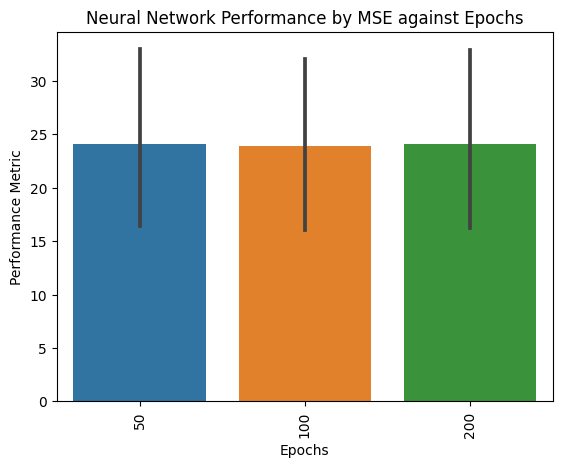

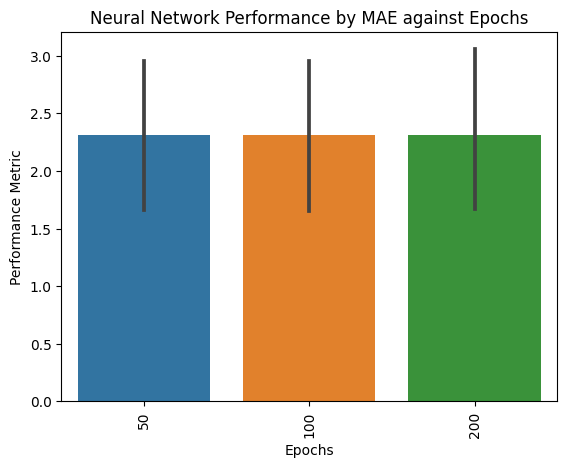

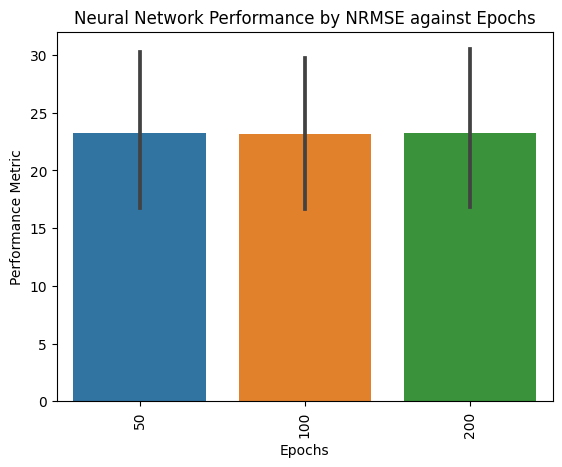

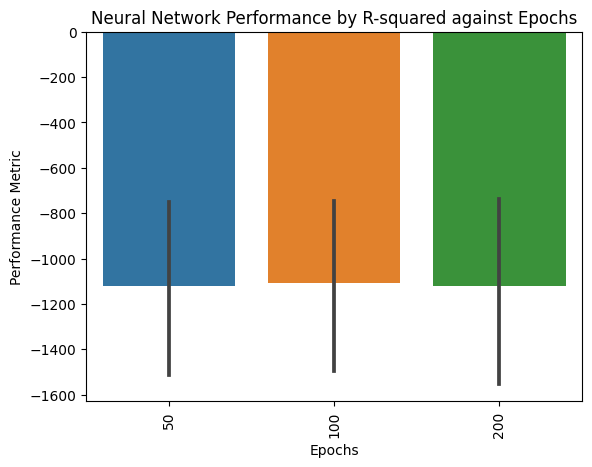

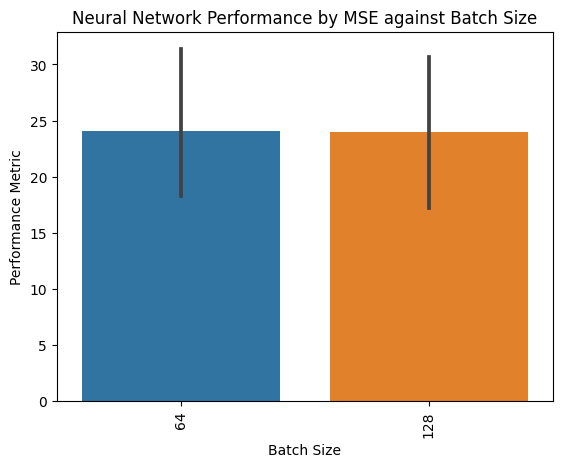

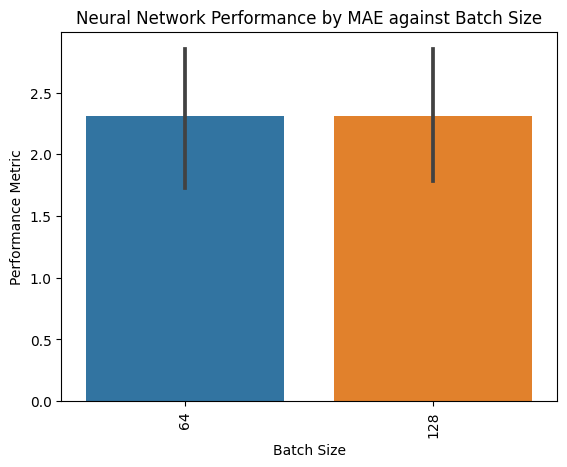

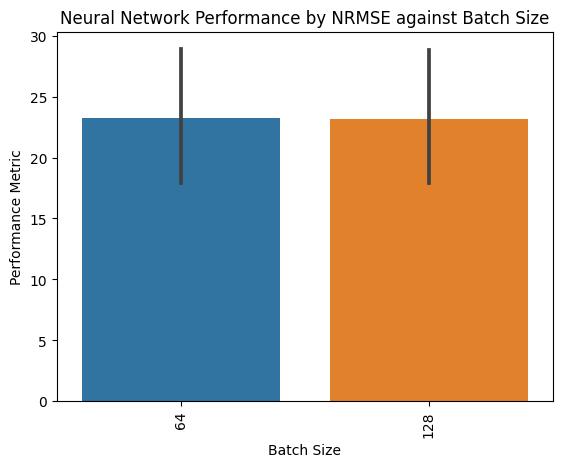

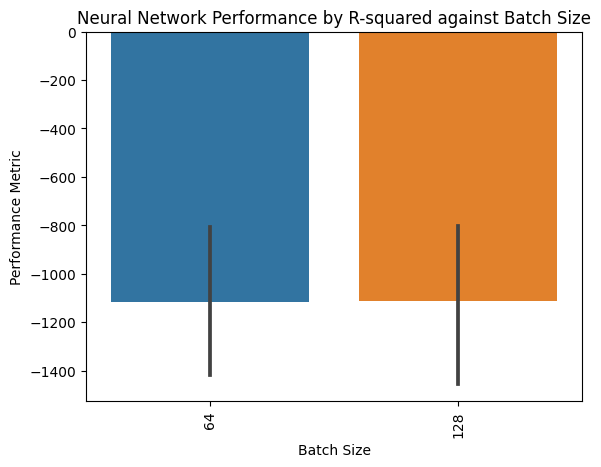

In [52]:
nn_pca13_results_avg_injury_cost_df = nn_pca13_results_df[nn_pca13_results_df["Target"] == "Average Injury Cost"]

for x_metric in x_metrics:
    for y_metric in y_metrics:
        create_nn_performance_chart(nn_pca13_results_avg_injury_cost_df, x_metric, y_metric)

In [53]:
print_overall_nn_min_stats(nn_pca13_results_avg_injury_cost_df, 'Neural Network (PCA n = 13) Average Injury Cost Performance')

Neural Network (PCA n = 13) Average Injury Cost Performance
Model                       288
Target                      288
Loss Function               432
Activation Function         288
Optimizer                   288
Hidden Layers               288
Epochs                      288
Batch Size                  288
Neurons per hidden layer    288
MSE                         377
MAE                         411
NRMSE                       377
R-squared                   310
dtype: int64 



In [54]:
nn_pca13_results_df.iloc[[377]]

Model               Target        Loss Function  \
377  Neural Network (PCA n = 13)  Average Injury Cost  mean_absolute_error   

    Activation Function Optimizer  Hidden Layers  Epochs  Batch Size  \
377                relu      adam              1     200         128   

     Neurons per hidden layer       MSE       MAE    NRMSE  R-squared  
377                        32  0.029009  0.123165  1.41496  -0.346792

In [55]:
def optimised_nn_pca13_avg_injury_cost_model(df_X, df_y, X_test, y_test, target):
    # Create the model
    model = Sequential([
        Input(shape=(df_X.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    model.compile(loss='mean_absolute_error', optimizer='adam')
    model.fit(df_X, df_y, epochs=200, batch_size=128, verbose=0)
    model.save('nn_pca13_avg_injury_cost_model.keras')

    # Evaluate on validation set (optional)
    val_loss = model.evaluate(df_X, df_y, verbose=0)
    print(f"Training Loss: {val_loss}")

    # Evaluate on test set
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test[target], y_pred)
    mae = mean_absolute_error(y_test[target], y_pred)
    nrmse = normalized_root_mean_squared_error(y_test[target], y_pred)
    r2 = r2_score(y_test[target], y_pred)

    # Print performance metrics
    print(f"Neural Network (PCA n = 13) Performance for {target}:")
    print("MSE:", mse)
    print("MAE:", mae)
    print("NRMSE:", nrmse)
    print("R-squared:", r2, '\n')

    return mse, mae, nrmse, r2

mse, mae, nrmse, r2 = optimised_nn_pca13_avg_injury_cost_model(outfield_X_train, outfield_y_train, outfield_X_test, outfield_y_test, 'Average Injury Cost')
add_evaluation_metrics('Neural Network (PCA n = 13)', 'Average Injury Cost', mse, mae, nrmse, r2)

Training Loss: 8.034541130065918
15/15 [==============================] - 0s 2ms/step
Neural Network (PCA n = 13) Performance for Average Injury Cost:
MSE: 0.06799785768774856
MAE: 0.17715041739831644
NRMSE: 2.166346981214495
R-squared: -2.1569529610872356 



# Comparing the performance of different models
Now that we have several models, we can compare the performance of these models by plotting a graph of Evaluation Metrics against Model, for each target that we are trying to predict.

In [56]:
eval_metrics_df = pd.DataFrame(evaluation_metrics)
eval_metrics_df.to_csv('model_performance.csv', index = False)

In [57]:
def plot_model_comparison(df, x, target):
    """
    Plots the performance of different models for a specific target variable.

    Args:
    df: DataFrame containing model performance metrics.
    target: Target variable to focus on.
    """

    # Filter data for the specified target
    target_df = df[df['Target'] == target]

    # Create a bar plot using Seaborn
    plt.figure(figsize=(8, 6))
    sns.barplot(x=x, y='Model', data=target_df, orient='h')
    plt.title(f'Model Performance by {target}')
    plt.xlabel(f'{x}')
    plt.ylabel('Model')
    plt.show()


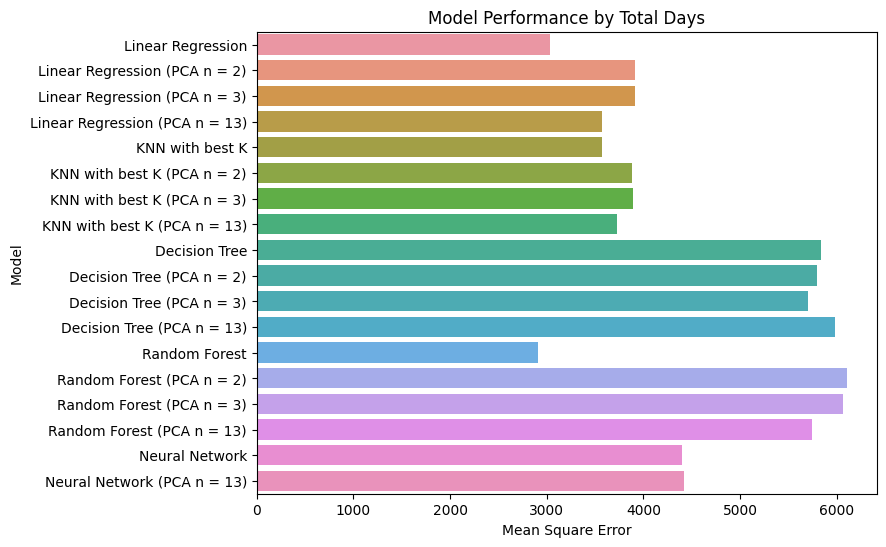

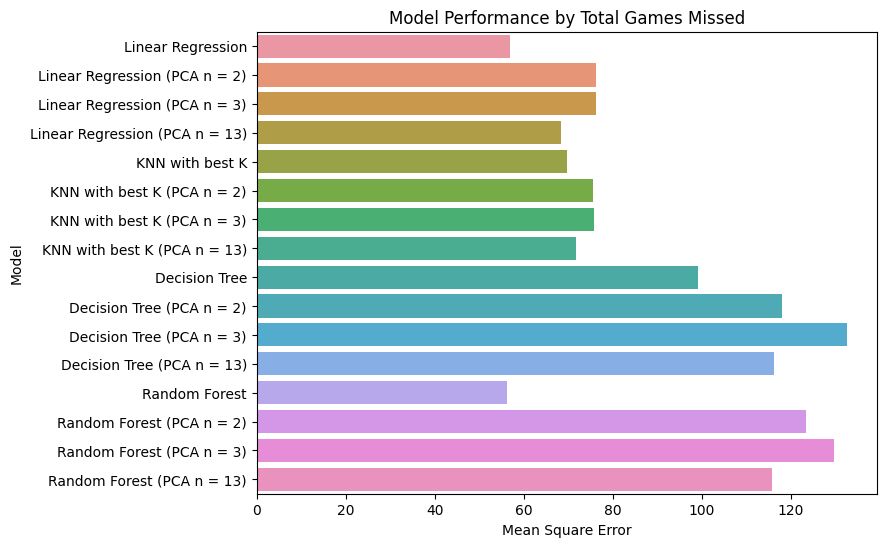

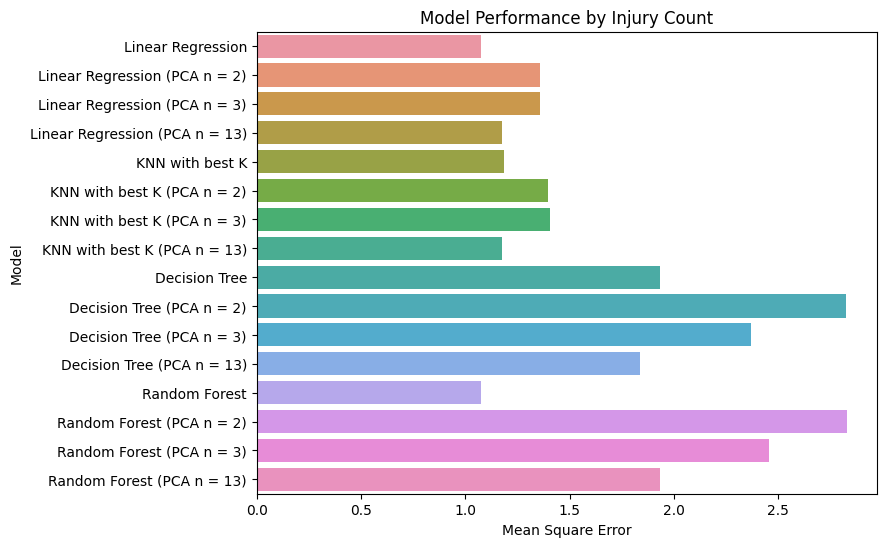

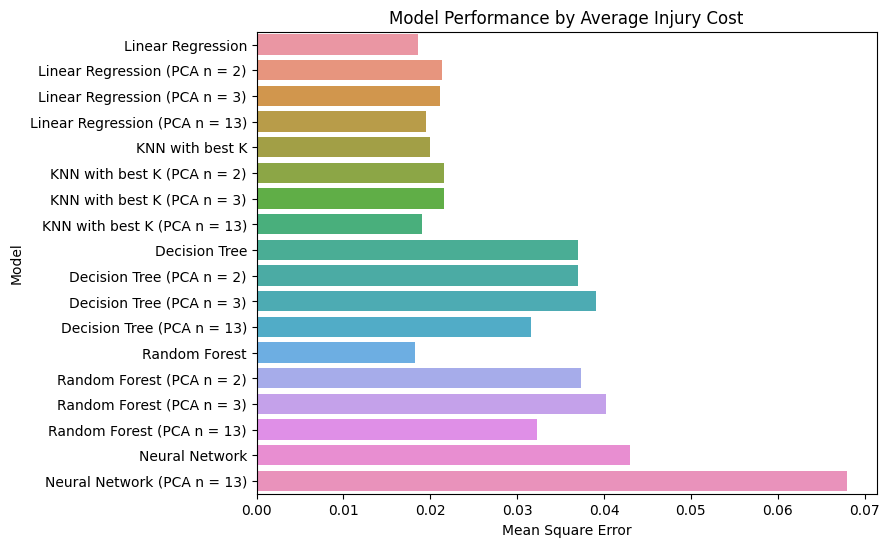

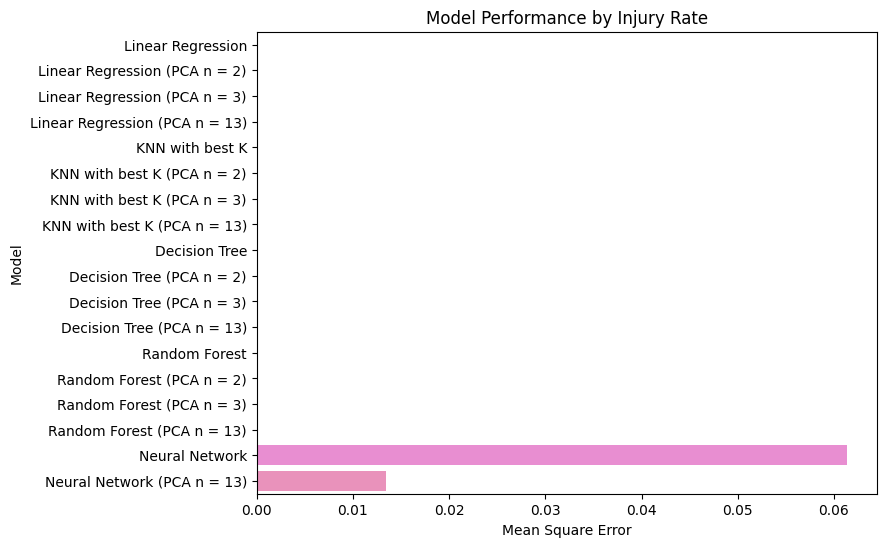

In [58]:
for target in targets:
    plot_model_comparison(eval_metrics_df, 'Mean Square Error', target)

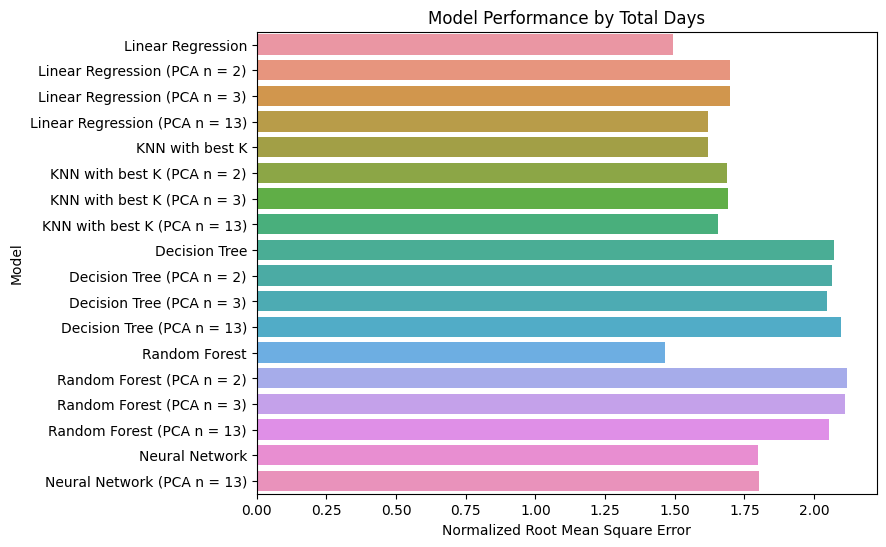

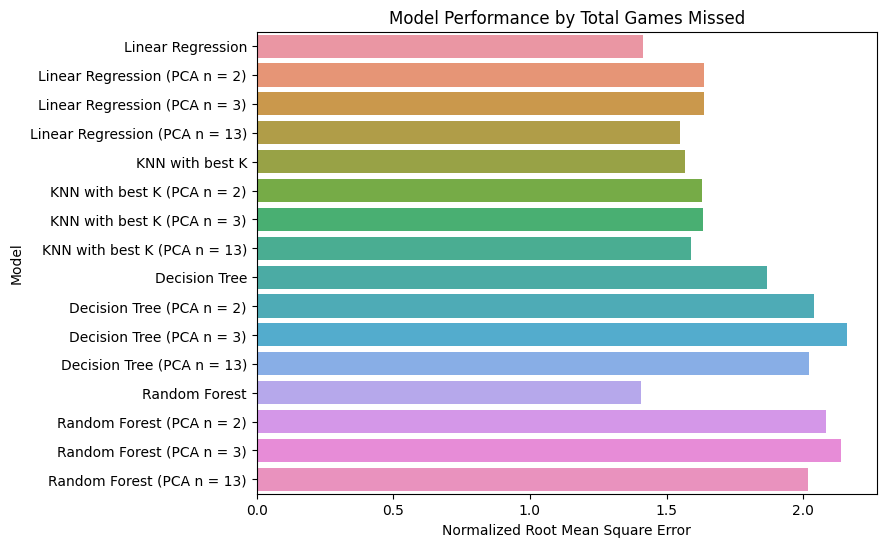

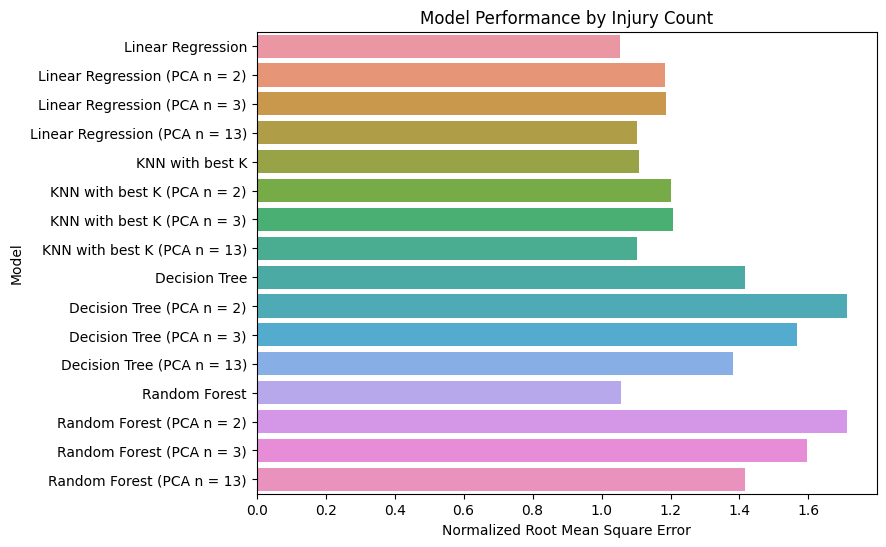

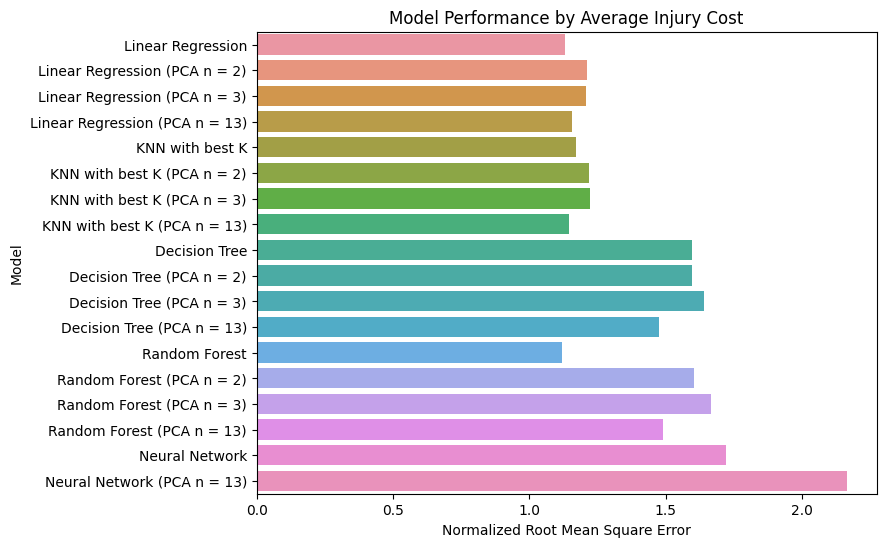

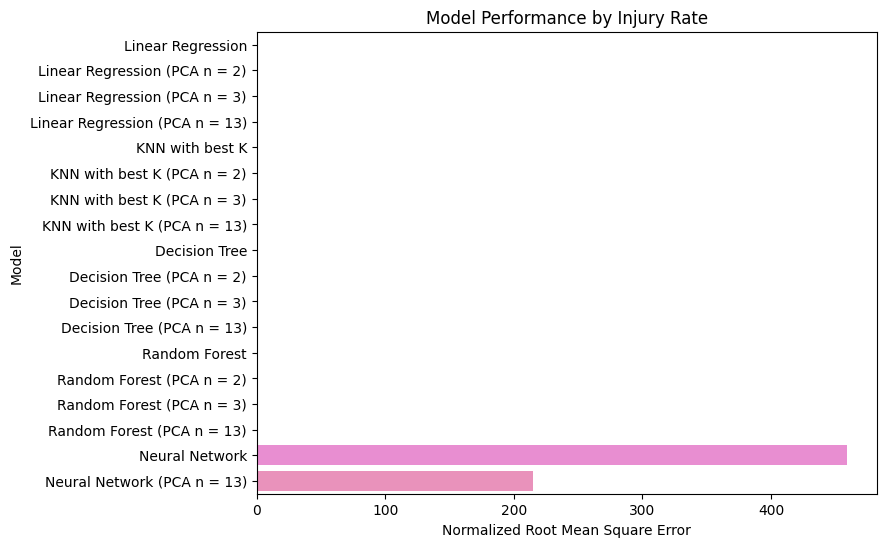

In [59]:
for target in targets:
    plot_model_comparison(eval_metrics_df, 'Normalized Root Mean Square Error', target)

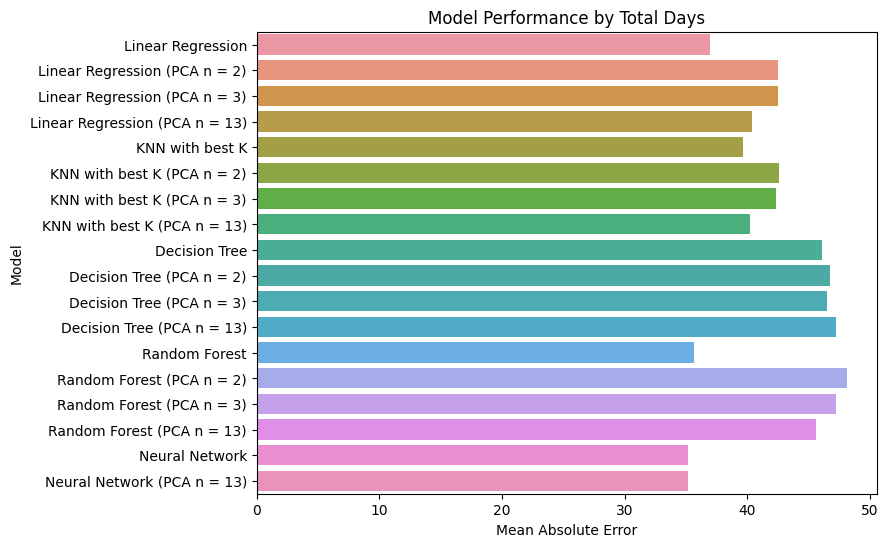

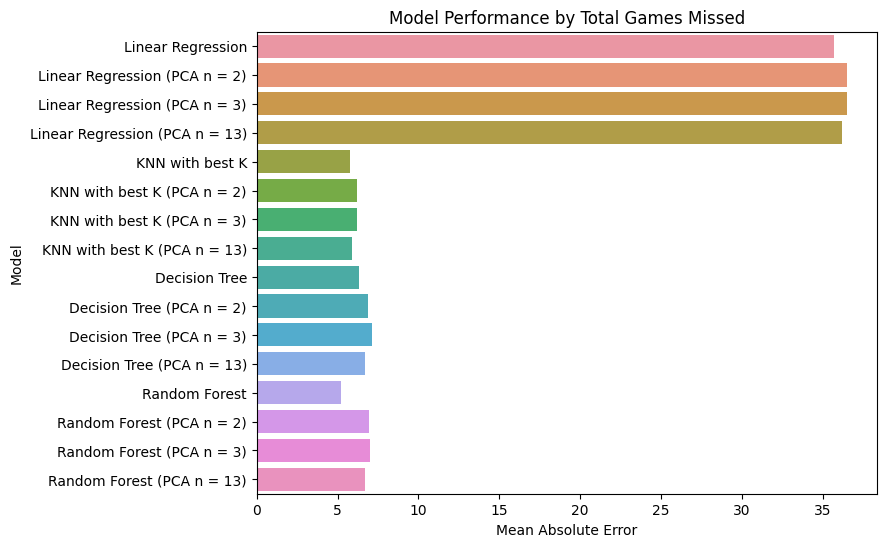

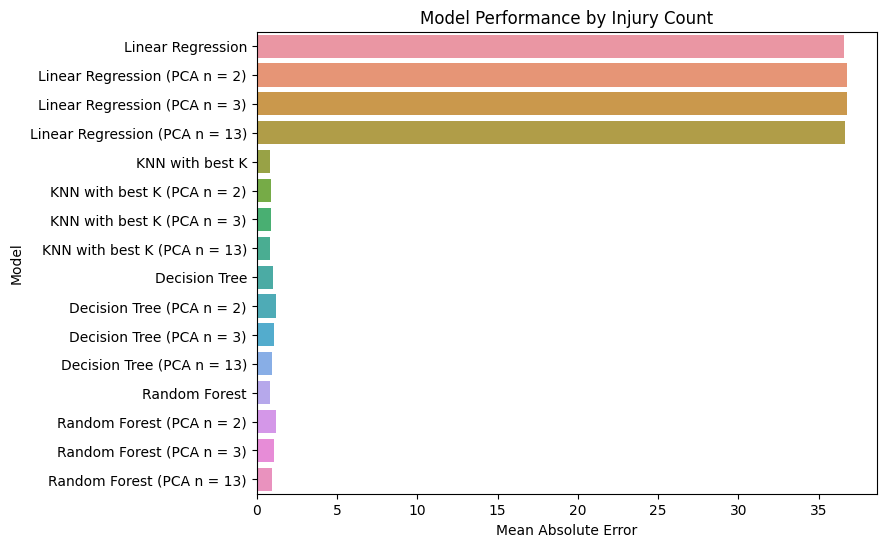

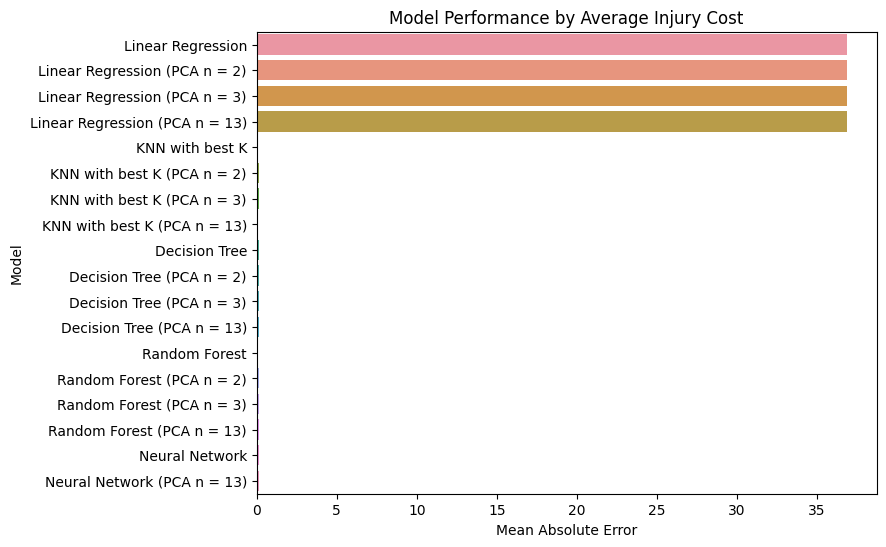

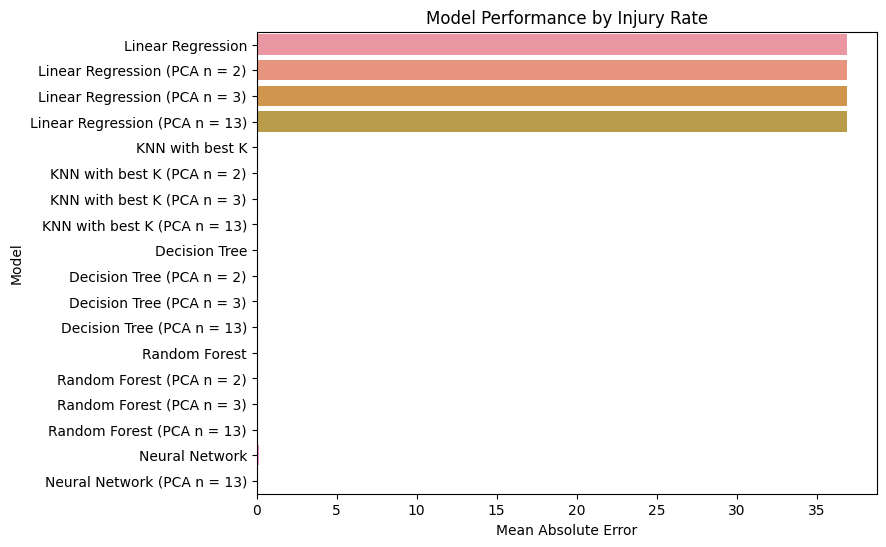

In [60]:
for target in targets:
    plot_model_comparison(eval_metrics_df, 'Mean Absolute Error', target)

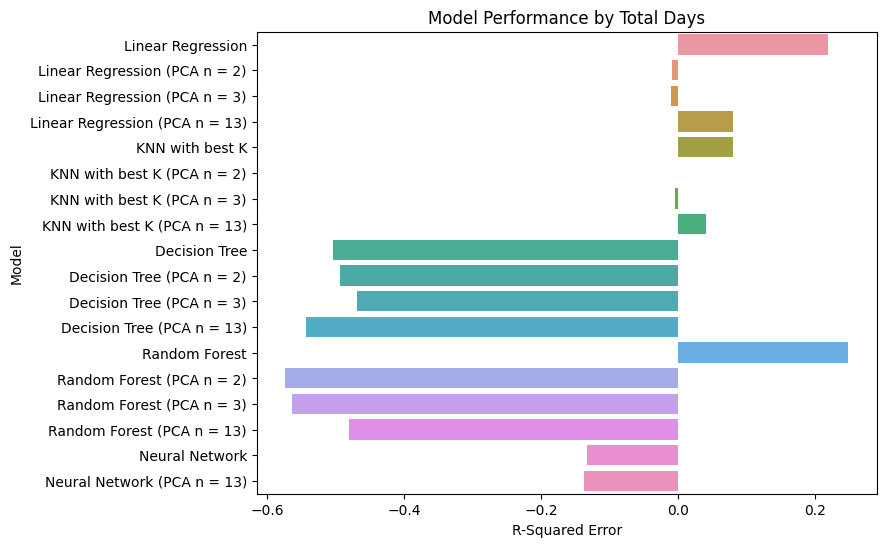

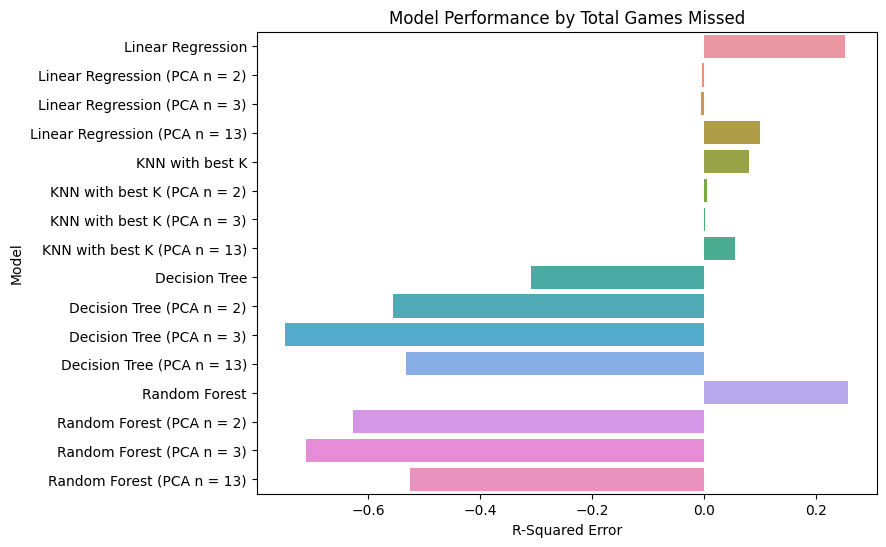

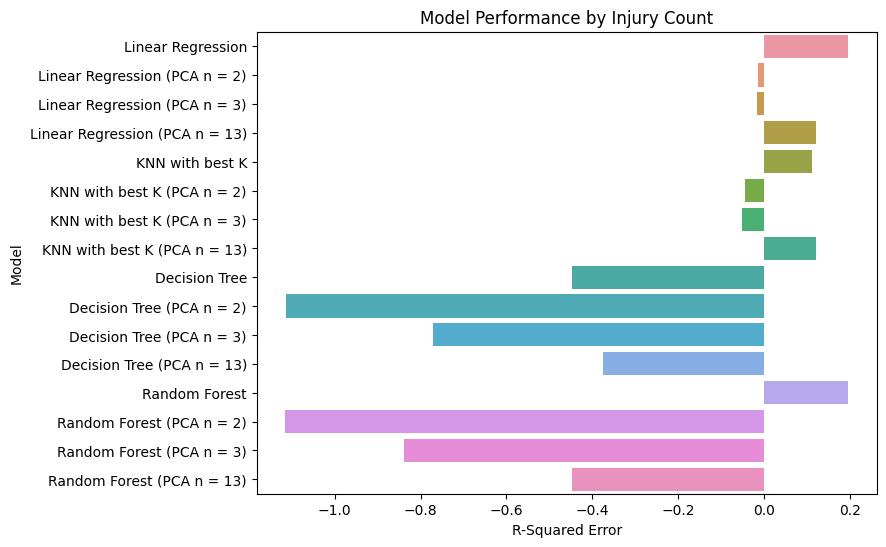

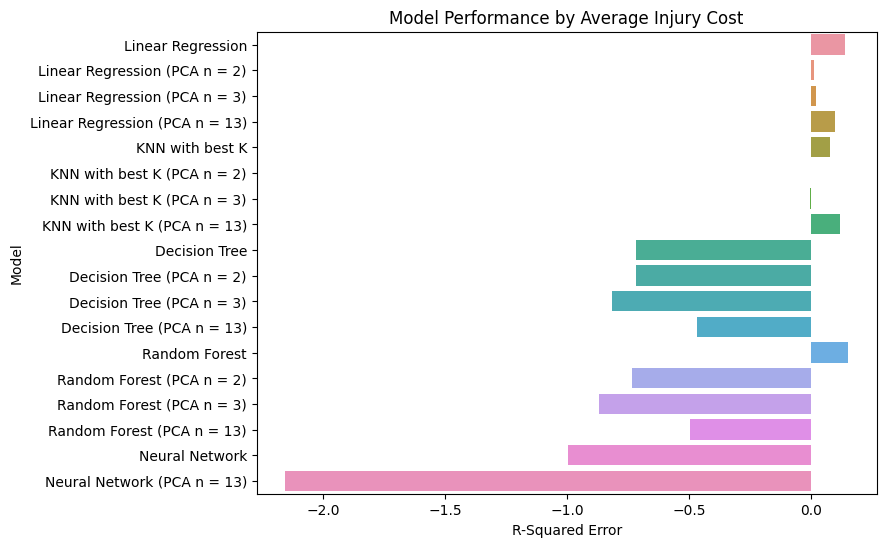

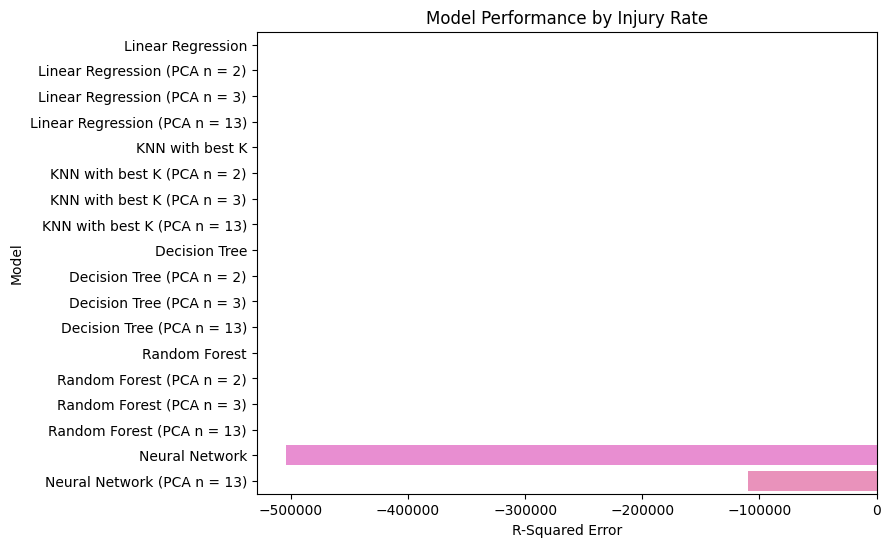

In [61]:
for target in targets:
    plot_model_comparison(eval_metrics_df, 'R-Squared Error', target)